In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


Loaded 48790 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 hu88k90i


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                              | 0/2934 [00:00<?, ?it/s]

  0%|                                                                                                                                                      | 1/2934 [00:00<37:32,  1.30it/s]

  0%|                                                                                                                                                      | 2/2934 [00:00<20:23,  2.40it/s]

  0%|▏                                                                                                                                                     | 3/2934 [00:01<14:52,  3.28it/s]

  0%|▏                                                                                                                                                     | 4/2934 [00:01<12:18,  3.97it/s]

  0%|▎                                                                                                                                                     | 5/2934 [00:01<10:53,  4.48it/s]

  0%|▎                                                                                                                                                     | 6/2934 [00:01<10:01,  4.87it/s]

  0%|▎                                                                                                                                                     | 7/2934 [00:01<09:29,  5.14it/s]

  0%|▍                                                                                                                                                     | 8/2934 [00:01<09:08,  5.34it/s]

  0%|▍                                                                                                                                                     | 9/2934 [00:02<08:53,  5.48it/s]

  0%|▌                                                                                                                                                    | 10/2934 [00:02<08:43,  5.58it/s]

  0%|▌                                                                                                                                                    | 11/2934 [00:02<08:36,  5.65it/s]

  0%|▌                                                                                                                                                    | 12/2934 [00:02<08:32,  5.70it/s]

  0%|▋                                                                                                                                                    | 13/2934 [00:02<08:28,  5.74it/s]

  0%|▋                                                                                                                                                    | 14/2934 [00:02<08:27,  5.76it/s]

  1%|▊                                                                                                                                                    | 15/2934 [00:03<08:24,  5.78it/s]

  1%|▊                                                                                                                                                    | 16/2934 [00:03<08:22,  5.80it/s]

  1%|▊                                                                                                                                                    | 17/2934 [00:03<08:21,  5.82it/s]

  1%|▉                                                                                                                                                    | 18/2934 [00:03<08:20,  5.82it/s]

  1%|▉                                                                                                                                                    | 19/2934 [00:03<08:20,  5.82it/s]

  1%|█                                                                                                                                                    | 20/2934 [00:04<08:20,  5.83it/s]

  1%|█                                                                                                                                                    | 21/2934 [00:04<08:19,  5.83it/s]

  1%|█                                                                                                                                                    | 22/2934 [00:04<08:19,  5.83it/s]

  1%|█▏                                                                                                                                                   | 23/2934 [00:04<08:19,  5.83it/s]

  1%|█▏                                                                                                                                                   | 24/2934 [00:04<08:19,  5.83it/s]

  1%|█▎                                                                                                                                                   | 25/2934 [00:04<08:19,  5.82it/s]

  1%|█▎                                                                                                                                                   | 26/2934 [00:05<08:19,  5.82it/s]

  1%|█▎                                                                                                                                                   | 27/2934 [00:05<08:19,  5.83it/s]

  1%|█▍                                                                                                                                                   | 28/2934 [00:05<08:18,  5.83it/s]

  1%|█▍                                                                                                                                                   | 29/2934 [00:05<08:18,  5.82it/s]

  1%|█▌                                                                                                                                                   | 30/2934 [00:05<08:19,  5.82it/s]

  1%|█▌                                                                                                                                                   | 31/2934 [00:05<08:18,  5.82it/s]

  1%|█▋                                                                                                                                                   | 32/2934 [00:06<08:18,  5.83it/s]

  1%|█▋                                                                                                                                                   | 33/2934 [00:06<08:17,  5.83it/s]

  1%|█▋                                                                                                                                                   | 34/2934 [00:06<08:17,  5.83it/s]

  1%|█▊                                                                                                                                                   | 35/2934 [00:06<08:16,  5.84it/s]

  1%|█▊                                                                                                                                                   | 36/2934 [00:06<08:16,  5.84it/s]

  1%|█▉                                                                                                                                                   | 37/2934 [00:06<08:16,  5.84it/s]

  1%|█▉                                                                                                                                                   | 38/2934 [00:07<08:16,  5.83it/s]

  1%|█▉                                                                                                                                                   | 39/2934 [00:07<08:16,  5.83it/s]

  1%|██                                                                                                                                                   | 40/2934 [00:07<08:16,  5.83it/s]

  1%|██                                                                                                                                                   | 41/2934 [00:07<08:15,  5.84it/s]

  1%|██▏                                                                                                                                                  | 42/2934 [00:07<08:15,  5.84it/s]

  1%|██▏                                                                                                                                                  | 43/2934 [00:07<08:15,  5.83it/s]

  1%|██▏                                                                                                                                                  | 44/2934 [00:08<08:15,  5.84it/s]

  2%|██▎                                                                                                                                                  | 45/2934 [00:08<08:15,  5.83it/s]

  2%|██▎                                                                                                                                                  | 46/2934 [00:08<08:15,  5.83it/s]

  2%|██▍                                                                                                                                                  | 47/2934 [00:08<08:15,  5.83it/s]

  2%|██▍                                                                                                                                                  | 48/2934 [00:08<08:14,  5.83it/s]

  2%|██▍                                                                                                                                                  | 49/2934 [00:09<08:14,  5.83it/s]

  2%|██▌                                                                                                                                                  | 50/2934 [00:09<08:14,  5.83it/s]

  2%|██▌                                                                                                                                                  | 51/2934 [00:09<08:14,  5.83it/s]

  2%|██▋                                                                                                                                                  | 52/2934 [00:09<08:14,  5.83it/s]

  2%|██▋                                                                                                                                                  | 53/2934 [00:09<08:14,  5.82it/s]

  2%|██▋                                                                                                                                                  | 54/2934 [00:09<08:14,  5.82it/s]

  2%|██▊                                                                                                                                                  | 55/2934 [00:10<08:14,  5.82it/s]

  2%|██▊                                                                                                                                                  | 56/2934 [00:10<08:14,  5.82it/s]

  2%|██▉                                                                                                                                                  | 57/2934 [00:10<08:14,  5.82it/s]

  2%|██▉                                                                                                                                                  | 58/2934 [00:10<08:13,  5.82it/s]

  2%|██▉                                                                                                                                                  | 59/2934 [00:10<08:13,  5.83it/s]

  2%|███                                                                                                                                                  | 60/2934 [00:10<08:13,  5.82it/s]

  2%|███                                                                                                                                                  | 61/2934 [00:11<08:13,  5.83it/s]

  2%|███▏                                                                                                                                                 | 62/2934 [00:11<08:12,  5.83it/s]

  2%|███▏                                                                                                                                                 | 63/2934 [00:11<08:12,  5.83it/s]

  2%|███▎                                                                                                                                                 | 64/2934 [00:11<08:11,  5.83it/s]

  2%|███▎                                                                                                                                                 | 65/2934 [00:11<08:11,  5.84it/s]

  2%|███▎                                                                                                                                                 | 66/2934 [00:11<08:11,  5.84it/s]

  2%|███▍                                                                                                                                                 | 67/2934 [00:12<08:11,  5.83it/s]

  2%|███▍                                                                                                                                                 | 68/2934 [00:12<08:11,  5.84it/s]

  2%|███▌                                                                                                                                                 | 69/2934 [00:12<08:10,  5.84it/s]

  2%|███▌                                                                                                                                                 | 70/2934 [00:12<08:10,  5.84it/s]

  2%|███▌                                                                                                                                                 | 71/2934 [00:12<08:09,  5.85it/s]

  2%|███▋                                                                                                                                                 | 72/2934 [00:12<08:09,  5.84it/s]

  2%|███▋                                                                                                                                                 | 73/2934 [00:13<08:10,  5.83it/s]

  3%|███▊                                                                                                                                                 | 74/2934 [00:13<08:11,  5.82it/s]

  3%|███▊                                                                                                                                                 | 75/2934 [00:13<08:11,  5.82it/s]

  3%|███▊                                                                                                                                                 | 76/2934 [00:13<08:11,  5.82it/s]

  3%|███▉                                                                                                                                                 | 77/2934 [00:13<08:11,  5.82it/s]

  3%|███▉                                                                                                                                                 | 78/2934 [00:13<08:10,  5.82it/s]

  3%|████                                                                                                                                                 | 79/2934 [00:14<08:10,  5.82it/s]

  3%|████                                                                                                                                                 | 80/2934 [00:14<08:10,  5.82it/s]

  3%|████                                                                                                                                                 | 81/2934 [00:14<08:10,  5.82it/s]

  3%|████▏                                                                                                                                                | 82/2934 [00:14<08:09,  5.83it/s]

  3%|████▏                                                                                                                                                | 83/2934 [00:14<08:09,  5.83it/s]

  3%|████▎                                                                                                                                                | 84/2934 [00:15<08:09,  5.83it/s]

  3%|████▎                                                                                                                                                | 85/2934 [00:15<08:08,  5.83it/s]

  3%|████▎                                                                                                                                                | 86/2934 [00:15<08:08,  5.84it/s]

  3%|████▍                                                                                                                                                | 87/2934 [00:15<08:07,  5.84it/s]

  3%|████▍                                                                                                                                                | 88/2934 [00:15<08:07,  5.84it/s]

  3%|████▌                                                                                                                                                | 89/2934 [00:15<08:06,  5.85it/s]

  3%|████▌                                                                                                                                                | 90/2934 [00:16<08:06,  5.85it/s]

  3%|████▌                                                                                                                                                | 91/2934 [00:16<08:06,  5.85it/s]

  3%|████▋                                                                                                                                                | 92/2934 [00:16<08:05,  5.85it/s]

  3%|████▋                                                                                                                                                | 93/2934 [00:16<08:05,  5.85it/s]

  3%|████▊                                                                                                                                                | 94/2934 [00:16<08:06,  5.84it/s]

  3%|████▊                                                                                                                                                | 95/2934 [00:16<08:06,  5.83it/s]

  3%|████▉                                                                                                                                                | 96/2934 [00:17<08:06,  5.84it/s]

  3%|████▉                                                                                                                                                | 97/2934 [00:17<08:06,  5.84it/s]

  3%|████▉                                                                                                                                                | 98/2934 [00:17<08:06,  5.83it/s]

  3%|█████                                                                                                                                                | 99/2934 [00:17<08:05,  5.84it/s]

  3%|█████                                                                                                                                               | 100/2934 [00:17<08:05,  5.84it/s]

  3%|█████                                                                                                                                               | 101/2934 [00:17<08:05,  5.84it/s]

  3%|█████▏                                                                                                                                              | 102/2934 [00:18<08:05,  5.83it/s]

  4%|█████▏                                                                                                                                              | 103/2934 [00:18<08:05,  5.83it/s]

  4%|█████▏                                                                                                                                              | 104/2934 [00:18<08:05,  5.83it/s]

  4%|█████▎                                                                                                                                              | 105/2934 [00:18<08:04,  5.83it/s]

  4%|█████▎                                                                                                                                              | 106/2934 [00:18<08:05,  5.83it/s]

  4%|█████▍                                                                                                                                              | 107/2934 [00:18<08:04,  5.83it/s]

  4%|█████▍                                                                                                                                              | 108/2934 [00:19<08:04,  5.83it/s]

  4%|█████▍                                                                                                                                              | 109/2934 [00:19<08:04,  5.83it/s]

  4%|█████▌                                                                                                                                              | 110/2934 [00:19<08:04,  5.83it/s]

  4%|█████▌                                                                                                                                              | 111/2934 [00:19<08:04,  5.83it/s]

  4%|█████▋                                                                                                                                              | 112/2934 [00:19<08:03,  5.83it/s]

  4%|█████▋                                                                                                                                              | 113/2934 [00:19<08:03,  5.83it/s]

  4%|█████▊                                                                                                                                              | 114/2934 [00:20<08:03,  5.84it/s]

  4%|█████▊                                                                                                                                              | 115/2934 [00:20<08:03,  5.83it/s]

  4%|█████▊                                                                                                                                              | 116/2934 [00:20<08:03,  5.83it/s]

  4%|█████▉                                                                                                                                              | 117/2934 [00:20<08:03,  5.83it/s]

  4%|█████▉                                                                                                                                              | 118/2934 [00:20<08:02,  5.83it/s]

  4%|██████                                                                                                                                              | 119/2934 [00:21<08:02,  5.83it/s]

  4%|██████                                                                                                                                              | 120/2934 [00:21<08:02,  5.83it/s]

  4%|██████                                                                                                                                              | 121/2934 [00:21<08:02,  5.83it/s]

  4%|██████▏                                                                                                                                             | 122/2934 [00:21<08:02,  5.83it/s]

  4%|██████▏                                                                                                                                             | 123/2934 [00:21<08:02,  5.82it/s]

  4%|██████▎                                                                                                                                             | 124/2934 [00:21<08:02,  5.83it/s]

  4%|██████▎                                                                                                                                             | 125/2934 [00:22<08:02,  5.83it/s]

  4%|██████▎                                                                                                                                             | 126/2934 [00:22<08:01,  5.83it/s]

  4%|██████▍                                                                                                                                             | 127/2934 [00:22<08:01,  5.83it/s]

  4%|██████▍                                                                                                                                             | 128/2934 [00:22<08:00,  5.83it/s]

  4%|██████▌                                                                                                                                             | 129/2934 [00:22<08:00,  5.83it/s]

  4%|██████▌                                                                                                                                             | 130/2934 [00:22<08:01,  5.83it/s]

  4%|██████▌                                                                                                                                             | 131/2934 [00:23<08:00,  5.83it/s]

  4%|██████▋                                                                                                                                             | 132/2934 [00:23<08:00,  5.83it/s]

  5%|██████▋                                                                                                                                             | 133/2934 [00:23<08:00,  5.83it/s]

  5%|██████▊                                                                                                                                             | 134/2934 [00:23<08:00,  5.83it/s]

  5%|██████▊                                                                                                                                             | 135/2934 [00:23<08:00,  5.82it/s]

  5%|██████▊                                                                                                                                             | 136/2934 [00:23<08:00,  5.82it/s]

  5%|██████▉                                                                                                                                             | 137/2934 [00:24<08:01,  5.81it/s]

  5%|██████▉                                                                                                                                             | 138/2934 [00:24<08:00,  5.81it/s]

  5%|███████                                                                                                                                             | 139/2934 [00:24<08:00,  5.81it/s]

  5%|███████                                                                                                                                             | 140/2934 [00:24<08:00,  5.82it/s]

  5%|███████                                                                                                                                             | 141/2934 [00:24<08:00,  5.82it/s]

  5%|███████▏                                                                                                                                            | 142/2934 [00:24<07:59,  5.82it/s]

  5%|███████▏                                                                                                                                            | 143/2934 [00:25<07:59,  5.82it/s]

  5%|███████▎                                                                                                                                            | 144/2934 [00:25<08:00,  5.81it/s]

  5%|███████▎                                                                                                                                            | 145/2934 [00:25<08:00,  5.81it/s]

  5%|███████▎                                                                                                                                            | 146/2934 [00:25<07:59,  5.81it/s]

  5%|███████▍                                                                                                                                            | 147/2934 [00:25<07:59,  5.82it/s]

  5%|███████▍                                                                                                                                            | 148/2934 [00:25<07:58,  5.82it/s]

  5%|███████▌                                                                                                                                            | 149/2934 [00:26<07:58,  5.82it/s]

  5%|███████▌                                                                                                                                            | 150/2934 [00:26<07:58,  5.82it/s]

  5%|███████▌                                                                                                                                            | 151/2934 [00:26<07:58,  5.81it/s]

  5%|███████▋                                                                                                                                            | 152/2934 [00:26<07:58,  5.81it/s]

  5%|███████▋                                                                                                                                            | 153/2934 [00:26<07:58,  5.81it/s]

  5%|███████▊                                                                                                                                            | 154/2934 [00:27<07:57,  5.82it/s]

  5%|███████▊                                                                                                                                            | 155/2934 [00:27<07:57,  5.82it/s]

  5%|███████▊                                                                                                                                            | 156/2934 [00:27<07:56,  5.83it/s]

  5%|███████▉                                                                                                                                            | 157/2934 [00:27<07:56,  5.83it/s]

  5%|███████▉                                                                                                                                            | 158/2934 [00:27<07:56,  5.82it/s]

  5%|████████                                                                                                                                            | 159/2934 [00:27<07:56,  5.83it/s]

  5%|████████                                                                                                                                            | 160/2934 [00:28<07:56,  5.82it/s]

  5%|████████                                                                                                                                            | 161/2934 [00:28<07:56,  5.82it/s]

  6%|████████▏                                                                                                                                           | 162/2934 [00:28<07:56,  5.82it/s]

  6%|████████▏                                                                                                                                           | 163/2934 [00:28<07:55,  5.82it/s]

  6%|████████▎                                                                                                                                           | 164/2934 [00:28<07:55,  5.82it/s]

  6%|████████▎                                                                                                                                           | 165/2934 [00:28<07:56,  5.81it/s]

  6%|████████▎                                                                                                                                           | 166/2934 [00:29<07:55,  5.82it/s]

  6%|████████▍                                                                                                                                           | 167/2934 [00:29<07:55,  5.82it/s]

  6%|████████▍                                                                                                                                           | 168/2934 [00:29<07:54,  5.82it/s]

  6%|████████▌                                                                                                                                           | 169/2934 [00:29<07:54,  5.82it/s]

  6%|████████▌                                                                                                                                           | 170/2934 [00:29<07:54,  5.82it/s]

  6%|████████▋                                                                                                                                           | 171/2934 [00:29<07:55,  5.81it/s]

  6%|████████▋                                                                                                                                           | 172/2934 [00:30<07:55,  5.80it/s]

  6%|████████▋                                                                                                                                           | 173/2934 [00:30<07:55,  5.81it/s]

  6%|████████▊                                                                                                                                           | 174/2934 [00:30<07:55,  5.81it/s]

  6%|████████▊                                                                                                                                           | 175/2934 [00:30<07:55,  5.81it/s]

  6%|████████▉                                                                                                                                           | 176/2934 [00:30<07:54,  5.81it/s]

  6%|████████▉                                                                                                                                           | 177/2934 [00:30<07:54,  5.80it/s]

  6%|████████▉                                                                                                                                           | 178/2934 [00:31<07:54,  5.81it/s]

  6%|█████████                                                                                                                                           | 179/2934 [00:31<07:54,  5.81it/s]

  6%|█████████                                                                                                                                           | 180/2934 [00:31<07:54,  5.81it/s]

  6%|█████████▏                                                                                                                                          | 181/2934 [00:31<07:53,  5.81it/s]

  6%|█████████▏                                                                                                                                          | 182/2934 [00:31<07:53,  5.81it/s]

  6%|█████████▏                                                                                                                                          | 183/2934 [00:32<07:53,  5.81it/s]

  6%|█████████▎                                                                                                                                          | 184/2934 [00:32<07:53,  5.81it/s]

  6%|█████████▎                                                                                                                                          | 185/2934 [00:32<07:53,  5.81it/s]

  6%|█████████▍                                                                                                                                          | 186/2934 [00:32<07:53,  5.80it/s]

  6%|█████████▍                                                                                                                                          | 187/2934 [00:32<07:53,  5.80it/s]

  6%|█████████▍                                                                                                                                          | 188/2934 [00:32<07:52,  5.81it/s]

  6%|█████████▌                                                                                                                                          | 189/2934 [00:33<07:51,  5.82it/s]

  6%|█████████▌                                                                                                                                          | 190/2934 [00:33<07:51,  5.82it/s]

  7%|█████████▋                                                                                                                                          | 191/2934 [00:33<07:50,  5.82it/s]

  7%|█████████▋                                                                                                                                          | 192/2934 [00:33<07:50,  5.83it/s]

  7%|█████████▋                                                                                                                                          | 193/2934 [00:33<07:50,  5.83it/s]

  7%|█████████▊                                                                                                                                          | 194/2934 [00:33<07:49,  5.84it/s]

  7%|█████████▊                                                                                                                                          | 195/2934 [00:34<07:47,  5.85it/s]

  7%|█████████▉                                                                                                                                          | 196/2934 [00:34<07:47,  5.86it/s]

  7%|█████████▉                                                                                                                                          | 197/2934 [00:34<07:47,  5.86it/s]

  7%|█████████▉                                                                                                                                          | 198/2934 [00:34<07:46,  5.86it/s]

  7%|██████████                                                                                                                                          | 199/2934 [00:34<07:46,  5.87it/s]

  7%|██████████                                                                                                                                          | 200/2934 [00:34<07:46,  5.85it/s]

  7%|██████████▏                                                                                                                                         | 201/2934 [00:35<07:47,  5.85it/s]

  7%|██████████▏                                                                                                                                         | 202/2934 [00:35<07:47,  5.84it/s]

  7%|██████████▏                                                                                                                                         | 203/2934 [00:35<07:47,  5.84it/s]

  7%|██████████▎                                                                                                                                         | 204/2934 [00:35<07:48,  5.83it/s]

  7%|██████████▎                                                                                                                                         | 205/2934 [00:35<07:48,  5.83it/s]

  7%|██████████▍                                                                                                                                         | 206/2934 [00:35<07:48,  5.83it/s]

  7%|██████████▍                                                                                                                                         | 207/2934 [00:36<07:48,  5.82it/s]

  7%|██████████▍                                                                                                                                         | 208/2934 [00:36<07:47,  5.83it/s]

  7%|██████████▌                                                                                                                                         | 209/2934 [00:36<07:47,  5.83it/s]

  7%|██████████▌                                                                                                                                         | 210/2934 [00:36<07:47,  5.82it/s]

  7%|██████████▋                                                                                                                                         | 211/2934 [00:36<07:47,  5.82it/s]

  7%|██████████▋                                                                                                                                         | 212/2934 [00:36<07:47,  5.82it/s]

  7%|██████████▋                                                                                                                                         | 213/2934 [00:37<07:46,  5.83it/s]

  7%|██████████▊                                                                                                                                         | 214/2934 [00:37<07:46,  5.83it/s]

  7%|██████████▊                                                                                                                                         | 215/2934 [00:37<07:45,  5.84it/s]

  7%|██████████▉                                                                                                                                         | 216/2934 [00:37<07:45,  5.84it/s]

  7%|██████████▉                                                                                                                                         | 217/2934 [00:37<07:44,  5.85it/s]

  7%|██████████▉                                                                                                                                         | 218/2934 [00:38<07:45,  5.84it/s]

  7%|███████████                                                                                                                                         | 219/2934 [00:38<07:45,  5.83it/s]

  7%|███████████                                                                                                                                         | 220/2934 [00:38<07:45,  5.83it/s]

  8%|███████████▏                                                                                                                                        | 221/2934 [00:38<07:46,  5.81it/s]

  8%|███████████▏                                                                                                                                        | 222/2934 [00:38<07:46,  5.81it/s]

  8%|███████████▏                                                                                                                                        | 223/2934 [00:38<07:46,  5.82it/s]

  8%|███████████▎                                                                                                                                        | 224/2934 [00:39<07:45,  5.82it/s]

  8%|███████████▎                                                                                                                                        | 225/2934 [00:39<07:45,  5.83it/s]

  8%|███████████▍                                                                                                                                        | 226/2934 [00:39<07:44,  5.83it/s]

  8%|███████████▍                                                                                                                                        | 227/2934 [00:39<07:44,  5.83it/s]

  8%|███████████▌                                                                                                                                        | 228/2934 [00:39<07:44,  5.82it/s]

  8%|███████████▌                                                                                                                                        | 229/2934 [00:39<07:44,  5.82it/s]

  8%|███████████▌                                                                                                                                        | 230/2934 [00:40<07:44,  5.82it/s]

  8%|███████████▋                                                                                                                                        | 231/2934 [00:40<07:44,  5.82it/s]

  8%|███████████▋                                                                                                                                        | 232/2934 [00:40<07:43,  5.83it/s]

  8%|███████████▊                                                                                                                                        | 233/2934 [00:40<07:43,  5.83it/s]

  8%|███████████▊                                                                                                                                        | 234/2934 [00:40<07:42,  5.83it/s]

  8%|███████████▊                                                                                                                                        | 235/2934 [00:40<07:44,  5.81it/s]

  8%|███████████▉                                                                                                                                        | 236/2934 [00:41<07:43,  5.82it/s]

  8%|███████████▉                                                                                                                                        | 237/2934 [00:41<07:43,  5.82it/s]

  8%|████████████                                                                                                                                        | 238/2934 [00:41<07:43,  5.82it/s]

  8%|████████████                                                                                                                                        | 239/2934 [00:41<07:42,  5.82it/s]

  8%|████████████                                                                                                                                        | 240/2934 [00:41<07:42,  5.82it/s]

  8%|████████████▏                                                                                                                                       | 241/2934 [00:41<07:42,  5.82it/s]

  8%|████████████▏                                                                                                                                       | 242/2934 [00:42<07:43,  5.81it/s]

  8%|████████████▎                                                                                                                                       | 243/2934 [00:42<07:42,  5.81it/s]

  8%|████████████▎                                                                                                                                       | 244/2934 [00:42<07:43,  5.81it/s]

  8%|████████████▎                                                                                                                                       | 245/2934 [00:42<07:43,  5.81it/s]

  8%|████████████▍                                                                                                                                       | 246/2934 [00:42<07:42,  5.81it/s]

  8%|████████████▍                                                                                                                                       | 247/2934 [00:42<07:42,  5.81it/s]

  8%|████████████▌                                                                                                                                       | 248/2934 [00:43<07:41,  5.82it/s]

  8%|████████████▌                                                                                                                                       | 249/2934 [00:43<07:41,  5.82it/s]

  9%|████████████▌                                                                                                                                       | 250/2934 [00:43<07:39,  5.84it/s]

  9%|████████████▋                                                                                                                                       | 251/2934 [00:43<07:39,  5.84it/s]

  9%|████████████▋                                                                                                                                       | 252/2934 [00:43<07:39,  5.84it/s]

  9%|████████████▊                                                                                                                                       | 253/2934 [00:44<07:39,  5.84it/s]

  9%|████████████▊                                                                                                                                       | 254/2934 [00:44<07:39,  5.83it/s]

  9%|████████████▊                                                                                                                                       | 255/2934 [00:44<07:39,  5.83it/s]

  9%|████████████▉                                                                                                                                       | 256/2934 [00:44<07:39,  5.83it/s]

  9%|████████████▉                                                                                                                                       | 257/2934 [00:44<07:39,  5.83it/s]

  9%|█████████████                                                                                                                                       | 258/2934 [00:44<07:39,  5.82it/s]

  9%|█████████████                                                                                                                                       | 259/2934 [00:45<07:39,  5.83it/s]

  9%|█████████████                                                                                                                                       | 260/2934 [00:45<07:38,  5.83it/s]

  9%|█████████████▏                                                                                                                                      | 261/2934 [00:45<07:38,  5.83it/s]

  9%|█████████████▏                                                                                                                                      | 262/2934 [00:45<07:38,  5.83it/s]

  9%|█████████████▎                                                                                                                                      | 263/2934 [00:45<07:38,  5.83it/s]

  9%|█████████████▎                                                                                                                                      | 264/2934 [00:45<07:37,  5.83it/s]

  9%|█████████████▎                                                                                                                                      | 265/2934 [00:46<07:38,  5.83it/s]

  9%|█████████████▍                                                                                                                                      | 266/2934 [00:46<07:37,  5.83it/s]

  9%|█████████████▍                                                                                                                                      | 267/2934 [00:46<07:37,  5.83it/s]

  9%|█████████████▌                                                                                                                                      | 268/2934 [00:46<07:37,  5.82it/s]

  9%|█████████████▌                                                                                                                                      | 269/2934 [00:46<07:38,  5.81it/s]

  9%|█████████████▌                                                                                                                                      | 270/2934 [00:46<07:38,  5.82it/s]

  9%|█████████████▋                                                                                                                                      | 271/2934 [00:47<07:37,  5.82it/s]

  9%|█████████████▋                                                                                                                                      | 272/2934 [00:47<07:38,  5.81it/s]

  9%|█████████████▊                                                                                                                                      | 273/2934 [00:47<07:37,  5.82it/s]

  9%|█████████████▊                                                                                                                                      | 274/2934 [00:47<07:37,  5.82it/s]

  9%|█████████████▊                                                                                                                                      | 275/2934 [00:47<07:37,  5.82it/s]

  9%|█████████████▉                                                                                                                                      | 276/2934 [00:47<07:37,  5.81it/s]

  9%|█████████████▉                                                                                                                                      | 277/2934 [00:48<07:37,  5.80it/s]

  9%|██████████████                                                                                                                                      | 278/2934 [00:48<07:37,  5.81it/s]

 10%|██████████████                                                                                                                                      | 279/2934 [00:48<07:37,  5.80it/s]

 10%|██████████████                                                                                                                                      | 280/2934 [00:48<07:37,  5.80it/s]

 10%|██████████████▏                                                                                                                                     | 281/2934 [00:48<07:37,  5.80it/s]

 10%|██████████████▏                                                                                                                                     | 282/2934 [00:49<07:37,  5.80it/s]

 10%|██████████████▎                                                                                                                                     | 283/2934 [00:49<07:36,  5.81it/s]

 10%|██████████████▎                                                                                                                                     | 284/2934 [00:49<07:35,  5.82it/s]

 10%|██████████████▍                                                                                                                                     | 285/2934 [00:49<07:35,  5.82it/s]

 10%|██████████████▍                                                                                                                                     | 286/2934 [00:49<07:34,  5.82it/s]

 10%|██████████████▍                                                                                                                                     | 287/2934 [00:49<07:33,  5.83it/s]

 10%|██████████████▌                                                                                                                                     | 288/2934 [00:50<07:33,  5.84it/s]

 10%|██████████████▌                                                                                                                                     | 289/2934 [00:50<07:32,  5.84it/s]

 10%|██████████████▋                                                                                                                                     | 290/2934 [00:50<07:32,  5.85it/s]

 10%|██████████████▋                                                                                                                                     | 291/2934 [00:50<07:31,  5.85it/s]

 10%|██████████████▋                                                                                                                                     | 292/2934 [00:50<07:32,  5.84it/s]

 10%|██████████████▊                                                                                                                                     | 293/2934 [00:50<07:32,  5.84it/s]

 10%|██████████████▊                                                                                                                                     | 294/2934 [00:51<07:32,  5.84it/s]

 10%|██████████████▉                                                                                                                                     | 295/2934 [00:51<07:32,  5.83it/s]

 10%|██████████████▉                                                                                                                                     | 296/2934 [00:51<07:32,  5.83it/s]

 10%|██████████████▉                                                                                                                                     | 297/2934 [00:51<07:32,  5.82it/s]

 10%|███████████████                                                                                                                                     | 298/2934 [00:51<07:32,  5.83it/s]

 10%|███████████████                                                                                                                                     | 299/2934 [00:51<07:32,  5.83it/s]

 10%|███████████████▏                                                                                                                                    | 300/2934 [00:52<07:30,  5.84it/s]

 10%|███████████████▏                                                                                                                                    | 301/2934 [00:52<07:29,  5.85it/s]

 10%|███████████████▏                                                                                                                                    | 302/2934 [00:52<07:29,  5.86it/s]

 10%|███████████████▎                                                                                                                                    | 303/2934 [00:52<07:28,  5.87it/s]

 10%|███████████████▎                                                                                                                                    | 304/2934 [00:52<07:27,  5.87it/s]

 10%|███████████████▍                                                                                                                                    | 305/2934 [00:52<07:27,  5.87it/s]

 10%|███████████████▍                                                                                                                                    | 306/2934 [00:53<07:27,  5.87it/s]

 10%|███████████████▍                                                                                                                                    | 307/2934 [00:53<07:28,  5.86it/s]

 10%|███████████████▌                                                                                                                                    | 308/2934 [00:53<07:28,  5.86it/s]

 11%|███████████████▌                                                                                                                                    | 309/2934 [00:53<07:28,  5.86it/s]

 11%|███████████████▋                                                                                                                                    | 310/2934 [00:53<07:28,  5.85it/s]

 11%|███████████████▋                                                                                                                                    | 311/2934 [00:53<07:28,  5.85it/s]

 11%|███████████████▋                                                                                                                                    | 312/2934 [00:54<07:28,  5.85it/s]

 11%|███████████████▊                                                                                                                                    | 313/2934 [00:54<07:29,  5.84it/s]

 11%|███████████████▊                                                                                                                                    | 314/2934 [00:54<07:29,  5.83it/s]

 11%|███████████████▉                                                                                                                                    | 315/2934 [00:54<07:28,  5.84it/s]

 11%|███████████████▉                                                                                                                                    | 316/2934 [00:54<07:28,  5.84it/s]

 11%|███████████████▉                                                                                                                                    | 317/2934 [00:54<07:28,  5.83it/s]

 11%|████████████████                                                                                                                                    | 318/2934 [00:55<07:28,  5.84it/s]

 11%|████████████████                                                                                                                                    | 319/2934 [00:55<07:27,  5.84it/s]

 11%|████████████████▏                                                                                                                                   | 320/2934 [00:55<07:27,  5.84it/s]

 11%|████████████████▏                                                                                                                                   | 321/2934 [00:55<07:27,  5.83it/s]

 11%|████████████████▏                                                                                                                                   | 322/2934 [00:55<07:28,  5.82it/s]

 11%|████████████████▎                                                                                                                                   | 323/2934 [00:56<07:29,  5.81it/s]

 11%|████████████████▎                                                                                                                                   | 324/2934 [00:56<07:29,  5.80it/s]

 11%|████████████████▍                                                                                                                                   | 325/2934 [00:56<07:29,  5.80it/s]

 11%|████████████████▍                                                                                                                                   | 326/2934 [00:56<07:29,  5.80it/s]

 11%|████████████████▍                                                                                                                                   | 327/2934 [00:56<07:29,  5.80it/s]

 11%|████████████████▌                                                                                                                                   | 328/2934 [00:56<07:28,  5.81it/s]

 11%|████████████████▌                                                                                                                                   | 329/2934 [00:57<07:28,  5.81it/s]

 11%|████████████████▋                                                                                                                                   | 330/2934 [00:57<07:28,  5.81it/s]

 11%|████████████████▋                                                                                                                                   | 331/2934 [00:57<07:28,  5.81it/s]

 11%|████████████████▋                                                                                                                                   | 332/2934 [00:57<07:27,  5.81it/s]

 11%|████████████████▊                                                                                                                                   | 333/2934 [00:57<07:27,  5.81it/s]

 11%|████████████████▊                                                                                                                                   | 334/2934 [00:57<07:27,  5.81it/s]

 11%|████████████████▉                                                                                                                                   | 335/2934 [00:58<07:26,  5.82it/s]

 11%|████████████████▉                                                                                                                                   | 336/2934 [00:58<07:26,  5.81it/s]

 11%|████████████████▉                                                                                                                                   | 337/2934 [00:58<07:26,  5.81it/s]

 12%|█████████████████                                                                                                                                   | 338/2934 [00:58<07:26,  5.81it/s]

 12%|█████████████████                                                                                                                                   | 339/2934 [00:58<07:26,  5.81it/s]

 12%|█████████████████▏                                                                                                                                  | 340/2934 [00:58<07:26,  5.81it/s]

 12%|█████████████████▏                                                                                                                                  | 341/2934 [00:59<07:25,  5.82it/s]

 12%|█████████████████▎                                                                                                                                  | 342/2934 [00:59<07:25,  5.82it/s]

 12%|█████████████████▎                                                                                                                                  | 343/2934 [00:59<07:25,  5.82it/s]

 12%|█████████████████▎                                                                                                                                  | 344/2934 [00:59<07:24,  5.82it/s]

 12%|█████████████████▍                                                                                                                                  | 345/2934 [00:59<07:25,  5.82it/s]

 12%|█████████████████▍                                                                                                                                  | 346/2934 [00:59<07:25,  5.81it/s]

 12%|█████████████████▌                                                                                                                                  | 347/2934 [01:00<07:24,  5.81it/s]

 12%|█████████████████▌                                                                                                                                  | 348/2934 [01:00<07:24,  5.81it/s]

 12%|█████████████████▌                                                                                                                                  | 349/2934 [01:00<07:24,  5.81it/s]

 12%|█████████████████▋                                                                                                                                  | 350/2934 [01:00<07:24,  5.81it/s]

 12%|█████████████████▋                                                                                                                                  | 351/2934 [01:00<07:24,  5.82it/s]

 12%|█████████████████▊                                                                                                                                  | 352/2934 [01:01<07:24,  5.82it/s]

 12%|█████████████████▊                                                                                                                                  | 353/2934 [01:01<07:24,  5.81it/s]

 12%|█████████████████▊                                                                                                                                  | 354/2934 [01:01<07:23,  5.81it/s]

 12%|█████████████████▉                                                                                                                                  | 355/2934 [01:01<07:23,  5.82it/s]

 12%|█████████████████▉                                                                                                                                  | 356/2934 [01:01<07:23,  5.82it/s]

 12%|██████████████████                                                                                                                                  | 357/2934 [01:01<07:23,  5.81it/s]

 12%|██████████████████                                                                                                                                  | 358/2934 [01:02<07:22,  5.82it/s]

 12%|██████████████████                                                                                                                                  | 359/2934 [01:02<07:21,  5.83it/s]

 12%|██████████████████▏                                                                                                                                 | 360/2934 [01:02<07:21,  5.83it/s]

 12%|██████████████████▏                                                                                                                                 | 361/2934 [01:02<07:21,  5.83it/s]

 12%|██████████████████▎                                                                                                                                 | 362/2934 [01:02<07:20,  5.83it/s]

 12%|██████████████████▎                                                                                                                                 | 363/2934 [01:02<07:20,  5.83it/s]

 12%|██████████████████▎                                                                                                                                 | 364/2934 [01:03<07:20,  5.83it/s]

 12%|██████████████████▍                                                                                                                                 | 365/2934 [01:03<07:20,  5.83it/s]

 12%|██████████████████▍                                                                                                                                 | 366/2934 [01:03<07:20,  5.83it/s]

 13%|██████████████████▌                                                                                                                                 | 367/2934 [01:03<07:20,  5.82it/s]

 13%|██████████████████▌                                                                                                                                 | 368/2934 [01:03<07:20,  5.82it/s]

 13%|██████████████████▌                                                                                                                                 | 369/2934 [01:03<07:20,  5.82it/s]

 13%|██████████████████▋                                                                                                                                 | 370/2934 [01:04<07:20,  5.82it/s]

 13%|██████████████████▋                                                                                                                                 | 371/2934 [01:04<07:20,  5.82it/s]

 13%|██████████████████▊                                                                                                                                 | 372/2934 [01:04<07:19,  5.82it/s]

 13%|██████████████████▊                                                                                                                                 | 373/2934 [01:04<07:19,  5.83it/s]

 13%|██████████████████▊                                                                                                                                 | 374/2934 [01:04<07:19,  5.83it/s]

 13%|██████████████████▉                                                                                                                                 | 375/2934 [01:04<07:18,  5.83it/s]

 13%|██████████████████▉                                                                                                                                 | 376/2934 [01:05<07:18,  5.84it/s]

 13%|███████████████████                                                                                                                                 | 377/2934 [01:05<07:18,  5.84it/s]

 13%|███████████████████                                                                                                                                 | 378/2934 [01:05<07:17,  5.84it/s]

 13%|███████████████████                                                                                                                                 | 379/2934 [01:05<07:17,  5.84it/s]

 13%|███████████████████▏                                                                                                                                | 380/2934 [01:05<07:17,  5.84it/s]

 13%|███████████████████▏                                                                                                                                | 381/2934 [01:05<07:17,  5.84it/s]

 13%|███████████████████▎                                                                                                                                | 382/2934 [01:06<07:16,  5.84it/s]

 13%|███████████████████▎                                                                                                                                | 383/2934 [01:06<07:16,  5.85it/s]

 13%|███████████████████▎                                                                                                                                | 384/2934 [01:06<07:16,  5.85it/s]

 13%|███████████████████▍                                                                                                                                | 385/2934 [01:06<07:16,  5.85it/s]

 13%|███████████████████▍                                                                                                                                | 386/2934 [01:06<07:16,  5.84it/s]

 13%|███████████████████▌                                                                                                                                | 387/2934 [01:07<07:16,  5.84it/s]

 13%|███████████████████▌                                                                                                                                | 388/2934 [01:07<07:16,  5.83it/s]

 13%|███████████████████▌                                                                                                                                | 389/2934 [01:07<07:17,  5.82it/s]

 13%|███████████████████▋                                                                                                                                | 390/2934 [01:07<07:17,  5.81it/s]

 13%|███████████████████▋                                                                                                                                | 391/2934 [01:07<07:17,  5.81it/s]

 13%|███████████████████▊                                                                                                                                | 392/2934 [01:07<07:17,  5.81it/s]

 13%|███████████████████▊                                                                                                                                | 393/2934 [01:08<07:16,  5.82it/s]

 13%|███████████████████▊                                                                                                                                | 394/2934 [01:08<07:16,  5.82it/s]

 13%|███████████████████▉                                                                                                                                | 395/2934 [01:08<07:15,  5.83it/s]

 13%|███████████████████▉                                                                                                                                | 396/2934 [01:08<07:15,  5.83it/s]

 14%|████████████████████                                                                                                                                | 397/2934 [01:08<07:15,  5.83it/s]

 14%|████████████████████                                                                                                                                | 398/2934 [01:08<07:15,  5.83it/s]

 14%|████████████████████▏                                                                                                                               | 399/2934 [01:09<07:14,  5.83it/s]

 14%|████████████████████▏                                                                                                                               | 400/2934 [01:09<07:14,  5.83it/s]

 14%|████████████████████▏                                                                                                                               | 401/2934 [01:09<07:14,  5.83it/s]

 14%|████████████████████▎                                                                                                                               | 402/2934 [01:09<07:14,  5.83it/s]

 14%|████████████████████▎                                                                                                                               | 403/2934 [01:09<07:14,  5.83it/s]

 14%|████████████████████▍                                                                                                                               | 404/2934 [01:09<07:14,  5.83it/s]

 14%|████████████████████▍                                                                                                                               | 405/2934 [01:10<07:14,  5.82it/s]

 14%|████████████████████▍                                                                                                                               | 406/2934 [01:10<07:14,  5.82it/s]

 14%|████████████████████▌                                                                                                                               | 407/2934 [01:10<07:14,  5.82it/s]

 14%|████████████████████▌                                                                                                                               | 408/2934 [01:10<07:14,  5.82it/s]

 14%|████████████████████▋                                                                                                                               | 409/2934 [01:10<07:14,  5.82it/s]

 14%|████████████████████▋                                                                                                                               | 410/2934 [01:10<07:15,  5.80it/s]

 14%|████████████████████▋                                                                                                                               | 411/2934 [01:11<07:14,  5.81it/s]

 14%|████████████████████▊                                                                                                                               | 412/2934 [01:11<07:13,  5.82it/s]

 14%|████████████████████▊                                                                                                                               | 413/2934 [01:11<07:12,  5.82it/s]

 14%|████████████████████▉                                                                                                                               | 414/2934 [01:11<07:12,  5.83it/s]

 14%|████████████████████▉                                                                                                                               | 415/2934 [01:11<07:11,  5.84it/s]

 14%|████████████████████▉                                                                                                                               | 416/2934 [01:11<07:11,  5.84it/s]

 14%|█████████████████████                                                                                                                               | 417/2934 [01:12<07:10,  5.84it/s]

 14%|█████████████████████                                                                                                                               | 418/2934 [01:12<07:10,  5.84it/s]

 14%|█████████████████████▏                                                                                                                              | 419/2934 [01:12<07:10,  5.84it/s]

 14%|█████████████████████▏                                                                                                                              | 420/2934 [01:12<07:11,  5.83it/s]

 14%|█████████████████████▏                                                                                                                              | 421/2934 [01:12<07:10,  5.83it/s]

 14%|█████████████████████▎                                                                                                                              | 422/2934 [01:13<07:10,  5.83it/s]

 14%|█████████████████████▎                                                                                                                              | 423/2934 [01:13<07:10,  5.83it/s]

 14%|█████████████████████▍                                                                                                                              | 424/2934 [01:13<07:10,  5.83it/s]

 14%|█████████████████████▍                                                                                                                              | 425/2934 [01:13<07:10,  5.83it/s]

 15%|█████████████████████▍                                                                                                                              | 426/2934 [01:13<07:10,  5.82it/s]

 15%|█████████████████████▌                                                                                                                              | 427/2934 [01:13<07:10,  5.82it/s]

 15%|█████████████████████▌                                                                                                                              | 428/2934 [01:14<07:10,  5.82it/s]

 15%|█████████████████████▋                                                                                                                              | 429/2934 [01:14<07:10,  5.82it/s]

 15%|█████████████████████▋                                                                                                                              | 430/2934 [01:14<07:09,  5.83it/s]

 15%|█████████████████████▋                                                                                                                              | 431/2934 [01:14<07:09,  5.83it/s]

 15%|█████████████████████▊                                                                                                                              | 432/2934 [01:14<07:08,  5.84it/s]

 15%|█████████████████████▊                                                                                                                              | 433/2934 [01:14<07:08,  5.84it/s]

 15%|█████████████████████▉                                                                                                                              | 434/2934 [01:15<07:08,  5.84it/s]

 15%|█████████████████████▉                                                                                                                              | 435/2934 [01:15<07:08,  5.83it/s]

 15%|█████████████████████▉                                                                                                                              | 436/2934 [01:15<07:08,  5.83it/s]

 15%|██████████████████████                                                                                                                              | 437/2934 [01:15<07:08,  5.83it/s]

 15%|██████████████████████                                                                                                                              | 438/2934 [01:15<07:08,  5.82it/s]

 15%|██████████████████████▏                                                                                                                             | 439/2934 [01:15<07:08,  5.82it/s]

 15%|██████████████████████▏                                                                                                                             | 440/2934 [01:16<07:08,  5.82it/s]

 15%|██████████████████████▏                                                                                                                             | 441/2934 [01:16<07:07,  5.83it/s]

 15%|██████████████████████▎                                                                                                                             | 442/2934 [01:16<07:07,  5.83it/s]

 15%|██████████████████████▎                                                                                                                             | 443/2934 [01:16<07:06,  5.83it/s]

 15%|██████████████████████▍                                                                                                                             | 444/2934 [01:16<07:06,  5.84it/s]

 15%|██████████████████████▍                                                                                                                             | 445/2934 [01:16<07:06,  5.84it/s]

 15%|██████████████████████▍                                                                                                                             | 446/2934 [01:17<07:06,  5.83it/s]

 15%|██████████████████████▌                                                                                                                             | 447/2934 [01:17<07:06,  5.83it/s]

 15%|██████████████████████▌                                                                                                                             | 448/2934 [01:17<07:06,  5.82it/s]

 15%|██████████████████████▋                                                                                                                             | 449/2934 [01:17<07:06,  5.83it/s]

 15%|██████████████████████▋                                                                                                                             | 450/2934 [01:17<07:06,  5.83it/s]

 15%|██████████████████████▋                                                                                                                             | 451/2934 [01:17<07:05,  5.83it/s]

 15%|██████████████████████▊                                                                                                                             | 452/2934 [01:18<07:05,  5.83it/s]

 15%|██████████████████████▊                                                                                                                             | 453/2934 [01:18<07:05,  5.83it/s]

 15%|██████████████████████▉                                                                                                                             | 454/2934 [01:18<07:04,  5.84it/s]

 16%|██████████████████████▉                                                                                                                             | 455/2934 [01:18<07:04,  5.84it/s]

 16%|███████████████████████                                                                                                                             | 456/2934 [01:18<07:04,  5.84it/s]

 16%|███████████████████████                                                                                                                             | 457/2934 [01:19<07:04,  5.84it/s]

 16%|███████████████████████                                                                                                                             | 458/2934 [01:19<07:04,  5.84it/s]

 16%|███████████████████████▏                                                                                                                            | 459/2934 [01:19<07:04,  5.84it/s]

 16%|███████████████████████▏                                                                                                                            | 460/2934 [01:19<07:04,  5.83it/s]

 16%|███████████████████████▎                                                                                                                            | 461/2934 [01:19<07:04,  5.83it/s]

 16%|███████████████████████▎                                                                                                                            | 462/2934 [01:19<07:03,  5.83it/s]

 16%|███████████████████████▎                                                                                                                            | 463/2934 [01:20<07:03,  5.83it/s]

 16%|███████████████████████▍                                                                                                                            | 464/2934 [01:20<07:03,  5.83it/s]

 16%|███████████████████████▍                                                                                                                            | 465/2934 [01:20<07:03,  5.83it/s]

 16%|███████████████████████▌                                                                                                                            | 466/2934 [01:20<07:03,  5.83it/s]

 16%|███████████████████████▌                                                                                                                            | 467/2934 [01:20<07:03,  5.83it/s]

 16%|███████████████████████▌                                                                                                                            | 468/2934 [01:20<07:03,  5.83it/s]

 16%|███████████████████████▋                                                                                                                            | 469/2934 [01:21<07:03,  5.83it/s]

 16%|███████████████████████▋                                                                                                                            | 470/2934 [01:21<07:02,  5.83it/s]

 16%|███████████████████████▊                                                                                                                            | 471/2934 [01:21<07:02,  5.83it/s]

 16%|███████████████████████▊                                                                                                                            | 472/2934 [01:21<07:02,  5.83it/s]

 16%|███████████████████████▊                                                                                                                            | 473/2934 [01:21<07:02,  5.82it/s]

 16%|███████████████████████▉                                                                                                                            | 474/2934 [01:21<07:02,  5.82it/s]

 16%|███████████████████████▉                                                                                                                            | 475/2934 [01:22<07:02,  5.83it/s]

 16%|████████████████████████                                                                                                                            | 476/2934 [01:22<07:01,  5.83it/s]

 16%|████████████████████████                                                                                                                            | 477/2934 [01:22<07:01,  5.83it/s]

 16%|████████████████████████                                                                                                                            | 478/2934 [01:22<07:01,  5.83it/s]

 16%|████████████████████████▏                                                                                                                           | 479/2934 [01:22<07:01,  5.83it/s]

 16%|████████████████████████▏                                                                                                                           | 480/2934 [01:22<07:00,  5.83it/s]

 16%|████████████████████████▎                                                                                                                           | 481/2934 [01:23<07:00,  5.83it/s]

 16%|████████████████████████▎                                                                                                                           | 482/2934 [01:23<07:00,  5.83it/s]

 16%|████████████████████████▎                                                                                                                           | 483/2934 [01:23<07:00,  5.83it/s]

 16%|████████████████████████▍                                                                                                                           | 484/2934 [01:23<07:00,  5.83it/s]

 17%|████████████████████████▍                                                                                                                           | 485/2934 [01:23<07:00,  5.83it/s]

 17%|████████████████████████▌                                                                                                                           | 486/2934 [01:24<07:00,  5.83it/s]

 17%|████████████████████████▌                                                                                                                           | 487/2934 [01:24<06:59,  5.83it/s]

 17%|████████████████████████▌                                                                                                                           | 488/2934 [01:24<06:59,  5.83it/s]

 17%|████████████████████████▋                                                                                                                           | 489/2934 [01:24<06:59,  5.82it/s]

 17%|████████████████████████▋                                                                                                                           | 490/2934 [01:24<06:59,  5.83it/s]

 17%|████████████████████████▊                                                                                                                           | 491/2934 [01:24<07:00,  5.81it/s]

 17%|████████████████████████▊                                                                                                                           | 492/2934 [01:25<06:59,  5.82it/s]

 17%|████████████████████████▊                                                                                                                           | 493/2934 [01:25<06:59,  5.82it/s]

 17%|████████████████████████▉                                                                                                                           | 494/2934 [01:25<06:59,  5.82it/s]

 17%|████████████████████████▉                                                                                                                           | 495/2934 [01:25<06:58,  5.82it/s]

 17%|█████████████████████████                                                                                                                           | 496/2934 [01:25<06:58,  5.82it/s]

 17%|█████████████████████████                                                                                                                           | 497/2934 [01:25<06:58,  5.82it/s]

 17%|█████████████████████████                                                                                                                           | 498/2934 [01:26<06:58,  5.82it/s]

 17%|█████████████████████████▏                                                                                                                          | 499/2934 [01:26<06:57,  5.83it/s]

 17%|█████████████████████████▏                                                                                                                          | 500/2934 [01:26<06:57,  5.82it/s]

 17%|█████████████████████████▎                                                                                                                          | 501/2934 [01:26<06:58,  5.82it/s]

 17%|█████████████████████████▎                                                                                                                          | 502/2934 [01:26<06:57,  5.82it/s]

 17%|█████████████████████████▎                                                                                                                          | 503/2934 [01:26<06:57,  5.82it/s]

 17%|█████████████████████████▍                                                                                                                          | 504/2934 [01:27<06:57,  5.82it/s]

 17%|█████████████████████████▍                                                                                                                          | 505/2934 [01:27<06:57,  5.82it/s]

 17%|█████████████████████████▌                                                                                                                          | 506/2934 [01:27<06:57,  5.82it/s]

 17%|█████████████████████████▌                                                                                                                          | 507/2934 [01:27<06:57,  5.82it/s]

 17%|█████████████████████████▋                                                                                                                          | 508/2934 [01:27<06:56,  5.82it/s]

 17%|█████████████████████████▋                                                                                                                          | 509/2934 [01:27<06:56,  5.82it/s]

 17%|█████████████████████████▋                                                                                                                          | 510/2934 [01:28<06:56,  5.82it/s]

 17%|█████████████████████████▊                                                                                                                          | 511/2934 [01:28<06:56,  5.82it/s]

 17%|█████████████████████████▊                                                                                                                          | 512/2934 [01:28<06:55,  5.82it/s]

 17%|█████████████████████████▉                                                                                                                          | 513/2934 [01:28<06:55,  5.83it/s]

 18%|█████████████████████████▉                                                                                                                          | 514/2934 [01:28<06:55,  5.83it/s]

 18%|█████████████████████████▉                                                                                                                          | 515/2934 [01:28<06:54,  5.83it/s]

 18%|██████████████████████████                                                                                                                          | 516/2934 [01:29<06:54,  5.83it/s]

 18%|██████████████████████████                                                                                                                          | 517/2934 [01:29<06:54,  5.83it/s]

 18%|██████████████████████████▏                                                                                                                         | 518/2934 [01:29<06:54,  5.83it/s]

 18%|██████████████████████████▏                                                                                                                         | 519/2934 [01:29<06:54,  5.83it/s]

 18%|██████████████████████████▏                                                                                                                         | 520/2934 [01:29<06:54,  5.83it/s]

 18%|██████████████████████████▎                                                                                                                         | 521/2934 [01:30<06:54,  5.83it/s]

 18%|██████████████████████████▎                                                                                                                         | 522/2934 [01:30<06:54,  5.83it/s]

 18%|██████████████████████████▍                                                                                                                         | 523/2934 [01:30<06:53,  5.83it/s]

 18%|██████████████████████████▍                                                                                                                         | 524/2934 [01:30<06:53,  5.83it/s]

 18%|██████████████████████████▍                                                                                                                         | 525/2934 [01:30<06:53,  5.82it/s]

 18%|██████████████████████████▌                                                                                                                         | 526/2934 [01:30<06:53,  5.82it/s]

 18%|██████████████████████████▌                                                                                                                         | 527/2934 [01:31<06:53,  5.82it/s]

 18%|██████████████████████████▋                                                                                                                         | 528/2934 [01:31<06:53,  5.82it/s]

 18%|██████████████████████████▋                                                                                                                         | 529/2934 [01:31<06:53,  5.82it/s]

 18%|██████████████████████████▋                                                                                                                         | 530/2934 [01:31<06:52,  5.83it/s]

 18%|██████████████████████████▊                                                                                                                         | 531/2934 [01:31<06:52,  5.83it/s]

 18%|██████████████████████████▊                                                                                                                         | 532/2934 [01:31<06:52,  5.83it/s]

 18%|██████████████████████████▉                                                                                                                         | 533/2934 [01:32<06:51,  5.83it/s]

 18%|██████████████████████████▉                                                                                                                         | 534/2934 [01:32<06:51,  5.83it/s]

 18%|██████████████████████████▉                                                                                                                         | 535/2934 [01:32<06:51,  5.83it/s]

 18%|███████████████████████████                                                                                                                         | 536/2934 [01:32<06:51,  5.83it/s]

 18%|███████████████████████████                                                                                                                         | 537/2934 [01:32<06:50,  5.83it/s]

 18%|███████████████████████████▏                                                                                                                        | 538/2934 [01:32<06:50,  5.83it/s]

 18%|███████████████████████████▏                                                                                                                        | 539/2934 [01:33<06:50,  5.83it/s]

 18%|███████████████████████████▏                                                                                                                        | 540/2934 [01:33<06:50,  5.83it/s]

 18%|███████████████████████████▎                                                                                                                        | 541/2934 [01:33<06:50,  5.83it/s]

 18%|███████████████████████████▎                                                                                                                        | 542/2934 [01:33<06:51,  5.82it/s]

 19%|███████████████████████████▍                                                                                                                        | 543/2934 [01:33<06:51,  5.81it/s]

 19%|███████████████████████████▍                                                                                                                        | 544/2934 [01:33<06:50,  5.82it/s]

 19%|███████████████████████████▍                                                                                                                        | 545/2934 [01:34<06:50,  5.82it/s]

 19%|███████████████████████████▌                                                                                                                        | 546/2934 [01:34<06:50,  5.82it/s]

 19%|███████████████████████████▌                                                                                                                        | 547/2934 [01:34<06:50,  5.82it/s]

 19%|███████████████████████████▋                                                                                                                        | 548/2934 [01:34<06:50,  5.82it/s]

 19%|███████████████████████████▋                                                                                                                        | 549/2934 [01:34<06:49,  5.82it/s]

 19%|███████████████████████████▋                                                                                                                        | 550/2934 [01:34<06:49,  5.82it/s]

 19%|███████████████████████████▊                                                                                                                        | 551/2934 [01:35<06:48,  5.83it/s]

 19%|███████████████████████████▊                                                                                                                        | 552/2934 [01:35<06:48,  5.83it/s]

 19%|███████████████████████████▉                                                                                                                        | 553/2934 [01:35<06:47,  5.84it/s]

 19%|███████████████████████████▉                                                                                                                        | 554/2934 [01:35<06:47,  5.84it/s]

 19%|███████████████████████████▉                                                                                                                        | 555/2934 [01:35<06:47,  5.84it/s]

 19%|████████████████████████████                                                                                                                        | 556/2934 [01:36<06:47,  5.83it/s]

 19%|████████████████████████████                                                                                                                        | 557/2934 [01:36<06:47,  5.83it/s]

 19%|████████████████████████████▏                                                                                                                       | 558/2934 [01:36<06:47,  5.83it/s]

 19%|████████████████████████████▏                                                                                                                       | 559/2934 [01:36<06:47,  5.83it/s]

 19%|████████████████████████████▏                                                                                                                       | 560/2934 [01:36<06:47,  5.83it/s]

 19%|████████████████████████████▎                                                                                                                       | 561/2934 [01:36<06:47,  5.83it/s]

 19%|████████████████████████████▎                                                                                                                       | 562/2934 [01:37<06:47,  5.82it/s]

 19%|████████████████████████████▍                                                                                                                       | 563/2934 [01:37<06:47,  5.82it/s]

 19%|████████████████████████████▍                                                                                                                       | 564/2934 [01:37<06:47,  5.82it/s]

 19%|████████████████████████████▌                                                                                                                       | 565/2934 [01:37<06:47,  5.82it/s]

 19%|████████████████████████████▌                                                                                                                       | 566/2934 [01:37<06:46,  5.82it/s]

 19%|████████████████████████████▌                                                                                                                       | 567/2934 [01:37<06:46,  5.82it/s]

 19%|████████████████████████████▋                                                                                                                       | 568/2934 [01:38<06:47,  5.81it/s]

 19%|████████████████████████████▋                                                                                                                       | 569/2934 [01:38<06:46,  5.81it/s]

 19%|████████████████████████████▊                                                                                                                       | 570/2934 [01:38<06:46,  5.81it/s]

 19%|████████████████████████████▊                                                                                                                       | 571/2934 [01:38<06:46,  5.82it/s]

 19%|████████████████████████████▊                                                                                                                       | 572/2934 [01:38<06:45,  5.82it/s]

 20%|████████████████████████████▉                                                                                                                       | 573/2934 [01:38<06:45,  5.82it/s]

 20%|████████████████████████████▉                                                                                                                       | 574/2934 [01:39<06:46,  5.81it/s]

 20%|█████████████████████████████                                                                                                                       | 575/2934 [01:39<06:45,  5.82it/s]

 20%|█████████████████████████████                                                                                                                       | 576/2934 [01:39<06:44,  5.82it/s]

 20%|█████████████████████████████                                                                                                                       | 577/2934 [01:39<06:44,  5.83it/s]

 20%|█████████████████████████████▏                                                                                                                      | 578/2934 [01:39<06:44,  5.83it/s]

 20%|█████████████████████████████▏                                                                                                                      | 579/2934 [01:39<06:44,  5.83it/s]

 20%|█████████████████████████████▎                                                                                                                      | 580/2934 [01:40<06:43,  5.83it/s]

 20%|█████████████████████████████▎                                                                                                                      | 581/2934 [01:40<06:43,  5.83it/s]

 20%|█████████████████████████████▎                                                                                                                      | 582/2934 [01:40<06:43,  5.82it/s]

 20%|█████████████████████████████▍                                                                                                                      | 583/2934 [01:40<06:43,  5.83it/s]

 20%|█████████████████████████████▍                                                                                                                      | 584/2934 [01:40<06:42,  5.83it/s]

 20%|█████████████████████████████▌                                                                                                                      | 585/2934 [01:40<06:42,  5.83it/s]

 20%|█████████████████████████████▌                                                                                                                      | 586/2934 [01:41<06:42,  5.84it/s]

 20%|█████████████████████████████▌                                                                                                                      | 587/2934 [01:41<06:41,  5.84it/s]

 20%|█████████████████████████████▋                                                                                                                      | 588/2934 [01:41<06:41,  5.84it/s]

 20%|█████████████████████████████▋                                                                                                                      | 589/2934 [01:41<06:41,  5.84it/s]

 20%|█████████████████████████████▊                                                                                                                      | 590/2934 [01:41<06:41,  5.83it/s]

 20%|█████████████████████████████▊                                                                                                                      | 591/2934 [01:42<06:41,  5.83it/s]

 20%|█████████████████████████████▊                                                                                                                      | 592/2934 [01:42<06:41,  5.83it/s]

 20%|█████████████████████████████▉                                                                                                                      | 593/2934 [01:42<06:41,  5.83it/s]

 20%|█████████████████████████████▉                                                                                                                      | 594/2934 [01:42<06:41,  5.83it/s]

 20%|██████████████████████████████                                                                                                                      | 595/2934 [01:42<06:41,  5.83it/s]

 20%|██████████████████████████████                                                                                                                      | 596/2934 [01:42<06:40,  5.83it/s]

 20%|██████████████████████████████                                                                                                                      | 597/2934 [01:43<06:40,  5.83it/s]

 20%|██████████████████████████████▏                                                                                                                     | 598/2934 [01:43<06:40,  5.83it/s]

 20%|██████████████████████████████▏                                                                                                                     | 599/2934 [01:43<06:40,  5.83it/s]

 20%|██████████████████████████████▎                                                                                                                     | 600/2934 [01:43<06:40,  5.83it/s]

 20%|██████████████████████████████▎                                                                                                                     | 601/2934 [01:43<06:40,  5.83it/s]

 21%|██████████████████████████████▎                                                                                                                     | 602/2934 [01:43<06:40,  5.83it/s]

 21%|██████████████████████████████▍                                                                                                                     | 603/2934 [01:44<06:40,  5.83it/s]

 21%|██████████████████████████████▍                                                                                                                     | 604/2934 [01:44<06:39,  5.83it/s]

 21%|██████████████████████████████▌                                                                                                                     | 605/2934 [01:44<06:39,  5.83it/s]

 21%|██████████████████████████████▌                                                                                                                     | 606/2934 [01:44<06:39,  5.83it/s]

 21%|██████████████████████████████▌                                                                                                                     | 607/2934 [01:44<06:39,  5.83it/s]

 21%|██████████████████████████████▋                                                                                                                     | 608/2934 [01:44<06:39,  5.83it/s]

 21%|██████████████████████████████▋                                                                                                                     | 609/2934 [01:45<06:38,  5.83it/s]

 21%|██████████████████████████████▊                                                                                                                     | 610/2934 [01:45<06:38,  5.83it/s]

 21%|██████████████████████████████▊                                                                                                                     | 611/2934 [01:45<06:38,  5.83it/s]

 21%|██████████████████████████████▊                                                                                                                     | 612/2934 [01:45<06:38,  5.83it/s]

 21%|██████████████████████████████▉                                                                                                                     | 613/2934 [01:45<06:38,  5.82it/s]

 21%|██████████████████████████████▉                                                                                                                     | 614/2934 [01:45<06:38,  5.82it/s]

 21%|███████████████████████████████                                                                                                                     | 615/2934 [01:46<06:38,  5.83it/s]

 21%|███████████████████████████████                                                                                                                     | 616/2934 [01:46<06:37,  5.83it/s]

 21%|███████████████████████████████                                                                                                                     | 617/2934 [01:46<06:37,  5.83it/s]

 21%|███████████████████████████████▏                                                                                                                    | 618/2934 [01:46<06:37,  5.82it/s]

 21%|███████████████████████████████▏                                                                                                                    | 619/2934 [01:46<06:37,  5.82it/s]

 21%|███████████████████████████████▎                                                                                                                    | 620/2934 [01:47<06:37,  5.82it/s]

 21%|███████████████████████████████▎                                                                                                                    | 621/2934 [01:47<06:37,  5.81it/s]

 21%|███████████████████████████████▍                                                                                                                    | 622/2934 [01:47<06:37,  5.82it/s]

 21%|███████████████████████████████▍                                                                                                                    | 623/2934 [01:47<06:37,  5.82it/s]

 21%|███████████████████████████████▍                                                                                                                    | 624/2934 [01:47<06:36,  5.82it/s]

 21%|███████████████████████████████▌                                                                                                                    | 625/2934 [01:47<06:36,  5.83it/s]

 21%|███████████████████████████████▌                                                                                                                    | 626/2934 [01:48<06:36,  5.83it/s]

 21%|███████████████████████████████▋                                                                                                                    | 627/2934 [01:48<06:35,  5.83it/s]

 21%|███████████████████████████████▋                                                                                                                    | 628/2934 [01:48<06:35,  5.83it/s]

 21%|███████████████████████████████▋                                                                                                                    | 629/2934 [01:48<06:35,  5.83it/s]

 21%|███████████████████████████████▊                                                                                                                    | 630/2934 [01:48<06:35,  5.83it/s]

 22%|███████████████████████████████▊                                                                                                                    | 631/2934 [01:48<06:35,  5.83it/s]

 22%|███████████████████████████████▉                                                                                                                    | 632/2934 [01:49<06:35,  5.83it/s]

 22%|███████████████████████████████▉                                                                                                                    | 633/2934 [01:49<06:34,  5.83it/s]

 22%|███████████████████████████████▉                                                                                                                    | 634/2934 [01:49<06:34,  5.82it/s]

 22%|████████████████████████████████                                                                                                                    | 635/2934 [01:49<06:34,  5.83it/s]

 22%|████████████████████████████████                                                                                                                    | 636/2934 [01:49<06:34,  5.83it/s]

 22%|████████████████████████████████▏                                                                                                                   | 637/2934 [01:49<06:34,  5.83it/s]

 22%|████████████████████████████████▏                                                                                                                   | 638/2934 [01:50<06:33,  5.83it/s]

 22%|████████████████████████████████▏                                                                                                                   | 639/2934 [01:50<06:33,  5.83it/s]

 22%|████████████████████████████████▎                                                                                                                   | 640/2934 [01:50<06:33,  5.83it/s]

 22%|████████████████████████████████▎                                                                                                                   | 641/2934 [01:50<06:33,  5.83it/s]

 22%|████████████████████████████████▍                                                                                                                   | 642/2934 [01:50<06:33,  5.83it/s]

 22%|████████████████████████████████▍                                                                                                                   | 643/2934 [01:50<06:32,  5.83it/s]

 22%|████████████████████████████████▍                                                                                                                   | 644/2934 [01:51<06:33,  5.82it/s]

 22%|████████████████████████████████▌                                                                                                                   | 645/2934 [01:51<06:33,  5.82it/s]

 22%|████████████████████████████████▌                                                                                                                   | 646/2934 [01:51<06:33,  5.81it/s]

 22%|████████████████████████████████▋                                                                                                                   | 647/2934 [01:51<06:32,  5.82it/s]

 22%|████████████████████████████████▋                                                                                                                   | 648/2934 [01:51<06:32,  5.83it/s]

 22%|████████████████████████████████▋                                                                                                                   | 649/2934 [01:51<06:32,  5.83it/s]

 22%|████████████████████████████████▊                                                                                                                   | 650/2934 [01:52<06:32,  5.83it/s]

 22%|████████████████████████████████▊                                                                                                                   | 651/2934 [01:52<06:31,  5.83it/s]

 22%|████████████████████████████████▉                                                                                                                   | 652/2934 [01:52<06:31,  5.84it/s]

 22%|████████████████████████████████▉                                                                                                                   | 653/2934 [01:52<06:30,  5.84it/s]

 22%|████████████████████████████████▉                                                                                                                   | 654/2934 [01:52<06:31,  5.82it/s]

 22%|█████████████████████████████████                                                                                                                   | 655/2934 [01:53<06:31,  5.82it/s]

 22%|█████████████████████████████████                                                                                                                   | 656/2934 [01:53<06:31,  5.82it/s]

 22%|█████████████████████████████████▏                                                                                                                  | 657/2934 [01:53<06:30,  5.83it/s]

 22%|█████████████████████████████████▏                                                                                                                  | 658/2934 [01:53<06:30,  5.83it/s]

 22%|█████████████████████████████████▏                                                                                                                  | 659/2934 [01:53<06:30,  5.82it/s]

 22%|█████████████████████████████████▎                                                                                                                  | 660/2934 [01:53<06:30,  5.83it/s]

 23%|█████████████████████████████████▎                                                                                                                  | 661/2934 [01:54<06:29,  5.83it/s]

 23%|█████████████████████████████████▍                                                                                                                  | 662/2934 [01:54<06:29,  5.83it/s]

 23%|█████████████████████████████████▍                                                                                                                  | 663/2934 [01:54<06:29,  5.83it/s]

 23%|█████████████████████████████████▍                                                                                                                  | 664/2934 [01:54<06:29,  5.83it/s]

 23%|█████████████████████████████████▌                                                                                                                  | 665/2934 [01:54<06:29,  5.83it/s]

 23%|█████████████████████████████████▌                                                                                                                  | 666/2934 [01:54<06:29,  5.83it/s]

 23%|█████████████████████████████████▋                                                                                                                  | 667/2934 [01:55<06:28,  5.83it/s]

 23%|█████████████████████████████████▋                                                                                                                  | 668/2934 [01:55<06:28,  5.83it/s]

 23%|█████████████████████████████████▋                                                                                                                  | 669/2934 [01:55<06:28,  5.83it/s]

 23%|█████████████████████████████████▊                                                                                                                  | 670/2934 [01:55<06:28,  5.83it/s]

 23%|█████████████████████████████████▊                                                                                                                  | 671/2934 [01:55<06:28,  5.83it/s]

 23%|█████████████████████████████████▉                                                                                                                  | 672/2934 [01:55<06:28,  5.83it/s]

 23%|█████████████████████████████████▉                                                                                                                  | 673/2934 [01:56<06:28,  5.83it/s]

 23%|█████████████████████████████████▉                                                                                                                  | 674/2934 [01:56<06:27,  5.83it/s]

 23%|██████████████████████████████████                                                                                                                  | 675/2934 [01:56<06:27,  5.83it/s]

 23%|██████████████████████████████████                                                                                                                  | 676/2934 [01:56<06:27,  5.83it/s]

 23%|██████████████████████████████████▏                                                                                                                 | 677/2934 [01:56<06:27,  5.83it/s]

 23%|██████████████████████████████████▏                                                                                                                 | 678/2934 [01:56<06:26,  5.83it/s]

 23%|██████████████████████████████████▎                                                                                                                 | 679/2934 [01:57<06:27,  5.82it/s]

 23%|██████████████████████████████████▎                                                                                                                 | 680/2934 [01:57<06:27,  5.82it/s]

 23%|██████████████████████████████████▎                                                                                                                 | 681/2934 [01:57<06:27,  5.82it/s]

 23%|██████████████████████████████████▍                                                                                                                 | 682/2934 [01:57<06:26,  5.82it/s]

 23%|██████████████████████████████████▍                                                                                                                 | 683/2934 [01:57<06:26,  5.83it/s]

 23%|██████████████████████████████████▌                                                                                                                 | 684/2934 [01:57<06:26,  5.83it/s]

 23%|██████████████████████████████████▌                                                                                                                 | 685/2934 [01:58<06:25,  5.83it/s]

 23%|██████████████████████████████████▌                                                                                                                 | 686/2934 [01:58<06:25,  5.83it/s]

 23%|██████████████████████████████████▋                                                                                                                 | 687/2934 [01:58<06:25,  5.83it/s]

 23%|██████████████████████████████████▋                                                                                                                 | 688/2934 [01:58<06:25,  5.83it/s]

 23%|██████████████████████████████████▊                                                                                                                 | 689/2934 [01:58<06:25,  5.83it/s]

 24%|██████████████████████████████████▊                                                                                                                 | 690/2934 [01:59<06:25,  5.83it/s]

 24%|██████████████████████████████████▊                                                                                                                 | 691/2934 [01:59<06:24,  5.83it/s]

 24%|██████████████████████████████████▉                                                                                                                 | 692/2934 [01:59<06:24,  5.83it/s]

 24%|██████████████████████████████████▉                                                                                                                 | 693/2934 [01:59<06:24,  5.83it/s]

 24%|███████████████████████████████████                                                                                                                 | 694/2934 [01:59<06:24,  5.83it/s]

 24%|███████████████████████████████████                                                                                                                 | 695/2934 [01:59<06:24,  5.83it/s]

 24%|███████████████████████████████████                                                                                                                 | 696/2934 [02:00<06:24,  5.83it/s]

 24%|███████████████████████████████████▏                                                                                                                | 697/2934 [02:00<06:23,  5.83it/s]

 24%|███████████████████████████████████▏                                                                                                                | 698/2934 [02:00<06:24,  5.82it/s]

 24%|███████████████████████████████████▎                                                                                                                | 699/2934 [02:00<06:24,  5.82it/s]

 24%|███████████████████████████████████▎                                                                                                                | 700/2934 [02:00<06:23,  5.82it/s]

 24%|███████████████████████████████████▎                                                                                                                | 701/2934 [02:00<06:23,  5.82it/s]

 24%|███████████████████████████████████▍                                                                                                                | 702/2934 [02:01<06:23,  5.82it/s]

 24%|███████████████████████████████████▍                                                                                                                | 703/2934 [02:01<06:23,  5.82it/s]

 24%|███████████████████████████████████▌                                                                                                                | 704/2934 [02:01<06:22,  5.82it/s]

 24%|███████████████████████████████████▌                                                                                                                | 705/2934 [02:01<06:22,  5.82it/s]

 24%|███████████████████████████████████▌                                                                                                                | 706/2934 [02:01<06:22,  5.83it/s]

 24%|███████████████████████████████████▋                                                                                                                | 707/2934 [02:01<06:21,  5.83it/s]

 24%|███████████████████████████████████▋                                                                                                                | 708/2934 [02:02<06:21,  5.83it/s]

 24%|███████████████████████████████████▊                                                                                                                | 709/2934 [02:02<06:21,  5.83it/s]

 24%|███████████████████████████████████▊                                                                                                                | 710/2934 [02:02<06:21,  5.83it/s]

 24%|███████████████████████████████████▊                                                                                                                | 711/2934 [02:02<06:21,  5.83it/s]

 24%|███████████████████████████████████▉                                                                                                                | 712/2934 [02:02<06:20,  5.83it/s]

 24%|███████████████████████████████████▉                                                                                                                | 713/2934 [02:02<06:20,  5.83it/s]

 24%|████████████████████████████████████                                                                                                                | 714/2934 [02:03<06:20,  5.84it/s]

 24%|████████████████████████████████████                                                                                                                | 715/2934 [02:03<06:19,  5.84it/s]

 24%|████████████████████████████████████                                                                                                                | 716/2934 [02:03<06:19,  5.85it/s]

 24%|████████████████████████████████████▏                                                                                                               | 717/2934 [02:03<06:19,  5.85it/s]

 24%|████████████████████████████████████▏                                                                                                               | 718/2934 [02:03<06:19,  5.84it/s]

 25%|████████████████████████████████████▎                                                                                                               | 719/2934 [02:03<06:19,  5.84it/s]

 25%|████████████████████████████████████▎                                                                                                               | 720/2934 [02:04<06:19,  5.83it/s]

 25%|████████████████████████████████████▎                                                                                                               | 721/2934 [02:04<06:19,  5.83it/s]

 25%|████████████████████████████████████▍                                                                                                               | 722/2934 [02:04<06:19,  5.82it/s]

 25%|████████████████████████████████████▍                                                                                                               | 723/2934 [02:04<06:19,  5.82it/s]

 25%|████████████████████████████████████▌                                                                                                               | 724/2934 [02:04<06:19,  5.83it/s]

 25%|████████████████████████████████████▌                                                                                                               | 725/2934 [02:05<06:18,  5.83it/s]

 25%|████████████████████████████████████▌                                                                                                               | 726/2934 [02:05<06:18,  5.83it/s]

 25%|████████████████████████████████████▋                                                                                                               | 727/2934 [02:05<06:19,  5.82it/s]

 25%|████████████████████████████████████▋                                                                                                               | 728/2934 [02:05<06:18,  5.83it/s]

 25%|████████████████████████████████████▊                                                                                                               | 729/2934 [02:05<06:17,  5.84it/s]

 25%|████████████████████████████████████▊                                                                                                               | 730/2934 [02:05<06:17,  5.84it/s]

 25%|████████████████████████████████████▊                                                                                                               | 731/2934 [02:06<06:16,  5.85it/s]

 25%|████████████████████████████████████▉                                                                                                               | 732/2934 [02:06<06:16,  5.85it/s]

 25%|████████████████████████████████████▉                                                                                                               | 733/2934 [02:06<06:16,  5.84it/s]

 25%|█████████████████████████████████████                                                                                                               | 734/2934 [02:06<06:17,  5.84it/s]

 25%|█████████████████████████████████████                                                                                                               | 735/2934 [02:06<06:17,  5.83it/s]

 25%|█████████████████████████████████████▏                                                                                                              | 736/2934 [02:06<06:17,  5.82it/s]

 25%|█████████████████████████████████████▏                                                                                                              | 737/2934 [02:07<06:17,  5.81it/s]

 25%|█████████████████████████████████████▏                                                                                                              | 738/2934 [02:07<06:17,  5.81it/s]

 25%|█████████████████████████████████████▎                                                                                                              | 739/2934 [02:07<06:17,  5.81it/s]

 25%|█████████████████████████████████████▎                                                                                                              | 740/2934 [02:07<06:18,  5.80it/s]

 25%|█████████████████████████████████████▍                                                                                                              | 741/2934 [02:07<06:18,  5.80it/s]

 25%|█████████████████████████████████████▍                                                                                                              | 742/2934 [02:07<06:18,  5.79it/s]

 25%|█████████████████████████████████████▍                                                                                                              | 743/2934 [02:08<06:18,  5.79it/s]

 25%|█████████████████████████████████████▌                                                                                                              | 744/2934 [02:08<06:17,  5.80it/s]

 25%|█████████████████████████████████████▌                                                                                                              | 745/2934 [02:08<06:17,  5.80it/s]

 25%|█████████████████████████████████████▋                                                                                                              | 746/2934 [02:08<06:16,  5.81it/s]

 25%|█████████████████████████████████████▋                                                                                                              | 747/2934 [02:08<06:16,  5.81it/s]

 25%|█████████████████████████████████████▋                                                                                                              | 748/2934 [02:08<06:16,  5.81it/s]

 26%|█████████████████████████████████████▊                                                                                                              | 749/2934 [02:09<06:15,  5.81it/s]

 26%|█████████████████████████████████████▊                                                                                                              | 750/2934 [02:09<06:15,  5.81it/s]

 26%|█████████████████████████████████████▉                                                                                                              | 751/2934 [02:09<06:15,  5.81it/s]

 26%|█████████████████████████████████████▉                                                                                                              | 752/2934 [02:09<06:15,  5.82it/s]

 26%|█████████████████████████████████████▉                                                                                                              | 753/2934 [02:09<06:14,  5.82it/s]

 26%|██████████████████████████████████████                                                                                                              | 754/2934 [02:10<06:14,  5.83it/s]

 26%|██████████████████████████████████████                                                                                                              | 755/2934 [02:10<06:13,  5.83it/s]

 26%|██████████████████████████████████████▏                                                                                                             | 756/2934 [02:10<06:13,  5.83it/s]

 26%|██████████████████████████████████████▏                                                                                                             | 757/2934 [02:10<06:12,  5.84it/s]

 26%|██████████████████████████████████████▏                                                                                                             | 758/2934 [02:10<06:12,  5.84it/s]

 26%|██████████████████████████████████████▎                                                                                                             | 759/2934 [02:10<06:12,  5.85it/s]

 26%|██████████████████████████████████████▎                                                                                                             | 760/2934 [02:11<06:11,  5.85it/s]

 26%|██████████████████████████████████████▍                                                                                                             | 761/2934 [02:11<06:11,  5.85it/s]

 26%|██████████████████████████████████████▍                                                                                                             | 762/2934 [02:11<06:11,  5.85it/s]

 26%|██████████████████████████████████████▍                                                                                                             | 763/2934 [02:11<06:11,  5.85it/s]

 26%|██████████████████████████████████████▌                                                                                                             | 764/2934 [02:11<06:11,  5.84it/s]

 26%|██████████████████████████████████████▌                                                                                                             | 765/2934 [02:11<06:11,  5.84it/s]

 26%|██████████████████████████████████████▋                                                                                                             | 766/2934 [02:12<06:11,  5.83it/s]

 26%|██████████████████████████████████████▋                                                                                                             | 767/2934 [02:12<06:11,  5.84it/s]

 26%|██████████████████████████████████████▋                                                                                                             | 768/2934 [02:12<06:10,  5.84it/s]

 26%|██████████████████████████████████████▊                                                                                                             | 769/2934 [02:12<06:10,  5.84it/s]

 26%|██████████████████████████████████████▊                                                                                                             | 770/2934 [02:12<06:10,  5.84it/s]

 26%|██████████████████████████████████████▉                                                                                                             | 771/2934 [02:12<06:10,  5.84it/s]

 26%|██████████████████████████████████████▉                                                                                                             | 772/2934 [02:13<06:10,  5.84it/s]

 26%|██████████████████████████████████████▉                                                                                                             | 773/2934 [02:13<06:10,  5.83it/s]

 26%|███████████████████████████████████████                                                                                                             | 774/2934 [02:13<06:10,  5.83it/s]

 26%|███████████████████████████████████████                                                                                                             | 775/2934 [02:13<06:10,  5.83it/s]

 26%|███████████████████████████████████████▏                                                                                                            | 776/2934 [02:13<06:10,  5.83it/s]

 26%|███████████████████████████████████████▏                                                                                                            | 777/2934 [02:13<06:10,  5.83it/s]

 27%|███████████████████████████████████████▏                                                                                                            | 778/2934 [02:14<06:09,  5.83it/s]

 27%|███████████████████████████████████████▎                                                                                                            | 779/2934 [02:14<06:09,  5.83it/s]

 27%|███████████████████████████████████████▎                                                                                                            | 780/2934 [02:14<06:10,  5.82it/s]

 27%|███████████████████████████████████████▍                                                                                                            | 781/2934 [02:14<06:09,  5.82it/s]

 27%|███████████████████████████████████████▍                                                                                                            | 782/2934 [02:14<06:09,  5.82it/s]

 27%|███████████████████████████████████████▍                                                                                                            | 783/2934 [02:14<06:09,  5.82it/s]

 27%|███████████████████████████████████████▌                                                                                                            | 784/2934 [02:15<06:09,  5.82it/s]

 27%|███████████████████████████████████████▌                                                                                                            | 785/2934 [02:15<06:10,  5.81it/s]

 27%|███████████████████████████████████████▋                                                                                                            | 786/2934 [02:15<06:09,  5.81it/s]

 27%|███████████████████████████████████████▋                                                                                                            | 787/2934 [02:15<06:08,  5.82it/s]

 27%|███████████████████████████████████████▋                                                                                                            | 788/2934 [02:15<06:08,  5.82it/s]

 27%|███████████████████████████████████████▊                                                                                                            | 789/2934 [02:16<06:08,  5.83it/s]

 27%|███████████████████████████████████████▊                                                                                                            | 790/2934 [02:16<06:08,  5.82it/s]

 27%|███████████████████████████████████████▉                                                                                                            | 791/2934 [02:16<06:07,  5.83it/s]

 27%|███████████████████████████████████████▉                                                                                                            | 792/2934 [02:16<06:07,  5.83it/s]

 27%|████████████████████████████████████████                                                                                                            | 793/2934 [02:16<06:07,  5.83it/s]

 27%|████████████████████████████████████████                                                                                                            | 794/2934 [02:16<06:07,  5.83it/s]

 27%|████████████████████████████████████████                                                                                                            | 795/2934 [02:17<06:07,  5.83it/s]

 27%|████████████████████████████████████████▏                                                                                                           | 796/2934 [02:17<06:06,  5.83it/s]

 27%|████████████████████████████████████████▏                                                                                                           | 797/2934 [02:17<06:06,  5.83it/s]

 27%|████████████████████████████████████████▎                                                                                                           | 798/2934 [02:17<06:06,  5.83it/s]

 27%|████████████████████████████████████████▎                                                                                                           | 799/2934 [02:17<06:06,  5.83it/s]

 27%|████████████████████████████████████████▎                                                                                                           | 800/2934 [02:17<06:06,  5.83it/s]

 27%|████████████████████████████████████████▍                                                                                                           | 801/2934 [02:18<06:05,  5.83it/s]

 27%|████████████████████████████████████████▍                                                                                                           | 802/2934 [02:18<06:05,  5.83it/s]

 27%|████████████████████████████████████████▌                                                                                                           | 803/2934 [02:18<06:05,  5.83it/s]

 27%|████████████████████████████████████████▌                                                                                                           | 804/2934 [02:18<06:05,  5.83it/s]

 27%|████████████████████████████████████████▌                                                                                                           | 805/2934 [02:18<06:05,  5.83it/s]

 27%|████████████████████████████████████████▋                                                                                                           | 806/2934 [02:18<06:04,  5.83it/s]

 28%|████████████████████████████████████████▋                                                                                                           | 807/2934 [02:19<06:04,  5.83it/s]

 28%|████████████████████████████████████████▊                                                                                                           | 808/2934 [02:19<06:04,  5.83it/s]

 28%|████████████████████████████████████████▊                                                                                                           | 809/2934 [02:19<06:04,  5.83it/s]

 28%|████████████████████████████████████████▊                                                                                                           | 810/2934 [02:19<06:04,  5.83it/s]

 28%|████████████████████████████████████████▉                                                                                                           | 811/2934 [02:19<06:03,  5.83it/s]

 28%|████████████████████████████████████████▉                                                                                                           | 812/2934 [02:19<06:03,  5.83it/s]

 28%|█████████████████████████████████████████                                                                                                           | 813/2934 [02:20<06:03,  5.83it/s]

 28%|█████████████████████████████████████████                                                                                                           | 814/2934 [02:20<06:03,  5.83it/s]

 28%|█████████████████████████████████████████                                                                                                           | 815/2934 [02:20<06:03,  5.83it/s]

 28%|█████████████████████████████████████████▏                                                                                                          | 816/2934 [02:20<06:03,  5.83it/s]

 28%|█████████████████████████████████████████▏                                                                                                          | 817/2934 [02:20<06:02,  5.83it/s]

 28%|█████████████████████████████████████████▎                                                                                                          | 818/2934 [02:20<06:04,  5.81it/s]

 28%|█████████████████████████████████████████▎                                                                                                          | 819/2934 [02:21<06:03,  5.81it/s]

 28%|█████████████████████████████████████████▎                                                                                                          | 820/2934 [02:21<06:03,  5.81it/s]

 28%|█████████████████████████████████████████▍                                                                                                          | 821/2934 [02:21<06:03,  5.81it/s]

 28%|█████████████████████████████████████████▍                                                                                                          | 822/2934 [02:21<06:02,  5.82it/s]

 28%|█████████████████████████████████████████▌                                                                                                          | 823/2934 [02:21<06:02,  5.82it/s]

 28%|█████████████████████████████████████████▌                                                                                                          | 824/2934 [02:22<06:02,  5.83it/s]

 28%|█████████████████████████████████████████▌                                                                                                          | 825/2934 [02:22<06:01,  5.83it/s]

 28%|█████████████████████████████████████████▋                                                                                                          | 826/2934 [02:22<06:01,  5.84it/s]

 28%|█████████████████████████████████████████▋                                                                                                          | 827/2934 [02:22<06:01,  5.84it/s]

 28%|█████████████████████████████████████████▊                                                                                                          | 828/2934 [02:22<06:00,  5.84it/s]

 28%|█████████████████████████████████████████▊                                                                                                          | 829/2934 [02:22<06:00,  5.84it/s]

 28%|█████████████████████████████████████████▊                                                                                                          | 830/2934 [02:23<05:59,  5.85it/s]

 28%|█████████████████████████████████████████▉                                                                                                          | 831/2934 [02:23<05:59,  5.85it/s]

 28%|█████████████████████████████████████████▉                                                                                                          | 832/2934 [02:23<05:59,  5.85it/s]

 28%|██████████████████████████████████████████                                                                                                          | 833/2934 [02:23<05:59,  5.85it/s]

 28%|██████████████████████████████████████████                                                                                                          | 834/2934 [02:23<05:58,  5.85it/s]

 28%|██████████████████████████████████████████                                                                                                          | 835/2934 [02:23<05:58,  5.85it/s]

 28%|██████████████████████████████████████████▏                                                                                                         | 836/2934 [02:24<05:58,  5.85it/s]

 29%|██████████████████████████████████████████▏                                                                                                         | 837/2934 [02:24<05:58,  5.85it/s]

 29%|██████████████████████████████████████████▎                                                                                                         | 838/2934 [02:24<05:58,  5.85it/s]

 29%|██████████████████████████████████████████▎                                                                                                         | 839/2934 [02:24<05:58,  5.84it/s]

 29%|██████████████████████████████████████████▎                                                                                                         | 840/2934 [02:24<05:58,  5.84it/s]

 29%|██████████████████████████████████████████▍                                                                                                         | 841/2934 [02:24<05:58,  5.84it/s]

 29%|██████████████████████████████████████████▍                                                                                                         | 842/2934 [02:25<05:58,  5.84it/s]

 29%|██████████████████████████████████████████▌                                                                                                         | 843/2934 [02:25<05:58,  5.84it/s]

 29%|██████████████████████████████████████████▌                                                                                                         | 844/2934 [02:25<05:57,  5.84it/s]

 29%|██████████████████████████████████████████▌                                                                                                         | 845/2934 [02:25<05:57,  5.84it/s]

 29%|██████████████████████████████████████████▋                                                                                                         | 846/2934 [02:25<05:57,  5.84it/s]

 29%|██████████████████████████████████████████▋                                                                                                         | 847/2934 [02:25<05:57,  5.83it/s]

 29%|██████████████████████████████████████████▊                                                                                                         | 848/2934 [02:26<05:57,  5.83it/s]

 29%|██████████████████████████████████████████▊                                                                                                         | 849/2934 [02:26<05:57,  5.84it/s]

 29%|██████████████████████████████████████████▉                                                                                                         | 850/2934 [02:26<05:56,  5.84it/s]

 29%|██████████████████████████████████████████▉                                                                                                         | 851/2934 [02:26<05:56,  5.84it/s]

 29%|██████████████████████████████████████████▉                                                                                                         | 852/2934 [02:26<05:56,  5.83it/s]

 29%|███████████████████████████████████████████                                                                                                         | 853/2934 [02:26<05:56,  5.83it/s]

 29%|███████████████████████████████████████████                                                                                                         | 854/2934 [02:27<05:56,  5.84it/s]

 29%|███████████████████████████████████████████▏                                                                                                        | 855/2934 [02:27<05:56,  5.84it/s]

 29%|███████████████████████████████████████████▏                                                                                                        | 856/2934 [02:27<05:55,  5.84it/s]

 29%|███████████████████████████████████████████▏                                                                                                        | 857/2934 [02:27<05:55,  5.84it/s]

 29%|███████████████████████████████████████████▎                                                                                                        | 858/2934 [02:27<05:55,  5.84it/s]

 29%|███████████████████████████████████████████▎                                                                                                        | 859/2934 [02:28<05:55,  5.84it/s]

 29%|███████████████████████████████████████████▍                                                                                                        | 860/2934 [02:28<05:55,  5.83it/s]

 29%|███████████████████████████████████████████▍                                                                                                        | 861/2934 [02:28<05:55,  5.83it/s]

 29%|███████████████████████████████████████████▍                                                                                                        | 862/2934 [02:28<05:55,  5.83it/s]

 29%|███████████████████████████████████████████▌                                                                                                        | 863/2934 [02:28<05:55,  5.83it/s]

 29%|███████████████████████████████████████████▌                                                                                                        | 864/2934 [02:28<05:55,  5.83it/s]

 29%|███████████████████████████████████████████▋                                                                                                        | 865/2934 [02:29<05:54,  5.83it/s]

 30%|███████████████████████████████████████████▋                                                                                                        | 866/2934 [02:29<05:54,  5.83it/s]

 30%|███████████████████████████████████████████▋                                                                                                        | 867/2934 [02:29<05:54,  5.83it/s]

 30%|███████████████████████████████████████████▊                                                                                                        | 868/2934 [02:29<05:54,  5.83it/s]

 30%|███████████████████████████████████████████▊                                                                                                        | 869/2934 [02:29<05:54,  5.83it/s]

 30%|███████████████████████████████████████████▉                                                                                                        | 870/2934 [02:29<05:54,  5.82it/s]

 30%|███████████████████████████████████████████▉                                                                                                        | 871/2934 [02:30<05:54,  5.82it/s]

 30%|███████████████████████████████████████████▉                                                                                                        | 872/2934 [02:30<05:53,  5.83it/s]

 30%|████████████████████████████████████████████                                                                                                        | 873/2934 [02:30<05:53,  5.82it/s]

 30%|████████████████████████████████████████████                                                                                                        | 874/2934 [02:30<05:53,  5.82it/s]

 30%|████████████████████████████████████████████▏                                                                                                       | 875/2934 [02:30<05:53,  5.82it/s]

 30%|████████████████████████████████████████████▏                                                                                                       | 876/2934 [02:30<05:53,  5.82it/s]

 30%|████████████████████████████████████████████▏                                                                                                       | 877/2934 [02:31<05:53,  5.82it/s]

 30%|████████████████████████████████████████████▎                                                                                                       | 878/2934 [02:31<05:53,  5.82it/s]

 30%|████████████████████████████████████████████▎                                                                                                       | 879/2934 [02:31<05:52,  5.82it/s]

 30%|████████████████████████████████████████████▍                                                                                                       | 880/2934 [02:31<05:52,  5.82it/s]

 30%|████████████████████████████████████████████▍                                                                                                       | 881/2934 [02:31<05:52,  5.82it/s]

 30%|████████████████████████████████████████████▍                                                                                                       | 882/2934 [02:31<05:52,  5.83it/s]

 30%|████████████████████████████████████████████▌                                                                                                       | 883/2934 [02:32<05:52,  5.83it/s]

 30%|████████████████████████████████████████████▌                                                                                                       | 884/2934 [02:32<05:51,  5.83it/s]

 30%|████████████████████████████████████████████▋                                                                                                       | 885/2934 [02:32<05:51,  5.83it/s]

 30%|████████████████████████████████████████████▋                                                                                                       | 886/2934 [02:32<05:51,  5.83it/s]

 30%|████████████████████████████████████████████▋                                                                                                       | 887/2934 [02:32<05:51,  5.83it/s]

 30%|████████████████████████████████████████████▊                                                                                                       | 888/2934 [02:32<05:51,  5.83it/s]

 30%|████████████████████████████████████████████▊                                                                                                       | 889/2934 [02:33<05:50,  5.83it/s]

 30%|████████████████████████████████████████████▉                                                                                                       | 890/2934 [02:33<05:50,  5.83it/s]

 30%|████████████████████████████████████████████▉                                                                                                       | 891/2934 [02:33<05:50,  5.83it/s]

 30%|████████████████████████████████████████████▉                                                                                                       | 892/2934 [02:33<05:50,  5.83it/s]

 30%|█████████████████████████████████████████████                                                                                                       | 893/2934 [02:33<05:50,  5.82it/s]

 30%|█████████████████████████████████████████████                                                                                                       | 894/2934 [02:34<05:50,  5.82it/s]

 31%|█████████████████████████████████████████████▏                                                                                                      | 895/2934 [02:34<05:50,  5.82it/s]

 31%|█████████████████████████████████████████████▏                                                                                                      | 896/2934 [02:34<05:50,  5.82it/s]

 31%|█████████████████████████████████████████████▏                                                                                                      | 897/2934 [02:34<05:50,  5.82it/s]

 31%|█████████████████████████████████████████████▎                                                                                                      | 898/2934 [02:34<05:49,  5.82it/s]

 31%|█████████████████████████████████████████████▎                                                                                                      | 899/2934 [02:34<05:49,  5.82it/s]

 31%|█████████████████████████████████████████████▍                                                                                                      | 900/2934 [02:35<05:49,  5.82it/s]

 31%|█████████████████████████████████████████████▍                                                                                                      | 901/2934 [02:35<05:49,  5.82it/s]

 31%|█████████████████████████████████████████████▍                                                                                                      | 902/2934 [02:35<05:49,  5.81it/s]

 31%|█████████████████████████████████████████████▌                                                                                                      | 903/2934 [02:35<05:49,  5.81it/s]

 31%|█████████████████████████████████████████████▌                                                                                                      | 904/2934 [02:35<05:49,  5.81it/s]

 31%|█████████████████████████████████████████████▋                                                                                                      | 905/2934 [02:35<05:49,  5.81it/s]

 31%|█████████████████████████████████████████████▋                                                                                                      | 906/2934 [02:36<05:50,  5.79it/s]

 31%|█████████████████████████████████████████████▊                                                                                                      | 907/2934 [02:36<05:49,  5.80it/s]

 31%|█████████████████████████████████████████████▊                                                                                                      | 908/2934 [02:36<05:49,  5.80it/s]

 31%|█████████████████████████████████████████████▊                                                                                                      | 909/2934 [02:36<05:48,  5.81it/s]

 31%|█████████████████████████████████████████████▉                                                                                                      | 910/2934 [02:36<05:48,  5.81it/s]

 31%|█████████████████████████████████████████████▉                                                                                                      | 911/2934 [02:36<05:48,  5.81it/s]

 31%|██████████████████████████████████████████████                                                                                                      | 912/2934 [02:37<05:47,  5.81it/s]

 31%|██████████████████████████████████████████████                                                                                                      | 913/2934 [02:37<05:47,  5.82it/s]

 31%|██████████████████████████████████████████████                                                                                                      | 914/2934 [02:37<05:47,  5.82it/s]

 31%|██████████████████████████████████████████████▏                                                                                                     | 915/2934 [02:37<05:47,  5.82it/s]

 31%|██████████████████████████████████████████████▏                                                                                                     | 916/2934 [02:37<05:46,  5.82it/s]

 31%|██████████████████████████████████████████████▎                                                                                                     | 917/2934 [02:37<05:46,  5.81it/s]

 31%|██████████████████████████████████████████████▎                                                                                                     | 918/2934 [02:38<05:46,  5.81it/s]

 31%|██████████████████████████████████████████████▎                                                                                                     | 919/2934 [02:38<05:46,  5.81it/s]

 31%|██████████████████████████████████████████████▍                                                                                                     | 920/2934 [02:38<05:47,  5.80it/s]

 31%|██████████████████████████████████████████████▍                                                                                                     | 921/2934 [02:38<05:48,  5.77it/s]

 31%|██████████████████████████████████████████████▌                                                                                                     | 922/2934 [02:38<05:47,  5.79it/s]

 31%|██████████████████████████████████████████████▌                                                                                                     | 923/2934 [02:39<05:46,  5.80it/s]

 31%|██████████████████████████████████████████████▌                                                                                                     | 924/2934 [02:39<05:45,  5.81it/s]

 32%|██████████████████████████████████████████████▋                                                                                                     | 925/2934 [02:39<05:45,  5.82it/s]

 32%|██████████████████████████████████████████████▋                                                                                                     | 926/2934 [02:39<05:44,  5.82it/s]

 32%|██████████████████████████████████████████████▊                                                                                                     | 927/2934 [02:39<05:44,  5.83it/s]

 32%|██████████████████████████████████████████████▊                                                                                                     | 928/2934 [02:39<05:44,  5.83it/s]

 32%|██████████████████████████████████████████████▊                                                                                                     | 929/2934 [02:40<05:45,  5.80it/s]

 32%|██████████████████████████████████████████████▉                                                                                                     | 930/2934 [02:40<05:45,  5.80it/s]

 32%|██████████████████████████████████████████████▉                                                                                                     | 931/2934 [02:40<05:45,  5.79it/s]

 32%|███████████████████████████████████████████████                                                                                                     | 932/2934 [02:40<05:45,  5.79it/s]

 32%|███████████████████████████████████████████████                                                                                                     | 933/2934 [02:40<05:45,  5.79it/s]

 32%|███████████████████████████████████████████████                                                                                                     | 934/2934 [02:40<05:45,  5.80it/s]

 32%|███████████████████████████████████████████████▏                                                                                                    | 935/2934 [02:41<05:44,  5.80it/s]

 32%|███████████████████████████████████████████████▏                                                                                                    | 936/2934 [02:41<05:44,  5.81it/s]

 32%|███████████████████████████████████████████████▎                                                                                                    | 937/2934 [02:41<05:43,  5.81it/s]

 32%|███████████████████████████████████████████████▎                                                                                                    | 938/2934 [02:41<05:43,  5.81it/s]

 32%|███████████████████████████████████████████████▎                                                                                                    | 939/2934 [02:41<05:42,  5.82it/s]

 32%|███████████████████████████████████████████████▍                                                                                                    | 940/2934 [02:41<05:42,  5.82it/s]

 32%|███████████████████████████████████████████████▍                                                                                                    | 941/2934 [02:42<05:41,  5.83it/s]

 32%|███████████████████████████████████████████████▌                                                                                                    | 942/2934 [02:42<05:41,  5.83it/s]

 32%|███████████████████████████████████████████████▌                                                                                                    | 943/2934 [02:42<05:41,  5.83it/s]

 32%|███████████████████████████████████████████████▌                                                                                                    | 944/2934 [02:42<05:41,  5.83it/s]

 32%|███████████████████████████████████████████████▋                                                                                                    | 945/2934 [02:42<05:41,  5.83it/s]

 32%|███████████████████████████████████████████████▋                                                                                                    | 946/2934 [02:42<05:41,  5.83it/s]

 32%|███████████████████████████████████████████████▊                                                                                                    | 947/2934 [02:43<05:40,  5.83it/s]

 32%|███████████████████████████████████████████████▊                                                                                                    | 948/2934 [02:43<05:40,  5.83it/s]

 32%|███████████████████████████████████████████████▊                                                                                                    | 949/2934 [02:43<05:40,  5.83it/s]

 32%|███████████████████████████████████████████████▉                                                                                                    | 950/2934 [02:43<05:39,  5.84it/s]

 32%|███████████████████████████████████████████████▉                                                                                                    | 951/2934 [02:43<05:39,  5.84it/s]

 32%|████████████████████████████████████████████████                                                                                                    | 952/2934 [02:43<05:39,  5.84it/s]

 32%|████████████████████████████████████████████████                                                                                                    | 953/2934 [02:44<05:39,  5.83it/s]

 33%|████████████████████████████████████████████████                                                                                                    | 954/2934 [02:44<05:39,  5.83it/s]

 33%|████████████████████████████████████████████████▏                                                                                                   | 955/2934 [02:44<05:39,  5.83it/s]

 33%|████████████████████████████████████████████████▏                                                                                                   | 956/2934 [02:44<05:39,  5.83it/s]

 33%|████████████████████████████████████████████████▎                                                                                                   | 957/2934 [02:44<05:39,  5.83it/s]

 33%|████████████████████████████████████████████████▎                                                                                                   | 958/2934 [02:45<05:38,  5.83it/s]

 33%|████████████████████████████████████████████████▎                                                                                                   | 959/2934 [02:45<05:38,  5.83it/s]

 33%|████████████████████████████████████████████████▍                                                                                                   | 960/2934 [02:45<05:38,  5.83it/s]

 33%|████████████████████████████████████████████████▍                                                                                                   | 961/2934 [02:45<05:38,  5.83it/s]

 33%|████████████████████████████████████████████████▌                                                                                                   | 962/2934 [02:45<05:38,  5.83it/s]

 33%|████████████████████████████████████████████████▌                                                                                                   | 963/2934 [02:45<05:38,  5.83it/s]

 33%|████████████████████████████████████████████████▋                                                                                                   | 964/2934 [02:46<05:38,  5.83it/s]

 33%|████████████████████████████████████████████████▋                                                                                                   | 965/2934 [02:46<05:37,  5.83it/s]

 33%|████████████████████████████████████████████████▋                                                                                                   | 966/2934 [02:46<05:37,  5.83it/s]

 33%|████████████████████████████████████████████████▊                                                                                                   | 967/2934 [02:46<05:37,  5.83it/s]

 33%|████████████████████████████████████████████████▊                                                                                                   | 968/2934 [02:46<05:37,  5.82it/s]

 33%|████████████████████████████████████████████████▉                                                                                                   | 969/2934 [02:46<05:37,  5.82it/s]

 33%|████████████████████████████████████████████████▉                                                                                                   | 970/2934 [02:47<05:37,  5.82it/s]

 33%|████████████████████████████████████████████████▉                                                                                                   | 971/2934 [02:47<05:37,  5.82it/s]

 33%|█████████████████████████████████████████████████                                                                                                   | 972/2934 [02:47<05:36,  5.83it/s]

 33%|█████████████████████████████████████████████████                                                                                                   | 973/2934 [02:47<05:36,  5.83it/s]

 33%|█████████████████████████████████████████████████▏                                                                                                  | 974/2934 [02:47<05:36,  5.83it/s]

 33%|█████████████████████████████████████████████████▏                                                                                                  | 975/2934 [02:47<05:36,  5.83it/s]

 33%|█████████████████████████████████████████████████▏                                                                                                  | 976/2934 [02:48<05:36,  5.83it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                  | 977/2934 [02:48<05:35,  5.83it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                  | 978/2934 [02:48<05:35,  5.83it/s]

 33%|█████████████████████████████████████████████████▍                                                                                                  | 979/2934 [02:48<05:35,  5.83it/s]

 33%|█████████████████████████████████████████████████▍                                                                                                  | 980/2934 [02:48<05:35,  5.83it/s]

 33%|█████████████████████████████████████████████████▍                                                                                                  | 981/2934 [02:48<05:34,  5.84it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                  | 982/2934 [02:49<05:34,  5.84it/s]

 34%|█████████████████████████████████████████████████▌                                                                                                  | 983/2934 [02:49<05:34,  5.84it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                  | 984/2934 [02:49<05:34,  5.84it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                  | 985/2934 [02:49<05:33,  5.84it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                  | 986/2934 [02:49<05:33,  5.84it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                  | 987/2934 [02:49<05:33,  5.83it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                  | 988/2934 [02:50<05:33,  5.84it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                  | 989/2934 [02:50<05:33,  5.84it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                  | 990/2934 [02:50<05:33,  5.84it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                  | 991/2934 [02:50<05:32,  5.84it/s]

 34%|██████████████████████████████████████████████████                                                                                                  | 992/2934 [02:50<05:32,  5.84it/s]

 34%|██████████████████████████████████████████████████                                                                                                  | 993/2934 [02:51<05:32,  5.84it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                 | 994/2934 [02:51<05:32,  5.84it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                 | 995/2934 [02:51<05:31,  5.84it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                 | 996/2934 [02:51<05:31,  5.84it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                 | 997/2934 [02:51<05:31,  5.84it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                 | 998/2934 [02:51<05:31,  5.84it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                 | 999/2934 [02:52<05:31,  5.84it/s]

 34%|██████████████████████████████████████████████████                                                                                                 | 1000/2934 [02:52<05:31,  5.84it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                | 1001/2934 [02:52<05:31,  5.84it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                | 1002/2934 [02:52<05:30,  5.84it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                | 1003/2934 [02:52<05:30,  5.85it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                | 1004/2934 [02:52<05:29,  5.85it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                | 1005/2934 [02:53<05:29,  5.85it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                | 1006/2934 [02:53<05:29,  5.85it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                | 1007/2934 [02:53<05:29,  5.85it/s]

 34%|██████████████████████████████████████████████████▌                                                                                                | 1008/2934 [02:53<05:29,  5.84it/s]

 34%|██████████████████████████████████████████████████▌                                                                                                | 1009/2934 [02:53<05:29,  5.84it/s]

 34%|██████████████████████████████████████████████████▌                                                                                                | 1010/2934 [02:53<05:29,  5.84it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                | 1011/2934 [02:54<05:29,  5.84it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                | 1012/2934 [02:54<05:29,  5.84it/s]

 35%|██████████████████████████████████████████████████▊                                                                                                | 1013/2934 [02:54<05:29,  5.83it/s]

 35%|██████████████████████████████████████████████████▊                                                                                                | 1014/2934 [02:54<05:29,  5.83it/s]

 35%|██████████████████████████████████████████████████▊                                                                                                | 1015/2934 [02:54<05:29,  5.83it/s]

 35%|██████████████████████████████████████████████████▉                                                                                                | 1016/2934 [02:54<05:29,  5.82it/s]

 35%|██████████████████████████████████████████████████▉                                                                                                | 1017/2934 [02:55<05:29,  5.82it/s]

 35%|███████████████████████████████████████████████████                                                                                                | 1018/2934 [02:55<05:29,  5.82it/s]

 35%|███████████████████████████████████████████████████                                                                                                | 1019/2934 [02:55<05:28,  5.83it/s]

 35%|███████████████████████████████████████████████████                                                                                                | 1020/2934 [02:55<05:28,  5.83it/s]

 35%|███████████████████████████████████████████████████▏                                                                                               | 1021/2934 [02:55<05:27,  5.83it/s]

 35%|███████████████████████████████████████████████████▏                                                                                               | 1022/2934 [02:55<05:27,  5.83it/s]

 35%|███████████████████████████████████████████████████▎                                                                                               | 1023/2934 [02:56<05:27,  5.83it/s]

 35%|███████████████████████████████████████████████████▎                                                                                               | 1024/2934 [02:56<05:27,  5.84it/s]

 35%|███████████████████████████████████████████████████▎                                                                                               | 1025/2934 [02:56<05:26,  5.84it/s]

 35%|███████████████████████████████████████████████████▍                                                                                               | 1026/2934 [02:56<05:26,  5.84it/s]

 35%|███████████████████████████████████████████████████▍                                                                                               | 1027/2934 [02:56<05:26,  5.84it/s]

 35%|███████████████████████████████████████████████████▌                                                                                               | 1028/2934 [02:57<05:26,  5.84it/s]

 35%|███████████████████████████████████████████████████▌                                                                                               | 1029/2934 [02:57<05:26,  5.83it/s]

 35%|███████████████████████████████████████████████████▌                                                                                               | 1030/2934 [02:57<05:26,  5.83it/s]

 35%|███████████████████████████████████████████████████▋                                                                                               | 1031/2934 [02:57<05:26,  5.84it/s]

 35%|███████████████████████████████████████████████████▋                                                                                               | 1032/2934 [02:57<05:25,  5.84it/s]

 35%|███████████████████████████████████████████████████▊                                                                                               | 1033/2934 [02:57<05:25,  5.84it/s]

 35%|███████████████████████████████████████████████████▊                                                                                               | 1034/2934 [02:58<05:25,  5.84it/s]

 35%|███████████████████████████████████████████████████▊                                                                                               | 1035/2934 [02:58<05:25,  5.84it/s]

 35%|███████████████████████████████████████████████████▉                                                                                               | 1036/2934 [02:58<05:24,  5.84it/s]

 35%|███████████████████████████████████████████████████▉                                                                                               | 1037/2934 [02:58<05:26,  5.81it/s]

 35%|████████████████████████████████████████████████████                                                                                               | 1038/2934 [02:58<05:24,  5.83it/s]

 35%|████████████████████████████████████████████████████                                                                                               | 1039/2934 [02:58<05:24,  5.84it/s]

 35%|████████████████████████████████████████████████████                                                                                               | 1040/2934 [02:59<05:24,  5.84it/s]

 35%|████████████████████████████████████████████████████▏                                                                                              | 1041/2934 [02:59<05:24,  5.84it/s]

 36%|████████████████████████████████████████████████████▏                                                                                              | 1042/2934 [02:59<05:24,  5.84it/s]

 36%|████████████████████████████████████████████████████▎                                                                                              | 1043/2934 [02:59<05:24,  5.84it/s]

 36%|████████████████████████████████████████████████████▎                                                                                              | 1044/2934 [02:59<05:24,  5.83it/s]

 36%|████████████████████████████████████████████████████▎                                                                                              | 1045/2934 [02:59<05:23,  5.83it/s]

 36%|████████████████████████████████████████████████████▍                                                                                              | 1046/2934 [03:00<05:24,  5.82it/s]

 36%|████████████████████████████████████████████████████▍                                                                                              | 1047/2934 [03:00<05:24,  5.82it/s]

 36%|████████████████████████████████████████████████████▌                                                                                              | 1048/2934 [03:00<05:23,  5.82it/s]

 36%|████████████████████████████████████████████████████▌                                                                                              | 1049/2934 [03:00<05:23,  5.83it/s]

 36%|████████████████████████████████████████████████████▌                                                                                              | 1050/2934 [03:00<05:23,  5.83it/s]

 36%|████████████████████████████████████████████████████▋                                                                                              | 1051/2934 [03:00<05:23,  5.83it/s]

 36%|████████████████████████████████████████████████████▋                                                                                              | 1052/2934 [03:01<05:22,  5.83it/s]

 36%|████████████████████████████████████████████████████▊                                                                                              | 1053/2934 [03:01<05:22,  5.83it/s]

 36%|████████████████████████████████████████████████████▊                                                                                              | 1054/2934 [03:01<05:22,  5.83it/s]

 36%|████████████████████████████████████████████████████▊                                                                                              | 1055/2934 [03:01<05:22,  5.83it/s]

 36%|████████████████████████████████████████████████████▉                                                                                              | 1056/2934 [03:01<05:22,  5.82it/s]

 36%|████████████████████████████████████████████████████▉                                                                                              | 1057/2934 [03:01<05:22,  5.81it/s]

 36%|█████████████████████████████████████████████████████                                                                                              | 1058/2934 [03:02<05:22,  5.82it/s]

 36%|█████████████████████████████████████████████████████                                                                                              | 1059/2934 [03:02<05:21,  5.82it/s]

 36%|█████████████████████████████████████████████████████                                                                                              | 1060/2934 [03:02<05:21,  5.83it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                             | 1061/2934 [03:02<05:21,  5.82it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                             | 1062/2934 [03:02<05:21,  5.82it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                             | 1063/2934 [03:03<05:21,  5.82it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                             | 1064/2934 [03:03<05:21,  5.82it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                             | 1065/2934 [03:03<05:21,  5.82it/s]

 36%|█████████████████████████████████████████████████████▍                                                                                             | 1066/2934 [03:03<05:20,  5.82it/s]

 36%|█████████████████████████████████████████████████████▍                                                                                             | 1067/2934 [03:03<05:20,  5.82it/s]

 36%|█████████████████████████████████████████████████████▌                                                                                             | 1068/2934 [03:03<05:20,  5.83it/s]

 36%|█████████████████████████████████████████████████████▌                                                                                             | 1069/2934 [03:04<05:19,  5.83it/s]

 36%|█████████████████████████████████████████████████████▌                                                                                             | 1070/2934 [03:04<05:19,  5.83it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                             | 1071/2934 [03:04<05:20,  5.81it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                             | 1072/2934 [03:04<05:20,  5.81it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                             | 1073/2934 [03:04<05:20,  5.81it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                             | 1074/2934 [03:04<05:20,  5.81it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                             | 1075/2934 [03:05<05:19,  5.81it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                             | 1076/2934 [03:05<05:19,  5.81it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                             | 1077/2934 [03:05<05:19,  5.80it/s]

 37%|██████████████████████████████████████████████████████                                                                                             | 1078/2934 [03:05<05:19,  5.81it/s]

 37%|██████████████████████████████████████████████████████                                                                                             | 1079/2934 [03:05<05:18,  5.82it/s]

 37%|██████████████████████████████████████████████████████                                                                                             | 1080/2934 [03:05<05:18,  5.82it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                            | 1081/2934 [03:06<05:18,  5.82it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                            | 1082/2934 [03:06<05:18,  5.82it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                            | 1083/2934 [03:06<05:17,  5.83it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                            | 1084/2934 [03:06<05:17,  5.83it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                            | 1085/2934 [03:06<05:16,  5.84it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                            | 1086/2934 [03:06<05:16,  5.83it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                            | 1087/2934 [03:07<05:16,  5.83it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                            | 1088/2934 [03:07<05:16,  5.83it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                            | 1089/2934 [03:07<05:16,  5.83it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                            | 1090/2934 [03:07<05:16,  5.83it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                            | 1091/2934 [03:07<05:16,  5.83it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                            | 1092/2934 [03:08<05:15,  5.83it/s]

 37%|██████████████████████████████████████████████████████▊                                                                                            | 1093/2934 [03:08<05:15,  5.83it/s]

 37%|██████████████████████████████████████████████████████▊                                                                                            | 1094/2934 [03:08<05:15,  5.83it/s]

 37%|██████████████████████████████████████████████████████▊                                                                                            | 1095/2934 [03:08<05:15,  5.83it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                            | 1096/2934 [03:08<05:15,  5.83it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                            | 1097/2934 [03:08<05:15,  5.83it/s]

 37%|███████████████████████████████████████████████████████                                                                                            | 1098/2934 [03:09<05:15,  5.83it/s]

 37%|███████████████████████████████████████████████████████                                                                                            | 1099/2934 [03:09<05:14,  5.83it/s]

 37%|███████████████████████████████████████████████████████                                                                                            | 1100/2934 [03:09<05:14,  5.83it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                           | 1101/2934 [03:09<05:14,  5.83it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                           | 1102/2934 [03:09<05:14,  5.83it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                           | 1103/2934 [03:09<05:14,  5.83it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                           | 1104/2934 [03:10<05:13,  5.83it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                           | 1105/2934 [03:10<05:13,  5.83it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                           | 1106/2934 [03:10<05:13,  5.83it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                           | 1107/2934 [03:10<05:13,  5.83it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                           | 1108/2934 [03:10<05:13,  5.83it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                           | 1109/2934 [03:10<05:12,  5.83it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                           | 1110/2934 [03:11<05:12,  5.83it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                           | 1111/2934 [03:11<05:12,  5.83it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                           | 1112/2934 [03:11<05:12,  5.83it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                           | 1113/2934 [03:11<05:12,  5.83it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                           | 1114/2934 [03:11<05:12,  5.83it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                           | 1115/2934 [03:11<05:12,  5.83it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                           | 1116/2934 [03:12<05:12,  5.82it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                           | 1117/2934 [03:12<05:11,  5.82it/s]

 38%|████████████████████████████████████████████████████████                                                                                           | 1118/2934 [03:12<05:11,  5.82it/s]

 38%|████████████████████████████████████████████████████████                                                                                           | 1119/2934 [03:12<05:11,  5.83it/s]

 38%|████████████████████████████████████████████████████████                                                                                           | 1120/2934 [03:12<05:11,  5.83it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                          | 1121/2934 [03:12<05:10,  5.83it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                          | 1122/2934 [03:13<05:10,  5.83it/s]

 38%|████████████████████████████████████████████████████████▎                                                                                          | 1123/2934 [03:13<05:10,  5.83it/s]

 38%|████████████████████████████████████████████████████████▎                                                                                          | 1124/2934 [03:13<05:10,  5.82it/s]

 38%|████████████████████████████████████████████████████████▎                                                                                          | 1125/2934 [03:13<05:10,  5.82it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                          | 1126/2934 [03:13<05:10,  5.82it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                          | 1127/2934 [03:14<05:10,  5.82it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                          | 1128/2934 [03:14<05:10,  5.82it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                          | 1129/2934 [03:14<05:09,  5.83it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                          | 1130/2934 [03:14<05:09,  5.83it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                          | 1131/2934 [03:14<05:09,  5.83it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                          | 1132/2934 [03:14<05:09,  5.83it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                          | 1133/2934 [03:15<05:09,  5.83it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                          | 1134/2934 [03:15<05:08,  5.83it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                          | 1135/2934 [03:15<05:08,  5.83it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                          | 1136/2934 [03:15<05:08,  5.82it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                          | 1137/2934 [03:15<05:08,  5.83it/s]

 39%|█████████████████████████████████████████████████████████                                                                                          | 1138/2934 [03:15<05:08,  5.83it/s]

 39%|█████████████████████████████████████████████████████████                                                                                          | 1139/2934 [03:16<05:08,  5.83it/s]

 39%|█████████████████████████████████████████████████████████                                                                                          | 1140/2934 [03:16<05:07,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                         | 1141/2934 [03:16<05:08,  5.81it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                         | 1142/2934 [03:16<05:08,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 1143/2934 [03:16<05:07,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 1144/2934 [03:16<05:07,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 1145/2934 [03:17<05:07,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                         | 1146/2934 [03:17<05:06,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                         | 1147/2934 [03:17<05:06,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                         | 1148/2934 [03:17<05:06,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                         | 1149/2934 [03:17<05:06,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                         | 1150/2934 [03:17<05:06,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                         | 1151/2934 [03:18<05:05,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                         | 1152/2934 [03:18<05:06,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                         | 1153/2934 [03:18<05:06,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                         | 1154/2934 [03:18<05:05,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                         | 1155/2934 [03:18<05:05,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▉                                                                                         | 1156/2934 [03:18<05:05,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▉                                                                                         | 1157/2934 [03:19<05:05,  5.82it/s]

 39%|██████████████████████████████████████████████████████████                                                                                         | 1158/2934 [03:19<05:05,  5.82it/s]

 40%|██████████████████████████████████████████████████████████                                                                                         | 1159/2934 [03:19<05:04,  5.82it/s]

 40%|██████████████████████████████████████████████████████████                                                                                         | 1160/2934 [03:19<05:04,  5.83it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                        | 1161/2934 [03:19<05:04,  5.82it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                        | 1162/2934 [03:20<05:04,  5.82it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                        | 1163/2934 [03:20<05:04,  5.82it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                        | 1164/2934 [03:20<05:03,  5.83it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                        | 1165/2934 [03:20<05:03,  5.83it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                        | 1166/2934 [03:20<05:03,  5.83it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                        | 1167/2934 [03:20<05:04,  5.80it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                        | 1168/2934 [03:21<05:03,  5.81it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                        | 1169/2934 [03:21<05:03,  5.81it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                        | 1170/2934 [03:21<05:03,  5.82it/s]

 40%|██████████████████████████████████████████████████████████▋                                                                                        | 1171/2934 [03:21<05:02,  5.82it/s]

 40%|██████████████████████████████████████████████████████████▋                                                                                        | 1172/2934 [03:21<05:02,  5.82it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 1173/2934 [03:21<05:02,  5.83it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 1174/2934 [03:22<05:03,  5.80it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 1175/2934 [03:22<05:03,  5.80it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                        | 1176/2934 [03:22<05:02,  5.81it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                        | 1177/2934 [03:22<05:01,  5.82it/s]

 40%|███████████████████████████████████████████████████████████                                                                                        | 1178/2934 [03:22<05:01,  5.82it/s]

 40%|███████████████████████████████████████████████████████████                                                                                        | 1179/2934 [03:22<05:01,  5.82it/s]

 40%|███████████████████████████████████████████████████████████                                                                                        | 1180/2934 [03:23<05:01,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                       | 1181/2934 [03:23<05:01,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                       | 1182/2934 [03:23<05:00,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                       | 1183/2934 [03:23<05:00,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                       | 1184/2934 [03:23<05:00,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                       | 1185/2934 [03:23<05:00,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▍                                                                                       | 1186/2934 [03:24<05:00,  5.83it/s]

 40%|███████████████████████████████████████████████████████████▍                                                                                       | 1187/2934 [03:24<04:59,  5.83it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                       | 1188/2934 [03:24<04:59,  5.82it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                       | 1189/2934 [03:24<04:59,  5.82it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                       | 1190/2934 [03:24<04:59,  5.82it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                       | 1191/2934 [03:24<04:59,  5.83it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                       | 1192/2934 [03:25<04:59,  5.83it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                       | 1193/2934 [03:25<04:58,  5.83it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                       | 1194/2934 [03:25<04:58,  5.83it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                       | 1195/2934 [03:25<04:58,  5.83it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                       | 1196/2934 [03:25<04:58,  5.83it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                       | 1197/2934 [03:26<04:58,  5.83it/s]

 41%|████████████████████████████████████████████████████████████                                                                                       | 1198/2934 [03:26<04:57,  5.83it/s]

 41%|████████████████████████████████████████████████████████████                                                                                       | 1199/2934 [03:26<04:57,  5.83it/s]

 41%|████████████████████████████████████████████████████████████                                                                                       | 1200/2934 [03:26<04:57,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                      | 1201/2934 [03:26<04:57,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                      | 1202/2934 [03:26<04:57,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                      | 1203/2934 [03:27<04:57,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                      | 1204/2934 [03:27<04:56,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                      | 1205/2934 [03:27<04:56,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                      | 1206/2934 [03:27<04:56,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                      | 1207/2934 [03:27<04:56,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                      | 1208/2934 [03:27<04:56,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                      | 1209/2934 [03:28<04:55,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                      | 1210/2934 [03:28<04:55,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                      | 1211/2934 [03:28<04:55,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                      | 1212/2934 [03:28<04:55,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                      | 1213/2934 [03:28<04:55,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                      | 1214/2934 [03:28<04:55,  5.82it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                      | 1215/2934 [03:29<04:55,  5.82it/s]

 41%|████████████████████████████████████████████████████████████▉                                                                                      | 1216/2934 [03:29<04:55,  5.82it/s]

 41%|████████████████████████████████████████████████████████████▉                                                                                      | 1217/2934 [03:29<04:55,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                      | 1218/2934 [03:29<04:54,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                      | 1219/2934 [03:29<04:54,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                      | 1220/2934 [03:29<04:54,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                     | 1221/2934 [03:30<04:54,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                     | 1222/2934 [03:30<04:54,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                     | 1223/2934 [03:30<04:53,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                     | 1224/2934 [03:30<04:53,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                     | 1225/2934 [03:30<04:53,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                     | 1226/2934 [03:31<04:53,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                     | 1227/2934 [03:31<04:52,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                     | 1228/2934 [03:31<04:52,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                     | 1229/2934 [03:31<04:52,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                     | 1230/2934 [03:31<04:52,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                     | 1231/2934 [03:31<04:52,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                     | 1232/2934 [03:32<04:52,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                     | 1233/2934 [03:32<04:52,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                     | 1234/2934 [03:32<04:52,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                     | 1235/2934 [03:32<04:51,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                     | 1236/2934 [03:32<04:51,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                     | 1237/2934 [03:32<04:51,  5.83it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                     | 1238/2934 [03:33<04:51,  5.83it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                     | 1239/2934 [03:33<04:50,  5.83it/s]

 42%|██████████████████████████████████████████████████████████████▏                                                                                    | 1240/2934 [03:33<04:50,  5.83it/s]

 42%|██████████████████████████████████████████████████████████████▏                                                                                    | 1241/2934 [03:33<04:50,  5.83it/s]

 42%|██████████████████████████████████████████████████████████████▏                                                                                    | 1242/2934 [03:33<04:50,  5.82it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                    | 1243/2934 [03:33<04:51,  5.81it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                    | 1244/2934 [03:34<04:50,  5.81it/s]

 42%|██████████████████████████████████████████████████████████████▍                                                                                    | 1245/2934 [03:34<04:50,  5.82it/s]

 42%|██████████████████████████████████████████████████████████████▍                                                                                    | 1246/2934 [03:34<04:50,  5.81it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                    | 1247/2934 [03:34<04:49,  5.82it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                    | 1248/2934 [03:34<04:49,  5.82it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                    | 1249/2934 [03:34<04:49,  5.82it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                    | 1250/2934 [03:35<04:49,  5.82it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                    | 1251/2934 [03:35<04:49,  5.82it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                    | 1252/2934 [03:35<04:48,  5.82it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                    | 1253/2934 [03:35<04:48,  5.82it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                    | 1254/2934 [03:35<04:48,  5.82it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                    | 1255/2934 [03:35<04:48,  5.82it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                    | 1256/2934 [03:36<04:48,  5.82it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                    | 1257/2934 [03:36<04:48,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                    | 1258/2934 [03:36<04:47,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                    | 1259/2934 [03:36<04:47,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                   | 1260/2934 [03:36<04:47,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                   | 1261/2934 [03:37<04:47,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                   | 1262/2934 [03:37<04:47,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                   | 1263/2934 [03:37<04:46,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                   | 1264/2934 [03:37<04:46,  5.83it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                   | 1265/2934 [03:37<04:46,  5.83it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                   | 1266/2934 [03:37<04:46,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                   | 1267/2934 [03:38<04:46,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                   | 1268/2934 [03:38<04:46,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                   | 1269/2934 [03:38<04:46,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▋                                                                                   | 1270/2934 [03:38<04:46,  5.81it/s]

 43%|███████████████████████████████████████████████████████████████▋                                                                                   | 1271/2934 [03:38<04:46,  5.81it/s]

 43%|███████████████████████████████████████████████████████████████▋                                                                                   | 1272/2934 [03:38<04:45,  5.81it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                   | 1273/2934 [03:39<04:45,  5.81it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                   | 1274/2934 [03:39<04:45,  5.81it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                   | 1275/2934 [03:39<04:45,  5.81it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                   | 1276/2934 [03:39<04:45,  5.81it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                   | 1277/2934 [03:39<04:44,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                   | 1278/2934 [03:39<04:44,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                   | 1279/2934 [03:40<04:45,  5.79it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                  | 1280/2934 [03:40<04:45,  5.80it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                  | 1281/2934 [03:40<04:44,  5.81it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                  | 1282/2934 [03:40<04:44,  5.81it/s]

 44%|████████████████████████████████████████████████████████████████▎                                                                                  | 1283/2934 [03:40<04:43,  5.81it/s]

 44%|████████████████████████████████████████████████████████████████▎                                                                                  | 1284/2934 [03:40<04:43,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                  | 1285/2934 [03:41<04:43,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                  | 1286/2934 [03:41<04:43,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                  | 1287/2934 [03:41<04:42,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                  | 1288/2934 [03:41<04:42,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                  | 1289/2934 [03:41<04:42,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                  | 1290/2934 [03:42<04:42,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                  | 1291/2934 [03:42<04:42,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                  | 1292/2934 [03:42<04:42,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                  | 1293/2934 [03:42<04:42,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                  | 1294/2934 [03:42<04:42,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                  | 1295/2934 [03:42<04:41,  5.81it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                  | 1296/2934 [03:43<04:41,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                  | 1297/2934 [03:43<04:41,  5.82it/s]

 44%|█████████████████████████████████████████████████████████████████                                                                                  | 1298/2934 [03:43<04:40,  5.83it/s]

 44%|█████████████████████████████████████████████████████████████████                                                                                  | 1299/2934 [03:43<04:40,  5.84it/s]

 44%|█████████████████████████████████████████████████████████████████▏                                                                                 | 1300/2934 [03:43<04:39,  5.84it/s]

 44%|█████████████████████████████████████████████████████████████████▏                                                                                 | 1301/2934 [03:43<04:39,  5.85it/s]

 44%|█████████████████████████████████████████████████████████████████▏                                                                                 | 1302/2934 [03:44<04:39,  5.85it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                 | 1303/2934 [03:44<04:39,  5.84it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                 | 1304/2934 [03:44<04:39,  5.84it/s]

 44%|█████████████████████████████████████████████████████████████████▍                                                                                 | 1305/2934 [03:44<04:39,  5.84it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                                 | 1306/2934 [03:44<04:39,  5.83it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                                 | 1307/2934 [03:44<04:38,  5.83it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                                 | 1308/2934 [03:45<04:38,  5.83it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                                 | 1309/2934 [03:45<04:38,  5.83it/s]

 45%|█████████████████████████████████████████████████████████████████▋                                                                                 | 1310/2934 [03:45<04:38,  5.83it/s]

 45%|█████████████████████████████████████████████████████████████████▋                                                                                 | 1311/2934 [03:45<04:38,  5.83it/s]

 45%|█████████████████████████████████████████████████████████████████▋                                                                                 | 1312/2934 [03:45<04:38,  5.83it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                                 | 1313/2934 [03:45<04:39,  5.80it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                                 | 1314/2934 [03:46<04:39,  5.80it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                 | 1315/2934 [03:46<04:38,  5.82it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                 | 1316/2934 [03:46<04:37,  5.82it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                 | 1317/2934 [03:46<04:37,  5.82it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                 | 1318/2934 [03:46<04:37,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                 | 1319/2934 [03:46<04:37,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 1320/2934 [03:47<04:36,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 1321/2934 [03:47<04:36,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 1322/2934 [03:47<04:36,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                                | 1323/2934 [03:47<04:36,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                                | 1324/2934 [03:47<04:35,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▍                                                                                | 1325/2934 [03:48<04:35,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████▍                                                                                | 1326/2934 [03:48<04:35,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████▍                                                                                | 1327/2934 [03:48<04:35,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                | 1328/2934 [03:48<04:35,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                | 1329/2934 [03:48<04:35,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████▋                                                                                | 1330/2934 [03:48<04:35,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████▋                                                                                | 1331/2934 [03:49<04:35,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████▋                                                                                | 1332/2934 [03:49<04:35,  5.82it/s]

 45%|██████████████████████████████████████████████████████████████████▊                                                                                | 1333/2934 [03:49<04:34,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████▊                                                                                | 1334/2934 [03:49<04:34,  5.82it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                                | 1335/2934 [03:49<04:35,  5.81it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                                | 1336/2934 [03:49<04:34,  5.81it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                                | 1337/2934 [03:50<04:34,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                                | 1338/2934 [03:50<04:34,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                                | 1339/2934 [03:50<04:33,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                               | 1340/2934 [03:50<04:33,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                               | 1341/2934 [03:50<04:33,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                               | 1342/2934 [03:50<04:33,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████▎                                                                               | 1343/2934 [03:51<04:33,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████▎                                                                               | 1344/2934 [03:51<04:33,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                               | 1345/2934 [03:51<04:32,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                               | 1346/2934 [03:51<04:32,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                               | 1347/2934 [03:51<04:32,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                               | 1348/2934 [03:51<04:32,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                               | 1349/2934 [03:52<04:32,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                               | 1350/2934 [03:52<04:31,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                               | 1351/2934 [03:52<04:31,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                               | 1352/2934 [03:52<04:31,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                               | 1353/2934 [03:52<04:31,  5.83it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                               | 1354/2934 [03:52<04:31,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████▉                                                                               | 1355/2934 [03:53<04:31,  5.82it/s]

 46%|███████████████████████████████████████████████████████████████████▉                                                                               | 1356/2934 [03:53<04:30,  5.83it/s]

 46%|███████████████████████████████████████████████████████████████████▉                                                                               | 1357/2934 [03:53<04:30,  5.83it/s]

 46%|████████████████████████████████████████████████████████████████████                                                                               | 1358/2934 [03:53<04:30,  5.82it/s]

 46%|████████████████████████████████████████████████████████████████████                                                                               | 1359/2934 [03:53<04:30,  5.82it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                              | 1360/2934 [03:54<04:30,  5.83it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                              | 1361/2934 [03:54<04:29,  5.83it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                              | 1362/2934 [03:54<04:29,  5.83it/s]

 46%|████████████████████████████████████████████████████████████████████▎                                                                              | 1363/2934 [03:54<04:29,  5.83it/s]

 46%|████████████████████████████████████████████████████████████████████▎                                                                              | 1364/2934 [03:54<04:29,  5.83it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                              | 1365/2934 [03:54<04:29,  5.83it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                              | 1366/2934 [03:55<04:29,  5.83it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                              | 1367/2934 [03:55<04:28,  5.83it/s]

 47%|████████████████████████████████████████████████████████████████████▌                                                                              | 1368/2934 [03:55<04:28,  5.83it/s]

 47%|████████████████████████████████████████████████████████████████████▌                                                                              | 1369/2934 [03:55<04:28,  5.83it/s]

 47%|████████████████████████████████████████████████████████████████████▋                                                                              | 1370/2934 [03:55<04:28,  5.83it/s]

 47%|████████████████████████████████████████████████████████████████████▋                                                                              | 1371/2934 [03:55<04:28,  5.83it/s]

 47%|████████████████████████████████████████████████████████████████████▋                                                                              | 1372/2934 [03:56<04:28,  5.83it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                              | 1373/2934 [03:56<04:27,  5.83it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                              | 1374/2934 [03:56<04:27,  5.83it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                              | 1375/2934 [03:56<04:27,  5.83it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                              | 1376/2934 [03:56<04:28,  5.81it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                              | 1377/2934 [03:56<04:27,  5.81it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                              | 1378/2934 [03:57<04:27,  5.81it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                              | 1379/2934 [03:57<04:27,  5.81it/s]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                             | 1380/2934 [03:57<04:27,  5.81it/s]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                             | 1381/2934 [03:57<04:27,  5.82it/s]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                             | 1382/2934 [03:57<04:26,  5.82it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                             | 1383/2934 [03:57<04:26,  5.82it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                             | 1384/2934 [03:58<04:26,  5.82it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                             | 1385/2934 [03:58<04:25,  5.82it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                             | 1386/2934 [03:58<04:25,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                             | 1387/2934 [03:58<04:25,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                             | 1388/2934 [03:58<04:25,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                             | 1389/2934 [03:59<04:25,  5.82it/s]

 47%|█████████████████████████████████████████████████████████████████████▋                                                                             | 1390/2934 [03:59<04:25,  5.82it/s]

 47%|█████████████████████████████████████████████████████████████████████▋                                                                             | 1391/2934 [03:59<04:25,  5.82it/s]

 47%|█████████████████████████████████████████████████████████████████████▋                                                                             | 1392/2934 [03:59<04:24,  5.82it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                             | 1393/2934 [03:59<04:24,  5.83it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                             | 1394/2934 [03:59<04:24,  5.82it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                             | 1395/2934 [04:00<04:24,  5.82it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                             | 1396/2934 [04:00<04:24,  5.82it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                             | 1397/2934 [04:00<04:24,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                             | 1398/2934 [04:00<04:23,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                             | 1399/2934 [04:00<04:23,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                            | 1400/2934 [04:00<04:23,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                            | 1401/2934 [04:01<04:23,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                            | 1402/2934 [04:01<04:23,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                            | 1403/2934 [04:01<04:22,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                            | 1404/2934 [04:01<04:22,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                            | 1405/2934 [04:01<04:22,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                            | 1406/2934 [04:01<04:22,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                            | 1407/2934 [04:02<04:22,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 1408/2934 [04:02<04:21,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 1409/2934 [04:02<04:21,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▋                                                                            | 1410/2934 [04:02<04:21,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▋                                                                            | 1411/2934 [04:02<04:21,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████▋                                                                            | 1412/2934 [04:02<04:21,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                            | 1413/2934 [04:03<04:21,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                            | 1414/2934 [04:03<04:20,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                            | 1415/2934 [04:03<04:20,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                            | 1416/2934 [04:03<04:20,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                            | 1417/2934 [04:03<04:20,  5.83it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                            | 1418/2934 [04:03<04:20,  5.83it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                            | 1419/2934 [04:04<04:19,  5.83it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                           | 1420/2934 [04:04<04:20,  5.82it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                           | 1421/2934 [04:04<04:20,  5.80it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                           | 1422/2934 [04:04<04:20,  5.81it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                           | 1423/2934 [04:04<04:19,  5.82it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                           | 1424/2934 [04:05<04:19,  5.82it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                           | 1425/2934 [04:05<04:19,  5.82it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                           | 1426/2934 [04:05<04:19,  5.82it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                           | 1427/2934 [04:05<04:18,  5.82it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                           | 1428/2934 [04:05<04:18,  5.82it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                           | 1429/2934 [04:05<04:18,  5.82it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                           | 1430/2934 [04:06<04:18,  5.82it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                           | 1431/2934 [04:06<04:18,  5.82it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                           | 1432/2934 [04:06<04:18,  5.82it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                           | 1433/2934 [04:06<04:17,  5.82it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                           | 1434/2934 [04:06<04:17,  5.82it/s]

 49%|███████████████████████████████████████████████████████████████████████▉                                                                           | 1435/2934 [04:06<04:17,  5.82it/s]

 49%|███████████████████████████████████████████████████████████████████████▉                                                                           | 1436/2934 [04:07<04:17,  5.82it/s]

 49%|███████████████████████████████████████████████████████████████████████▉                                                                           | 1437/2934 [04:07<04:17,  5.82it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                           | 1438/2934 [04:07<04:16,  5.82it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                           | 1439/2934 [04:07<04:16,  5.82it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                          | 1440/2934 [04:07<04:16,  5.82it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                          | 1441/2934 [04:07<04:16,  5.82it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                          | 1442/2934 [04:08<04:16,  5.82it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                          | 1443/2934 [04:08<04:16,  5.82it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                          | 1444/2934 [04:08<04:15,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▍                                                                          | 1445/2934 [04:08<04:15,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▍                                                                          | 1446/2934 [04:08<04:14,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████▍                                                                          | 1447/2934 [04:08<04:14,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                          | 1448/2934 [04:09<04:14,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                          | 1449/2934 [04:09<04:14,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                          | 1450/2934 [04:09<04:14,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                          | 1451/2934 [04:09<04:13,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                          | 1452/2934 [04:09<04:13,  5.84it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                          | 1453/2934 [04:09<04:13,  5.84it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                          | 1454/2934 [04:10<04:13,  5.84it/s]

 50%|████████████████████████████████████████████████████████████████████████▉                                                                          | 1455/2934 [04:10<04:13,  5.84it/s]

 50%|████████████████████████████████████████████████████████████████████████▉                                                                          | 1456/2934 [04:10<04:13,  5.84it/s]

 50%|████████████████████████████████████████████████████████████████████████▉                                                                          | 1457/2934 [04:10<04:13,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                          | 1458/2934 [04:10<04:12,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                          | 1459/2934 [04:11<04:12,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                         | 1460/2934 [04:11<04:12,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                         | 1461/2934 [04:11<04:12,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                         | 1462/2934 [04:11<04:12,  5.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████▎                                                                         | 1463/2934 [04:11<04:12,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▎                                                                         | 1464/2934 [04:11<04:11,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▍                                                                         | 1465/2934 [04:12<04:11,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▍                                                                         | 1466/2934 [04:12<04:11,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 1467/2934 [04:12<04:11,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 1468/2934 [04:12<04:11,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 1469/2934 [04:12<04:10,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▋                                                                         | 1470/2934 [04:12<04:10,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▋                                                                         | 1471/2934 [04:13<04:10,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▊                                                                         | 1472/2934 [04:13<04:10,  5.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████▊                                                                         | 1473/2934 [04:13<04:10,  5.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████▊                                                                         | 1474/2934 [04:13<04:10,  5.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████▉                                                                         | 1475/2934 [04:13<04:10,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▉                                                                         | 1476/2934 [04:13<04:09,  5.84it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                         | 1477/2934 [04:14<04:09,  5.84it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                         | 1478/2934 [04:14<04:10,  5.81it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                         | 1479/2934 [04:14<04:09,  5.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████▏                                                                        | 1480/2934 [04:14<04:09,  5.83it/s]

 50%|██████████████████████████████████████████████████████████████████████████▏                                                                        | 1481/2934 [04:14<04:09,  5.83it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                        | 1482/2934 [04:14<04:08,  5.84it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                        | 1483/2934 [04:15<04:08,  5.83it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                        | 1484/2934 [04:15<04:08,  5.84it/s]

 51%|██████████████████████████████████████████████████████████████████████████▍                                                                        | 1485/2934 [04:15<04:08,  5.84it/s]

 51%|██████████████████████████████████████████████████████████████████████████▍                                                                        | 1486/2934 [04:15<04:07,  5.84it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                        | 1487/2934 [04:15<04:07,  5.85it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                        | 1488/2934 [04:15<04:07,  5.85it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                        | 1489/2934 [04:16<04:07,  5.85it/s]

 51%|██████████████████████████████████████████████████████████████████████████▋                                                                        | 1490/2934 [04:16<04:07,  5.84it/s]

 51%|██████████████████████████████████████████████████████████████████████████▋                                                                        | 1491/2934 [04:16<04:07,  5.83it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                        | 1492/2934 [04:16<04:07,  5.83it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                        | 1493/2934 [04:16<04:07,  5.82it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                        | 1494/2934 [04:17<04:07,  5.82it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                        | 1495/2934 [04:17<04:07,  5.81it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                        | 1496/2934 [04:17<04:07,  5.82it/s]

 51%|███████████████████████████████████████████████████████████████████████████                                                                        | 1497/2934 [04:17<04:06,  5.82it/s]

 51%|███████████████████████████████████████████████████████████████████████████                                                                        | 1498/2934 [04:17<04:06,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████                                                                        | 1499/2934 [04:17<04:06,  5.82it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                       | 1500/2934 [04:18<04:06,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                       | 1501/2934 [04:18<04:05,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▎                                                                       | 1502/2934 [04:18<04:05,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▎                                                                       | 1503/2934 [04:18<04:05,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▎                                                                       | 1504/2934 [04:18<04:05,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                       | 1505/2934 [04:18<04:04,  5.84it/s]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                       | 1506/2934 [04:19<04:04,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▌                                                                       | 1507/2934 [04:19<04:04,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▌                                                                       | 1508/2934 [04:19<04:04,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▌                                                                       | 1509/2934 [04:19<04:04,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                       | 1510/2934 [04:19<04:04,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                       | 1511/2934 [04:19<04:03,  5.83it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                       | 1512/2934 [04:20<04:03,  5.84it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                       | 1513/2934 [04:20<04:03,  5.84it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                       | 1514/2934 [04:20<04:03,  5.84it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                       | 1515/2934 [04:20<04:03,  5.84it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                       | 1516/2934 [04:20<04:02,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                       | 1517/2934 [04:20<04:02,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                       | 1518/2934 [04:21<04:02,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                       | 1519/2934 [04:21<04:02,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                      | 1520/2934 [04:21<04:02,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                      | 1521/2934 [04:21<04:02,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████▎                                                                      | 1522/2934 [04:21<04:01,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████▎                                                                      | 1523/2934 [04:21<04:01,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████▎                                                                      | 1524/2934 [04:22<04:01,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                      | 1525/2934 [04:22<04:01,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                      | 1526/2934 [04:22<04:01,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                      | 1527/2934 [04:22<04:00,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                      | 1528/2934 [04:22<04:00,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                      | 1529/2934 [04:23<04:00,  5.83it/s]

 52%|████████████████████████████████████████████████████████████████████████████▋                                                                      | 1530/2934 [04:23<04:01,  5.83it/s]

 52%|████████████████████████████████████████████████████████████████████████████▋                                                                      | 1531/2934 [04:23<04:00,  5.83it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                      | 1532/2934 [04:23<04:00,  5.83it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                      | 1533/2934 [04:23<04:00,  5.83it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                      | 1534/2934 [04:23<04:00,  5.83it/s]

 52%|████████████████████████████████████████████████████████████████████████████▉                                                                      | 1535/2934 [04:24<03:59,  5.83it/s]

 52%|████████████████████████████████████████████████████████████████████████████▉                                                                      | 1536/2934 [04:24<03:59,  5.83it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                      | 1537/2934 [04:24<03:59,  5.83it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                      | 1538/2934 [04:24<03:59,  5.83it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                      | 1539/2934 [04:24<03:59,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                     | 1540/2934 [04:24<03:58,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                     | 1541/2934 [04:25<03:58,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                     | 1542/2934 [04:25<03:58,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                     | 1543/2934 [04:25<03:58,  5.83it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                     | 1544/2934 [04:25<03:58,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                     | 1545/2934 [04:25<03:58,  5.83it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                     | 1546/2934 [04:25<03:57,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                     | 1547/2934 [04:26<03:57,  5.83it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                     | 1548/2934 [04:26<03:57,  5.83it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                     | 1549/2934 [04:26<03:57,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▋                                                                     | 1550/2934 [04:26<03:57,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▋                                                                     | 1551/2934 [04:26<03:56,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                     | 1552/2934 [04:26<03:56,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                     | 1553/2934 [04:27<03:56,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                     | 1554/2934 [04:27<03:56,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                     | 1555/2934 [04:27<03:56,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                     | 1556/2934 [04:27<03:55,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                     | 1557/2934 [04:27<03:55,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                     | 1558/2934 [04:27<03:55,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                     | 1559/2934 [04:28<03:55,  5.83it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▏                                                                    | 1560/2934 [04:28<03:55,  5.83it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▏                                                                    | 1561/2934 [04:28<03:55,  5.82it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                    | 1562/2934 [04:28<03:56,  5.81it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                    | 1563/2934 [04:28<03:55,  5.81it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                    | 1564/2934 [04:29<03:55,  5.81it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                    | 1565/2934 [04:29<03:55,  5.82it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                    | 1566/2934 [04:29<03:54,  5.82it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                    | 1567/2934 [04:29<03:54,  5.83it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                    | 1568/2934 [04:29<03:54,  5.83it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                    | 1569/2934 [04:29<03:53,  5.84it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▋                                                                    | 1570/2934 [04:30<03:53,  5.84it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▋                                                                    | 1571/2934 [04:30<03:53,  5.83it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                    | 1572/2934 [04:30<03:53,  5.83it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                    | 1573/2934 [04:30<03:53,  5.83it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                    | 1574/2934 [04:30<03:53,  5.83it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                    | 1575/2934 [04:30<03:53,  5.82it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                    | 1576/2934 [04:31<03:53,  5.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████                                                                    | 1577/2934 [04:31<03:53,  5.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████                                                                    | 1578/2934 [04:31<03:52,  5.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████                                                                    | 1579/2934 [04:31<03:52,  5.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                   | 1580/2934 [04:31<03:52,  5.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                   | 1581/2934 [04:31<03:52,  5.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▎                                                                   | 1582/2934 [04:32<03:52,  5.81it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▎                                                                   | 1583/2934 [04:32<03:52,  5.81it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▎                                                                   | 1584/2934 [04:32<03:52,  5.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 1585/2934 [04:32<03:51,  5.83it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 1586/2934 [04:32<03:51,  5.83it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▌                                                                   | 1587/2934 [04:32<03:50,  5.83it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▌                                                                   | 1588/2934 [04:33<03:50,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▌                                                                   | 1589/2934 [04:33<03:50,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▋                                                                   | 1590/2934 [04:33<03:50,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▋                                                                   | 1591/2934 [04:33<03:50,  5.83it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                   | 1592/2934 [04:33<03:50,  5.83it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                   | 1593/2934 [04:33<03:50,  5.83it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                   | 1594/2934 [04:34<03:49,  5.83it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                   | 1595/2934 [04:34<03:49,  5.83it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                   | 1596/2934 [04:34<03:49,  5.83it/s]

 54%|████████████████████████████████████████████████████████████████████████████████                                                                   | 1597/2934 [04:34<03:49,  5.83it/s]

 54%|████████████████████████████████████████████████████████████████████████████████                                                                   | 1598/2934 [04:34<03:49,  5.83it/s]

 54%|████████████████████████████████████████████████████████████████████████████████                                                                   | 1599/2934 [04:35<03:49,  5.83it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1600/2934 [04:35<03:49,  5.82it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1601/2934 [04:35<03:48,  5.82it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1602/2934 [04:35<03:48,  5.82it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1603/2934 [04:35<03:48,  5.82it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1604/2934 [04:35<03:48,  5.82it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1605/2934 [04:36<03:48,  5.82it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1606/2934 [04:36<03:48,  5.82it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1607/2934 [04:36<03:48,  5.82it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1608/2934 [04:36<03:47,  5.82it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1609/2934 [04:36<03:47,  5.83it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1610/2934 [04:36<03:47,  5.82it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1611/2934 [04:37<03:47,  5.83it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1612/2934 [04:37<03:46,  5.83it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1613/2934 [04:37<03:46,  5.83it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1614/2934 [04:37<03:46,  5.83it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1615/2934 [04:37<03:46,  5.82it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1616/2934 [04:37<03:46,  5.82it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████                                                                  | 1617/2934 [04:38<03:46,  5.82it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████                                                                  | 1618/2934 [04:38<03:45,  5.83it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████                                                                  | 1619/2934 [04:38<03:45,  5.83it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1620/2934 [04:38<03:45,  5.83it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1621/2934 [04:38<03:45,  5.83it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1622/2934 [04:38<03:45,  5.83it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1623/2934 [04:39<03:44,  5.83it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1624/2934 [04:39<03:44,  5.83it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1625/2934 [04:39<03:44,  5.83it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1626/2934 [04:39<03:44,  5.83it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1627/2934 [04:39<03:44,  5.83it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1628/2934 [04:40<03:44,  5.83it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1629/2934 [04:40<03:44,  5.82it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1630/2934 [04:40<03:43,  5.82it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1631/2934 [04:40<03:43,  5.82it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1632/2934 [04:40<03:43,  5.81it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1633/2934 [04:40<03:43,  5.81it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1634/2934 [04:41<03:43,  5.80it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1635/2934 [04:41<03:43,  5.80it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1636/2934 [04:41<03:44,  5.79it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████                                                                 | 1637/2934 [04:41<03:43,  5.79it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████                                                                 | 1638/2934 [04:41<03:43,  5.80it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████                                                                 | 1639/2934 [04:41<03:43,  5.79it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                | 1640/2934 [04:42<03:43,  5.79it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                | 1641/2934 [04:42<03:42,  5.80it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 1642/2934 [04:42<03:42,  5.81it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 1643/2934 [04:42<03:42,  5.81it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 1644/2934 [04:42<03:41,  5.81it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▍                                                                | 1645/2934 [04:42<03:41,  5.82it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▍                                                                | 1646/2934 [04:43<03:41,  5.82it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▌                                                                | 1647/2934 [04:43<03:41,  5.82it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▌                                                                | 1648/2934 [04:43<03:41,  5.82it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▌                                                                | 1649/2934 [04:43<03:40,  5.82it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▋                                                                | 1650/2934 [04:43<03:40,  5.82it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▋                                                                | 1651/2934 [04:43<03:40,  5.82it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                | 1652/2934 [04:44<03:40,  5.83it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                | 1653/2934 [04:44<03:39,  5.83it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                | 1654/2934 [04:44<03:39,  5.82it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                | 1655/2934 [04:44<03:39,  5.83it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                | 1656/2934 [04:44<03:39,  5.82it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████                                                                | 1657/2934 [04:44<03:39,  5.82it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                                | 1658/2934 [04:45<03:39,  5.82it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                                | 1659/2934 [04:45<03:38,  5.83it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                               | 1660/2934 [04:45<03:38,  5.83it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                               | 1661/2934 [04:45<03:38,  5.84it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                               | 1662/2934 [04:45<03:37,  5.84it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                               | 1663/2934 [04:46<03:38,  5.81it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                               | 1664/2934 [04:46<03:37,  5.83it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                               | 1665/2934 [04:46<03:37,  5.84it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                               | 1666/2934 [04:46<03:37,  5.84it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▌                                                               | 1667/2934 [04:46<03:37,  5.84it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▌                                                               | 1668/2934 [04:46<03:36,  5.84it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▌                                                               | 1669/2934 [04:47<03:36,  5.84it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                               | 1670/2934 [04:47<03:36,  5.83it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                               | 1671/2934 [04:47<03:36,  5.83it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                               | 1672/2934 [04:47<03:36,  5.84it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                               | 1673/2934 [04:47<03:35,  5.84it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                               | 1674/2934 [04:47<03:35,  5.84it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▉                                                               | 1675/2934 [04:48<03:35,  5.84it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▉                                                               | 1676/2934 [04:48<03:35,  5.84it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████                                                               | 1677/2934 [04:48<03:35,  5.83it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████                                                               | 1678/2934 [04:48<03:35,  5.84it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████                                                               | 1679/2934 [04:48<03:35,  5.84it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1680/2934 [04:48<03:34,  5.84it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1681/2934 [04:49<03:34,  5.84it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1682/2934 [04:49<03:34,  5.83it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1683/2934 [04:49<03:34,  5.83it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1684/2934 [04:49<03:34,  5.82it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1685/2934 [04:49<03:35,  5.81it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1686/2934 [04:49<03:34,  5.81it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1687/2934 [04:50<03:34,  5.81it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1688/2934 [04:50<03:34,  5.81it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1689/2934 [04:50<03:34,  5.82it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1690/2934 [04:50<03:33,  5.81it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1691/2934 [04:50<03:34,  5.80it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1692/2934 [04:50<03:33,  5.81it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1693/2934 [04:51<03:33,  5.81it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1694/2934 [04:51<03:33,  5.82it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1695/2934 [04:51<03:32,  5.83it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1696/2934 [04:51<03:32,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                              | 1697/2934 [04:51<03:32,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                              | 1698/2934 [04:52<03:32,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                              | 1699/2934 [04:52<03:32,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1700/2934 [04:52<03:32,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1701/2934 [04:52<03:31,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1702/2934 [04:52<03:31,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1703/2934 [04:52<03:31,  5.81it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1704/2934 [04:53<03:31,  5.81it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1705/2934 [04:53<03:31,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1706/2934 [04:53<03:30,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1707/2934 [04:53<03:30,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1708/2934 [04:53<03:30,  5.84it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1709/2934 [04:53<03:29,  5.84it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1710/2934 [04:54<03:29,  5.84it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1711/2934 [04:54<03:29,  5.84it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1712/2934 [04:54<03:29,  5.84it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1713/2934 [04:54<03:29,  5.84it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1714/2934 [04:54<03:28,  5.84it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1715/2934 [04:54<03:28,  5.85it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1716/2934 [04:55<03:28,  5.85it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                             | 1717/2934 [04:55<03:28,  5.85it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                             | 1718/2934 [04:55<03:28,  5.84it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1719/2934 [04:55<03:28,  5.84it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1720/2934 [04:55<03:27,  5.84it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1721/2934 [04:55<03:27,  5.84it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1722/2934 [04:56<03:27,  5.83it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1723/2934 [04:56<03:27,  5.83it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1724/2934 [04:56<03:27,  5.83it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1725/2934 [04:56<03:27,  5.83it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1726/2934 [04:56<03:27,  5.83it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1727/2934 [04:56<03:27,  5.83it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1728/2934 [04:57<03:26,  5.83it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1729/2934 [04:57<03:26,  5.83it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1730/2934 [04:57<03:26,  5.83it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1731/2934 [04:57<03:26,  5.84it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1732/2934 [04:57<03:26,  5.83it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1733/2934 [04:58<03:25,  5.84it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1734/2934 [04:58<03:25,  5.84it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1735/2934 [04:58<03:25,  5.84it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1736/2934 [04:58<03:25,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████                                                            | 1737/2934 [04:58<03:25,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████                                                            | 1738/2934 [04:58<03:24,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1739/2934 [04:59<03:24,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1740/2934 [04:59<03:24,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1741/2934 [04:59<03:24,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1742/2934 [04:59<03:24,  5.83it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1743/2934 [04:59<03:24,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1744/2934 [04:59<03:23,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1745/2934 [05:00<03:23,  5.84it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1746/2934 [05:00<03:23,  5.84it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1747/2934 [05:00<03:23,  5.84it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1748/2934 [05:00<03:23,  5.84it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1749/2934 [05:00<03:23,  5.83it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1750/2934 [05:00<03:22,  5.83it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1751/2934 [05:01<03:22,  5.83it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1752/2934 [05:01<03:22,  5.84it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1753/2934 [05:01<03:22,  5.84it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1754/2934 [05:01<03:22,  5.83it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1755/2934 [05:01<03:22,  5.83it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1756/2934 [05:01<03:22,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                           | 1757/2934 [05:02<03:21,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                           | 1758/2934 [05:02<03:21,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1759/2934 [05:02<03:21,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1760/2934 [05:02<03:21,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1761/2934 [05:02<03:21,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1762/2934 [05:02<03:20,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1763/2934 [05:03<03:20,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1764/2934 [05:03<03:20,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1765/2934 [05:03<03:20,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1766/2934 [05:03<03:20,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1767/2934 [05:03<03:20,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1768/2934 [05:04<03:19,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1769/2934 [05:04<03:19,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1770/2934 [05:04<03:19,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1771/2934 [05:04<03:19,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1772/2934 [05:04<03:19,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1773/2934 [05:04<03:19,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1774/2934 [05:05<03:18,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1775/2934 [05:05<03:18,  5.84it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1776/2934 [05:05<03:18,  5.84it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                          | 1777/2934 [05:05<03:18,  5.84it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                          | 1778/2934 [05:05<03:17,  5.84it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1779/2934 [05:05<03:17,  5.83it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1780/2934 [05:06<03:17,  5.83it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1781/2934 [05:06<03:17,  5.83it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1782/2934 [05:06<03:17,  5.83it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1783/2934 [05:06<03:17,  5.83it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1784/2934 [05:06<03:17,  5.83it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1785/2934 [05:06<03:17,  5.83it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1786/2934 [05:07<03:17,  5.83it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1787/2934 [05:07<03:16,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1788/2934 [05:07<03:16,  5.83it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1789/2934 [05:07<03:16,  5.83it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1790/2934 [05:07<03:16,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1791/2934 [05:07<03:16,  5.81it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1792/2934 [05:08<03:16,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1793/2934 [05:08<03:16,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1794/2934 [05:08<03:15,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1795/2934 [05:08<03:15,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1796/2934 [05:08<03:15,  5.82it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████                                                         | 1797/2934 [05:09<03:15,  5.82it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████                                                         | 1798/2934 [05:09<03:15,  5.82it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1799/2934 [05:09<03:14,  5.82it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1800/2934 [05:09<03:14,  5.83it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1801/2934 [05:09<03:14,  5.81it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1802/2934 [05:09<03:14,  5.82it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1803/2934 [05:10<03:14,  5.82it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1804/2934 [05:10<03:14,  5.82it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1805/2934 [05:10<03:13,  5.82it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1806/2934 [05:10<03:13,  5.82it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1807/2934 [05:10<03:13,  5.82it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1808/2934 [05:10<03:13,  5.82it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1809/2934 [05:11<03:13,  5.82it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1810/2934 [05:11<03:13,  5.82it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1811/2934 [05:11<03:12,  5.82it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1812/2934 [05:11<03:12,  5.82it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1813/2934 [05:11<03:12,  5.81it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1814/2934 [05:11<03:12,  5.81it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1815/2934 [05:12<03:12,  5.82it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1816/2934 [05:12<03:12,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                        | 1817/2934 [05:12<03:12,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                        | 1818/2934 [05:12<03:11,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1819/2934 [05:12<03:11,  5.81it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1820/2934 [05:12<03:11,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1821/2934 [05:13<03:11,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1822/2934 [05:13<03:10,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1823/2934 [05:13<03:10,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1824/2934 [05:13<03:10,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1825/2934 [05:13<03:10,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1826/2934 [05:13<03:10,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1827/2934 [05:14<03:09,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1828/2934 [05:14<03:09,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1829/2934 [05:14<03:09,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1830/2934 [05:14<03:09,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1831/2934 [05:14<03:09,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1832/2934 [05:15<03:09,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1833/2934 [05:15<03:08,  5.83it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1834/2934 [05:15<03:08,  5.83it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1835/2934 [05:15<03:08,  5.83it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1836/2934 [05:15<03:08,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1837/2934 [05:15<03:08,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1838/2934 [05:16<03:08,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1839/2934 [05:16<03:08,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1840/2934 [05:16<03:07,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1841/2934 [05:16<03:07,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1842/2934 [05:16<03:07,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1843/2934 [05:16<03:07,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1844/2934 [05:17<03:07,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1845/2934 [05:17<03:06,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1846/2934 [05:17<03:06,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1847/2934 [05:17<03:06,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1848/2934 [05:17<03:06,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1849/2934 [05:17<03:06,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1850/2934 [05:18<03:05,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1851/2934 [05:18<03:05,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1852/2934 [05:18<03:05,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1853/2934 [05:18<03:05,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1854/2934 [05:18<03:05,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1855/2934 [05:18<03:05,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1856/2934 [05:19<03:05,  5.83it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████                                                      | 1857/2934 [05:19<03:04,  5.83it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████                                                      | 1858/2934 [05:19<03:04,  5.83it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1859/2934 [05:19<03:04,  5.83it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1860/2934 [05:19<03:04,  5.82it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1861/2934 [05:19<03:04,  5.83it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1862/2934 [05:20<03:04,  5.83it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1863/2934 [05:20<03:03,  5.83it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1864/2934 [05:20<03:03,  5.83it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1865/2934 [05:20<03:03,  5.83it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1866/2934 [05:20<03:03,  5.83it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1867/2934 [05:21<03:03,  5.83it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1868/2934 [05:21<03:02,  5.83it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1869/2934 [05:21<03:02,  5.83it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1870/2934 [05:21<03:02,  5.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1871/2934 [05:21<03:03,  5.78it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1872/2934 [05:21<03:03,  5.79it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1873/2934 [05:22<03:02,  5.81it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1874/2934 [05:22<03:02,  5.81it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1875/2934 [05:22<03:01,  5.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1876/2934 [05:22<03:01,  5.83it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1877/2934 [05:22<03:01,  5.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1878/2934 [05:22<03:01,  5.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1879/2934 [05:23<03:01,  5.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1880/2934 [05:23<03:01,  5.80it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1881/2934 [05:23<03:01,  5.80it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1882/2934 [05:23<03:01,  5.79it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1883/2934 [05:23<03:01,  5.79it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1884/2934 [05:23<03:01,  5.78it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1885/2934 [05:24<03:01,  5.79it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1886/2934 [05:24<03:00,  5.79it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1887/2934 [05:24<03:00,  5.80it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1888/2934 [05:24<03:00,  5.80it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1889/2934 [05:24<02:59,  5.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1890/2934 [05:24<02:59,  5.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1891/2934 [05:25<02:59,  5.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1892/2934 [05:25<02:58,  5.82it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1893/2934 [05:25<02:58,  5.84it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1894/2934 [05:25<02:57,  5.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1895/2934 [05:25<02:57,  5.86it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1896/2934 [05:26<02:57,  5.86it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1897/2934 [05:26<02:56,  5.86it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1898/2934 [05:26<02:56,  5.85it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1899/2934 [05:26<02:57,  5.85it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1900/2934 [05:26<02:56,  5.84it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1901/2934 [05:26<02:56,  5.84it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1902/2934 [05:27<02:56,  5.84it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1903/2934 [05:27<02:56,  5.84it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1904/2934 [05:27<02:56,  5.84it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1905/2934 [05:27<02:56,  5.83it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1906/2934 [05:27<02:56,  5.82it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1907/2934 [05:27<02:56,  5.82it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1908/2934 [05:28<02:56,  5.80it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1909/2934 [05:28<02:56,  5.80it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1910/2934 [05:28<02:56,  5.81it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1911/2934 [05:28<02:56,  5.81it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1912/2934 [05:28<02:56,  5.80it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1913/2934 [05:28<02:56,  5.80it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1914/2934 [05:29<02:55,  5.80it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1915/2934 [05:29<02:55,  5.81it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1916/2934 [05:29<02:55,  5.81it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1917/2934 [05:29<02:54,  5.81it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1918/2934 [05:29<02:54,  5.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1919/2934 [05:29<02:54,  5.81it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1920/2934 [05:30<02:54,  5.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1921/2934 [05:30<02:54,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1922/2934 [05:30<02:53,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1923/2934 [05:30<02:53,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1924/2934 [05:30<02:53,  5.83it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1925/2934 [05:30<02:53,  5.83it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1926/2934 [05:31<02:53,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1927/2934 [05:31<02:52,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1928/2934 [05:31<02:52,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1929/2934 [05:31<02:52,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1930/2934 [05:31<02:52,  5.83it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1931/2934 [05:32<02:52,  5.83it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1932/2934 [05:32<02:51,  5.83it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1933/2934 [05:32<02:51,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1934/2934 [05:32<02:51,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1935/2934 [05:32<02:51,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1936/2934 [05:32<02:51,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1937/2934 [05:33<02:51,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1938/2934 [05:33<02:50,  5.83it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1939/2934 [05:33<02:50,  5.83it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1940/2934 [05:33<02:50,  5.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1941/2934 [05:33<02:50,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1942/2934 [05:33<02:50,  5.83it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1943/2934 [05:34<02:49,  5.83it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1944/2934 [05:34<02:49,  5.84it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1945/2934 [05:34<02:49,  5.84it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1946/2934 [05:34<02:49,  5.83it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1947/2934 [05:34<02:49,  5.83it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1948/2934 [05:34<02:48,  5.84it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1949/2934 [05:35<02:48,  5.85it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1950/2934 [05:35<02:48,  5.85it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1951/2934 [05:35<02:47,  5.86it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1952/2934 [05:35<02:47,  5.86it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1953/2934 [05:35<02:47,  5.86it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1954/2934 [05:35<02:47,  5.85it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1955/2934 [05:36<02:47,  5.84it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1956/2934 [05:36<02:47,  5.83it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1957/2934 [05:36<02:47,  5.83it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1958/2934 [05:36<02:47,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1959/2934 [05:36<02:47,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1960/2934 [05:36<02:47,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1961/2934 [05:37<02:47,  5.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1962/2934 [05:37<02:47,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1963/2934 [05:37<02:46,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1964/2934 [05:37<02:46,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1965/2934 [05:37<02:46,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1966/2934 [05:38<02:46,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1967/2934 [05:38<02:46,  5.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1968/2934 [05:38<02:46,  5.80it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1969/2934 [05:38<02:46,  5.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1970/2934 [05:38<02:45,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1971/2934 [05:38<02:45,  5.83it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1972/2934 [05:39<02:44,  5.83it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1973/2934 [05:39<02:44,  5.84it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1974/2934 [05:39<02:44,  5.84it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1975/2934 [05:39<02:44,  5.84it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1976/2934 [05:39<02:44,  5.84it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1977/2934 [05:39<02:43,  5.84it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1978/2934 [05:40<02:43,  5.84it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1979/2934 [05:40<02:43,  5.84it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1980/2934 [05:40<02:43,  5.83it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1981/2934 [05:40<02:43,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1982/2934 [05:40<02:43,  5.81it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1983/2934 [05:40<02:43,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1984/2934 [05:41<02:43,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1985/2934 [05:41<02:43,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1986/2934 [05:41<02:42,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1987/2934 [05:41<02:42,  5.83it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1988/2934 [05:41<02:42,  5.83it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1989/2934 [05:41<02:42,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1990/2934 [05:42<02:42,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1991/2934 [05:42<02:41,  5.83it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1992/2934 [05:42<02:41,  5.83it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1993/2934 [05:42<02:41,  5.83it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1994/2934 [05:42<02:41,  5.84it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1995/2934 [05:43<02:40,  5.83it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1996/2934 [05:43<02:41,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1997/2934 [05:43<02:40,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1998/2934 [05:43<02:40,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1999/2934 [05:43<02:40,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 2000/2934 [05:43<02:40,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 2001/2934 [05:44<02:40,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 2002/2934 [05:44<02:39,  5.83it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 2003/2934 [05:44<02:39,  5.83it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 2004/2934 [05:44<02:39,  5.85it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 2005/2934 [05:44<02:38,  5.85it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 2006/2934 [05:44<02:38,  5.86it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 2007/2934 [05:45<02:38,  5.86it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 2008/2934 [05:45<02:37,  5.86it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2009/2934 [05:45<02:37,  5.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 2010/2934 [05:45<02:37,  5.86it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 2011/2934 [05:45<02:37,  5.86it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 2012/2934 [05:45<02:37,  5.85it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 2013/2934 [05:46<02:37,  5.85it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 2014/2934 [05:46<02:37,  5.85it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 2015/2934 [05:46<02:37,  5.84it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 2016/2934 [05:46<02:37,  5.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 2017/2934 [05:46<02:37,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 2018/2934 [05:46<02:37,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2019/2934 [05:47<02:37,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 2020/2934 [05:47<02:37,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2021/2934 [05:47<02:36,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2022/2934 [05:47<02:36,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 2023/2934 [05:47<02:36,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2024/2934 [05:47<02:36,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 2025/2934 [05:48<02:36,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2026/2934 [05:48<02:35,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2027/2934 [05:48<02:35,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 2028/2934 [05:48<02:35,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2029/2934 [05:48<02:35,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 2030/2934 [05:49<02:35,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 2031/2934 [05:49<02:35,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 2032/2934 [05:49<02:34,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 2033/2934 [05:49<02:34,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2034/2934 [05:49<02:34,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 2035/2934 [05:49<02:34,  5.82it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2036/2934 [05:50<02:34,  5.82it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2037/2934 [05:50<02:34,  5.82it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 2038/2934 [05:50<02:34,  5.82it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2039/2934 [05:50<02:33,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 2040/2934 [05:50<02:33,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2041/2934 [05:50<02:33,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2042/2934 [05:51<02:33,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2043/2934 [05:51<02:32,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2044/2934 [05:51<02:32,  5.83it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 2045/2934 [05:51<02:32,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2046/2934 [05:51<02:33,  5.80it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2047/2934 [05:51<02:33,  5.80it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 2048/2934 [05:52<02:32,  5.81it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2049/2934 [05:52<02:32,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 2050/2934 [05:52<02:31,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2051/2934 [05:52<02:31,  5.83it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2052/2934 [05:52<02:31,  5.83it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 2053/2934 [05:52<02:31,  5.83it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2054/2934 [05:53<02:30,  5.83it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 2055/2934 [05:53<02:30,  5.83it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2056/2934 [05:53<02:30,  5.83it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2057/2934 [05:53<02:30,  5.82it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 2058/2934 [05:53<02:30,  5.83it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2059/2934 [05:53<02:30,  5.83it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 2060/2934 [05:54<02:29,  5.85it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2061/2934 [05:54<02:28,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2062/2934 [05:54<02:28,  5.87it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 2063/2934 [05:54<02:28,  5.88it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2064/2934 [05:54<02:28,  5.88it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 2065/2934 [05:55<02:27,  5.88it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2066/2934 [05:55<02:28,  5.86it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2067/2934 [05:55<02:28,  5.85it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 2068/2934 [05:55<02:28,  5.85it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2069/2934 [05:55<02:28,  5.84it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 2070/2934 [05:55<02:27,  5.84it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2071/2934 [05:56<02:27,  5.84it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2072/2934 [05:56<02:27,  5.83it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 2073/2934 [05:56<02:27,  5.82it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2074/2934 [05:56<02:27,  5.83it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2075/2934 [05:56<02:27,  5.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2076/2934 [05:56<02:27,  5.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2077/2934 [05:57<02:27,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 2078/2934 [05:57<02:26,  5.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2079/2934 [05:57<02:26,  5.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 2080/2934 [05:57<02:26,  5.81it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2081/2934 [05:57<02:26,  5.81it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2082/2934 [05:57<02:26,  5.81it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 2083/2934 [05:58<02:26,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2084/2934 [05:58<02:26,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 2085/2934 [05:58<02:26,  5.81it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2086/2934 [05:58<02:25,  5.81it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2087/2934 [05:58<02:25,  5.81it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 2088/2934 [05:58<02:25,  5.81it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2089/2934 [05:59<02:25,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 2090/2934 [05:59<02:24,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2091/2934 [05:59<02:24,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2092/2934 [05:59<02:24,  5.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 2093/2934 [05:59<02:24,  5.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2094/2934 [05:59<02:24,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 2095/2934 [06:00<02:24,  5.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2096/2934 [06:00<02:23,  5.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2097/2934 [06:00<02:23,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 2098/2934 [06:00<02:23,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2099/2934 [06:00<02:23,  5.83it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 2100/2934 [06:01<02:23,  5.83it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2101/2934 [06:01<02:23,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2102/2934 [06:01<02:22,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 2103/2934 [06:01<02:22,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2104/2934 [06:01<02:22,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 2105/2934 [06:01<02:23,  5.77it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2106/2934 [06:02<02:22,  5.79it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2107/2934 [06:02<02:22,  5.80it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 2108/2934 [06:02<02:22,  5.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2109/2934 [06:02<02:21,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 2110/2934 [06:02<02:21,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2111/2934 [06:02<02:21,  5.83it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2112/2934 [06:03<02:20,  5.83it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 2113/2934 [06:03<02:20,  5.83it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2114/2934 [06:03<02:20,  5.83it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 2115/2934 [06:03<02:20,  5.83it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2116/2934 [06:03<02:20,  5.83it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2117/2934 [06:03<02:20,  5.83it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 2118/2934 [06:04<02:19,  5.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2119/2934 [06:04<02:19,  5.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 2120/2934 [06:04<02:19,  5.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2121/2934 [06:04<02:19,  5.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2122/2934 [06:04<02:19,  5.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 2123/2934 [06:04<02:18,  5.84it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2124/2934 [06:05<02:18,  5.85it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 2125/2934 [06:05<02:18,  5.85it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2126/2934 [06:05<02:18,  5.85it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2127/2934 [06:05<02:17,  5.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 2128/2934 [06:05<02:17,  5.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2129/2934 [06:05<02:17,  5.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 2130/2934 [06:06<02:17,  5.85it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2131/2934 [06:06<02:17,  5.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2132/2934 [06:06<02:16,  5.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 2133/2934 [06:06<02:16,  5.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2134/2934 [06:06<02:16,  5.86it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 2135/2934 [06:07<02:16,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2136/2934 [06:07<02:16,  5.84it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2137/2934 [06:07<02:16,  5.84it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2138/2934 [06:07<02:16,  5.84it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2139/2934 [06:07<02:16,  5.84it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2140/2934 [06:07<02:15,  5.84it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2141/2934 [06:08<02:16,  5.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2142/2934 [06:08<02:15,  5.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2143/2934 [06:08<02:15,  5.82it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2144/2934 [06:08<02:15,  5.82it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2145/2934 [06:08<02:15,  5.82it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2146/2934 [06:08<02:15,  5.82it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2147/2934 [06:09<02:15,  5.82it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2148/2934 [06:09<02:15,  5.82it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2149/2934 [06:09<02:14,  5.82it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2150/2934 [06:09<02:14,  5.82it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2151/2934 [06:09<02:14,  5.84it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2152/2934 [06:09<02:13,  5.85it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2153/2934 [06:10<02:13,  5.85it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2154/2934 [06:10<02:13,  5.86it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2155/2934 [06:10<02:12,  5.86it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2156/2934 [06:10<02:12,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2157/2934 [06:10<02:12,  5.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2158/2934 [06:10<02:12,  5.85it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2159/2934 [06:11<02:12,  5.84it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2160/2934 [06:11<02:12,  5.84it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2161/2934 [06:11<02:12,  5.84it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2162/2934 [06:11<02:12,  5.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2163/2934 [06:11<02:12,  5.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2164/2934 [06:11<02:12,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2165/2934 [06:12<02:12,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2166/2934 [06:12<02:11,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2167/2934 [06:12<02:11,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2168/2934 [06:12<02:11,  5.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2169/2934 [06:12<02:11,  5.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2170/2934 [06:13<02:11,  5.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2171/2934 [06:13<02:11,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2172/2934 [06:13<02:10,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2173/2934 [06:13<02:10,  5.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2174/2934 [06:13<02:10,  5.83it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2175/2934 [06:13<02:10,  5.83it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2176/2934 [06:14<02:09,  5.84it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2177/2934 [06:14<02:09,  5.84it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2178/2934 [06:14<02:09,  5.84it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2179/2934 [06:14<02:09,  5.84it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2180/2934 [06:14<02:09,  5.84it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2181/2934 [06:14<02:08,  5.85it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2182/2934 [06:15<02:08,  5.85it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2183/2934 [06:15<02:08,  5.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2184/2934 [06:15<02:08,  5.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2185/2934 [06:15<02:08,  5.85it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2186/2934 [06:15<02:07,  5.85it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2187/2934 [06:15<02:07,  5.85it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2188/2934 [06:16<02:07,  5.86it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2189/2934 [06:16<02:07,  5.86it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2190/2934 [06:16<02:07,  5.85it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2191/2934 [06:16<02:06,  5.85it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2192/2934 [06:16<02:06,  5.85it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2193/2934 [06:16<02:06,  5.85it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2194/2934 [06:17<02:06,  5.85it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2195/2934 [06:17<02:06,  5.84it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2196/2934 [06:17<02:06,  5.84it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2197/2934 [06:17<02:06,  5.84it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2198/2934 [06:17<02:06,  5.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2199/2934 [06:17<02:06,  5.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2200/2934 [06:18<02:05,  5.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2201/2934 [06:18<02:05,  5.84it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2202/2934 [06:18<02:05,  5.84it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2203/2934 [06:18<02:05,  5.85it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2204/2934 [06:18<02:04,  5.85it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 2205/2934 [06:19<02:04,  5.85it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2206/2934 [06:19<02:04,  5.84it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2207/2934 [06:19<02:04,  5.85it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2208/2934 [06:19<02:03,  5.86it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2209/2934 [06:19<02:03,  5.86it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2210/2934 [06:19<02:03,  5.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2211/2934 [06:20<02:03,  5.87it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2212/2934 [06:20<02:02,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2213/2934 [06:20<02:03,  5.86it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2214/2934 [06:20<02:03,  5.85it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2215/2934 [06:20<02:03,  5.84it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2216/2934 [06:20<02:02,  5.84it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2217/2934 [06:21<02:02,  5.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2218/2934 [06:21<02:02,  5.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2219/2934 [06:21<02:02,  5.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2220/2934 [06:21<02:02,  5.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2221/2934 [06:21<02:02,  5.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2222/2934 [06:21<02:02,  5.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2223/2934 [06:22<02:02,  5.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2224/2934 [06:22<02:01,  5.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2225/2934 [06:22<02:01,  5.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2226/2934 [06:22<02:01,  5.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2227/2934 [06:22<02:01,  5.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2228/2934 [06:22<02:01,  5.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2229/2934 [06:23<02:01,  5.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2230/2934 [06:23<02:01,  5.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2231/2934 [06:23<02:00,  5.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2232/2934 [06:23<02:00,  5.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2233/2934 [06:23<02:00,  5.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2234/2934 [06:23<02:00,  5.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2235/2934 [06:24<01:59,  5.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2236/2934 [06:24<01:59,  5.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2237/2934 [06:24<01:59,  5.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2238/2934 [06:24<01:59,  5.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2239/2934 [06:24<01:59,  5.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2240/2934 [06:25<01:58,  5.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2241/2934 [06:25<01:58,  5.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2242/2934 [06:25<01:58,  5.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2243/2934 [06:25<01:58,  5.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2244/2934 [06:25<01:58,  5.83it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2245/2934 [06:25<01:58,  5.84it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2246/2934 [06:26<01:57,  5.83it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2247/2934 [06:26<01:57,  5.83it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2248/2934 [06:26<01:57,  5.83it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2249/2934 [06:26<01:57,  5.83it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2250/2934 [06:26<01:57,  5.83it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2251/2934 [06:26<01:57,  5.83it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2252/2934 [06:27<01:56,  5.83it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2253/2934 [06:27<01:56,  5.83it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2254/2934 [06:27<01:56,  5.84it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2255/2934 [06:27<01:56,  5.84it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2256/2934 [06:27<01:56,  5.84it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2257/2934 [06:27<01:55,  5.84it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2258/2934 [06:28<01:55,  5.84it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2259/2934 [06:28<01:55,  5.84it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2260/2934 [06:28<01:55,  5.84it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2261/2934 [06:28<01:55,  5.84it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2262/2934 [06:28<01:54,  5.85it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2263/2934 [06:28<01:54,  5.86it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2264/2934 [06:29<01:54,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2265/2934 [06:29<01:53,  5.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2266/2934 [06:29<01:53,  5.89it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2267/2934 [06:29<01:53,  5.89it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2268/2934 [06:29<01:52,  5.89it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2269/2934 [06:29<01:52,  5.89it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2270/2934 [06:30<01:52,  5.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2271/2934 [06:30<01:52,  5.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2272/2934 [06:30<01:52,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2273/2934 [06:30<01:52,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2274/2934 [06:30<01:52,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2275/2934 [06:30<01:52,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2276/2934 [06:31<01:52,  5.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2277/2934 [06:31<01:52,  5.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2278/2934 [06:31<01:51,  5.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2279/2934 [06:31<01:51,  5.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2280/2934 [06:31<01:51,  5.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2281/2934 [06:32<01:51,  5.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2282/2934 [06:32<01:51,  5.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2283/2934 [06:32<01:51,  5.85it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2284/2934 [06:32<01:51,  5.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2285/2934 [06:32<01:50,  5.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2286/2934 [06:32<01:50,  5.85it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2287/2934 [06:33<01:50,  5.85it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2288/2934 [06:33<01:50,  5.85it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2289/2934 [06:33<01:50,  5.85it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2290/2934 [06:33<01:50,  5.84it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2291/2934 [06:33<01:49,  5.85it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2292/2934 [06:33<01:49,  5.85it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2293/2934 [06:34<01:49,  5.85it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2294/2934 [06:34<01:49,  5.85it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2295/2934 [06:34<01:49,  5.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2296/2934 [06:34<01:49,  5.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2297/2934 [06:34<01:49,  5.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2298/2934 [06:34<01:49,  5.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2299/2934 [06:35<01:48,  5.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2300/2934 [06:35<01:48,  5.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2301/2934 [06:35<01:48,  5.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2302/2934 [06:35<01:48,  5.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2303/2934 [06:35<01:48,  5.84it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2304/2934 [06:35<01:48,  5.83it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2305/2934 [06:36<01:47,  5.83it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2306/2934 [06:36<01:47,  5.83it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2307/2934 [06:36<01:47,  5.84it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2308/2934 [06:36<01:47,  5.83it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2309/2934 [06:36<01:47,  5.83it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2310/2934 [06:36<01:46,  5.84it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2311/2934 [06:37<01:46,  5.83it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2312/2934 [06:37<01:46,  5.83it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2313/2934 [06:37<01:46,  5.83it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2314/2934 [06:37<01:46,  5.83it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2315/2934 [06:37<01:46,  5.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2316/2934 [06:38<01:45,  5.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2317/2934 [06:38<01:45,  5.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2318/2934 [06:38<01:45,  5.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2319/2934 [06:38<01:45,  5.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2320/2934 [06:38<01:44,  5.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2321/2934 [06:38<01:44,  5.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2322/2934 [06:39<01:44,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2323/2934 [06:39<01:44,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2324/2934 [06:39<01:43,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2325/2934 [06:39<01:43,  5.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2326/2934 [06:39<01:43,  5.85it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2327/2934 [06:39<01:43,  5.85it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2328/2934 [06:40<01:43,  5.85it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2329/2934 [06:40<01:43,  5.85it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2330/2934 [06:40<01:43,  5.85it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2331/2934 [06:40<01:43,  5.84it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2332/2934 [06:40<01:43,  5.84it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2333/2934 [06:40<01:42,  5.84it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2334/2934 [06:41<01:42,  5.84it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2335/2934 [06:41<01:42,  5.84it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2336/2934 [06:41<01:42,  5.84it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2337/2934 [06:41<01:42,  5.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2338/2934 [06:41<01:42,  5.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2339/2934 [06:41<01:42,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2340/2934 [06:42<01:41,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2341/2934 [06:42<01:41,  5.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2342/2934 [06:42<01:41,  5.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2343/2934 [06:42<01:41,  5.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2344/2934 [06:42<01:41,  5.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2345/2934 [06:42<01:41,  5.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2346/2934 [06:43<01:41,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2347/2934 [06:43<01:40,  5.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2348/2934 [06:43<01:40,  5.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2349/2934 [06:43<01:40,  5.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2350/2934 [06:43<01:40,  5.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2351/2934 [06:43<01:39,  5.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2352/2934 [06:44<01:39,  5.83it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2353/2934 [06:44<01:39,  5.81it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2354/2934 [06:44<01:40,  5.75it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2355/2934 [06:44<01:40,  5.77it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2356/2934 [06:44<01:39,  5.79it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2357/2934 [06:45<01:39,  5.80it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2358/2934 [06:45<01:39,  5.81it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2359/2934 [06:45<01:38,  5.81it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2360/2934 [06:45<01:38,  5.81it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2361/2934 [06:45<01:38,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2362/2934 [06:45<01:38,  5.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2363/2934 [06:46<01:38,  5.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2364/2934 [06:46<01:37,  5.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2365/2934 [06:46<01:37,  5.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2366/2934 [06:46<01:37,  5.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2367/2934 [06:46<01:37,  5.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2368/2934 [06:46<01:37,  5.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2369/2934 [06:47<01:38,  5.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2370/2934 [06:47<01:37,  5.80it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2371/2934 [06:47<01:36,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2372/2934 [06:47<01:36,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2373/2934 [06:47<01:36,  5.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2374/2934 [06:47<01:36,  5.82it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2375/2934 [06:48<01:35,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2376/2934 [06:48<01:35,  5.83it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2377/2934 [06:48<01:35,  5.83it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2378/2934 [06:48<01:35,  5.83it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2379/2934 [06:48<01:35,  5.83it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2380/2934 [06:48<01:34,  5.83it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2381/2934 [06:49<01:34,  5.83it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2382/2934 [06:49<01:34,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2383/2934 [06:49<01:34,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2384/2934 [06:49<01:34,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2385/2934 [06:49<01:34,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2386/2934 [06:50<01:34,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2387/2934 [06:50<01:33,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2388/2934 [06:50<01:33,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2389/2934 [06:50<01:33,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2390/2934 [06:50<01:33,  5.83it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2391/2934 [06:50<01:33,  5.83it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2392/2934 [06:51<01:33,  5.82it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2393/2934 [06:51<01:32,  5.84it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2394/2934 [06:51<01:32,  5.84it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2395/2934 [06:51<01:32,  5.84it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2396/2934 [06:51<01:31,  5.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2397/2934 [06:51<01:31,  5.86it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2398/2934 [06:52<01:31,  5.86it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2399/2934 [06:52<01:31,  5.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2400/2934 [06:52<01:31,  5.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2401/2934 [06:52<01:31,  5.84it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2402/2934 [06:52<01:31,  5.84it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2403/2934 [06:52<01:31,  5.83it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2404/2934 [06:53<01:30,  5.83it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2405/2934 [06:53<01:30,  5.83it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2406/2934 [06:53<01:30,  5.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2407/2934 [06:53<01:30,  5.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2408/2934 [06:53<01:30,  5.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2409/2934 [06:53<01:30,  5.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2410/2934 [06:54<01:29,  5.83it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2411/2934 [06:54<01:29,  5.83it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2412/2934 [06:54<01:29,  5.83it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2413/2934 [06:54<01:29,  5.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2414/2934 [06:54<01:29,  5.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2415/2934 [06:54<01:29,  5.82it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2416/2934 [06:55<01:29,  5.82it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2417/2934 [06:55<01:28,  5.82it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2418/2934 [06:55<01:28,  5.82it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2419/2934 [06:55<01:28,  5.82it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2420/2934 [06:55<01:28,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2421/2934 [06:56<01:28,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2422/2934 [06:56<01:27,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2423/2934 [06:56<01:27,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2424/2934 [06:56<01:27,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2425/2934 [06:56<01:27,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2426/2934 [06:56<01:27,  5.83it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2427/2934 [06:57<01:27,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2428/2934 [06:57<01:26,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2429/2934 [06:57<01:26,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2430/2934 [06:57<01:26,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2431/2934 [06:57<01:26,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2432/2934 [06:57<01:26,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2433/2934 [06:58<01:26,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2434/2934 [06:58<01:25,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2435/2934 [06:58<01:25,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2436/2934 [06:58<01:25,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2437/2934 [06:58<01:25,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2438/2934 [06:58<01:25,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2439/2934 [06:59<01:25,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2440/2934 [06:59<01:24,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2441/2934 [06:59<01:24,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2442/2934 [06:59<01:24,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2443/2934 [06:59<01:24,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2444/2934 [06:59<01:24,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2445/2934 [07:00<01:23,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2446/2934 [07:00<01:23,  5.83it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2447/2934 [07:00<01:23,  5.83it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2448/2934 [07:00<01:23,  5.83it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2449/2934 [07:00<01:23,  5.84it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2450/2934 [07:00<01:22,  5.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2451/2934 [07:01<01:22,  5.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2452/2934 [07:01<01:22,  5.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2453/2934 [07:01<01:22,  5.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2454/2934 [07:01<01:21,  5.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2455/2934 [07:01<01:21,  5.85it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2456/2934 [07:02<01:21,  5.84it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2457/2934 [07:02<01:21,  5.83it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2458/2934 [07:02<01:21,  5.83it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2459/2934 [07:02<01:21,  5.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2460/2934 [07:02<01:21,  5.81it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2461/2934 [07:02<01:21,  5.81it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2462/2934 [07:03<01:21,  5.81it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2463/2934 [07:03<01:21,  5.81it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2464/2934 [07:03<01:20,  5.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2465/2934 [07:03<01:20,  5.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2466/2934 [07:03<01:20,  5.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2467/2934 [07:03<01:20,  5.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2468/2934 [07:04<01:20,  5.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2469/2934 [07:04<01:19,  5.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2470/2934 [07:04<01:19,  5.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2471/2934 [07:04<01:19,  5.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2472/2934 [07:04<01:19,  5.83it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2473/2934 [07:04<01:19,  5.83it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2474/2934 [07:05<01:18,  5.82it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2475/2934 [07:05<01:18,  5.82it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2476/2934 [07:05<01:18,  5.81it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2477/2934 [07:05<01:18,  5.82it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2478/2934 [07:05<01:18,  5.82it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2479/2934 [07:05<01:18,  5.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2480/2934 [07:06<01:17,  5.83it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2481/2934 [07:06<01:17,  5.83it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2482/2934 [07:06<01:17,  5.83it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2483/2934 [07:06<01:17,  5.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2484/2934 [07:06<01:17,  5.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2485/2934 [07:07<01:17,  5.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2486/2934 [07:07<01:17,  5.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2487/2934 [07:07<01:16,  5.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2488/2934 [07:07<01:16,  5.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2489/2934 [07:07<01:16,  5.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2490/2934 [07:07<01:16,  5.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2491/2934 [07:08<01:16,  5.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2492/2934 [07:08<01:15,  5.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2493/2934 [07:08<01:15,  5.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2494/2934 [07:08<01:15,  5.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2495/2934 [07:08<01:15,  5.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2496/2934 [07:08<01:15,  5.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2497/2934 [07:09<01:15,  5.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2498/2934 [07:09<01:14,  5.83it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2499/2934 [07:09<01:14,  5.83it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2500/2934 [07:09<01:14,  5.84it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2501/2934 [07:09<01:14,  5.83it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2502/2934 [07:09<01:14,  5.83it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2503/2934 [07:10<01:13,  5.83it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2504/2934 [07:10<01:13,  5.84it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2505/2934 [07:10<01:13,  5.84it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2506/2934 [07:10<01:13,  5.86it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2507/2934 [07:10<01:12,  5.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2508/2934 [07:10<01:12,  5.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2509/2934 [07:11<01:12,  5.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2510/2934 [07:11<01:12,  5.88it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2511/2934 [07:11<01:12,  5.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2512/2934 [07:11<01:12,  5.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2513/2934 [07:11<01:11,  5.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2514/2934 [07:11<01:11,  5.85it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2515/2934 [07:12<01:11,  5.84it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2516/2934 [07:12<01:11,  5.84it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2517/2934 [07:12<01:11,  5.84it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2518/2934 [07:12<01:11,  5.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2519/2934 [07:12<01:11,  5.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2520/2934 [07:13<01:10,  5.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2521/2934 [07:13<01:10,  5.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2522/2934 [07:13<01:10,  5.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2523/2934 [07:13<01:10,  5.84it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2524/2934 [07:13<01:10,  5.84it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2525/2934 [07:13<01:10,  5.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2526/2934 [07:14<01:09,  5.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2527/2934 [07:14<01:09,  5.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2528/2934 [07:14<01:09,  5.84it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2529/2934 [07:14<01:09,  5.84it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2530/2934 [07:14<01:09,  5.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2531/2934 [07:14<01:09,  5.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2532/2934 [07:15<01:09,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2533/2934 [07:15<01:09,  5.77it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2534/2934 [07:15<01:09,  5.79it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2535/2934 [07:15<01:08,  5.80it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2536/2934 [07:15<01:08,  5.81it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2537/2934 [07:15<01:08,  5.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2538/2934 [07:16<01:07,  5.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2539/2934 [07:16<01:07,  5.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2540/2934 [07:16<01:07,  5.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2541/2934 [07:16<01:07,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2542/2934 [07:16<01:07,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2543/2934 [07:16<01:07,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2544/2934 [07:17<01:06,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2545/2934 [07:17<01:06,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2546/2934 [07:17<01:06,  5.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2547/2934 [07:17<01:06,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2548/2934 [07:17<01:06,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2549/2934 [07:17<01:06,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2550/2934 [07:18<01:05,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2551/2934 [07:18<01:05,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2552/2934 [07:18<01:05,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2553/2934 [07:18<01:05,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2554/2934 [07:18<01:05,  5.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2555/2934 [07:19<01:04,  5.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2556/2934 [07:19<01:04,  5.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2557/2934 [07:19<01:04,  5.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2558/2934 [07:19<01:04,  5.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2559/2934 [07:19<01:04,  5.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2560/2934 [07:19<01:04,  5.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2561/2934 [07:20<01:03,  5.84it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2562/2934 [07:20<01:03,  5.85it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2563/2934 [07:20<01:03,  5.85it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2564/2934 [07:20<01:03,  5.85it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2565/2934 [07:20<01:02,  5.86it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2566/2934 [07:20<01:02,  5.86it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2567/2934 [07:21<01:02,  5.85it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2568/2934 [07:21<01:02,  5.84it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2569/2934 [07:21<01:02,  5.84it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2570/2934 [07:21<01:02,  5.83it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2571/2934 [07:21<01:02,  5.83it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2572/2934 [07:21<01:02,  5.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2573/2934 [07:22<01:02,  5.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2574/2934 [07:22<01:01,  5.81it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2575/2934 [07:22<01:01,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2576/2934 [07:22<01:01,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2577/2934 [07:22<01:01,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2578/2934 [07:22<01:01,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2579/2934 [07:23<01:00,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2580/2934 [07:23<01:00,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2581/2934 [07:23<01:00,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2582/2934 [07:23<01:00,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2583/2934 [07:23<01:00,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2584/2934 [07:23<01:00,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2585/2934 [07:24<00:59,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2586/2934 [07:24<00:59,  5.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2587/2934 [07:24<00:59,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2588/2934 [07:24<00:59,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2589/2934 [07:24<00:59,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2590/2934 [07:25<00:59,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2591/2934 [07:25<00:58,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2592/2934 [07:25<00:58,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2593/2934 [07:25<00:58,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2594/2934 [07:25<00:58,  5.82it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2595/2934 [07:25<00:58,  5.82it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2596/2934 [07:26<00:58,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2597/2934 [07:26<00:57,  5.83it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2598/2934 [07:26<00:57,  5.83it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2599/2934 [07:26<00:57,  5.83it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2600/2934 [07:26<00:57,  5.80it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2601/2934 [07:26<00:57,  5.80it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2602/2934 [07:27<00:57,  5.80it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2603/2934 [07:27<00:56,  5.81it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2604/2934 [07:27<00:56,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2605/2934 [07:27<00:56,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2606/2934 [07:27<00:56,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2607/2934 [07:27<00:56,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2608/2934 [07:28<00:56,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2609/2934 [07:28<00:55,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2610/2934 [07:28<00:55,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2611/2934 [07:28<00:55,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2612/2934 [07:28<00:55,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2613/2934 [07:28<00:55,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2614/2934 [07:29<00:54,  5.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2615/2934 [07:29<00:54,  5.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2616/2934 [07:29<00:54,  5.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2617/2934 [07:29<00:54,  5.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2618/2934 [07:29<00:54,  5.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2619/2934 [07:29<00:54,  5.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2620/2934 [07:30<00:53,  5.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2621/2934 [07:30<00:53,  5.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2622/2934 [07:30<00:53,  5.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2623/2934 [07:30<00:53,  5.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2624/2934 [07:30<00:53,  5.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2625/2934 [07:31<00:53,  5.82it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2626/2934 [07:31<00:52,  5.82it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2627/2934 [07:31<00:52,  5.83it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2628/2934 [07:31<00:52,  5.83it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2629/2934 [07:31<00:52,  5.83it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2630/2934 [07:31<00:52,  5.82it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2631/2934 [07:32<00:52,  5.82it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2632/2934 [07:32<00:51,  5.82it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2633/2934 [07:32<00:51,  5.82it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2634/2934 [07:32<00:51,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2635/2934 [07:32<00:51,  5.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2636/2934 [07:32<00:51,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2637/2934 [07:33<00:51,  5.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2638/2934 [07:33<00:50,  5.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2639/2934 [07:33<00:50,  5.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2640/2934 [07:33<00:50,  5.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2641/2934 [07:33<00:50,  5.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2642/2934 [07:33<00:50,  5.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2643/2934 [07:34<00:50,  5.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2644/2934 [07:34<00:49,  5.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2645/2934 [07:34<00:49,  5.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2646/2934 [07:34<00:49,  5.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2647/2934 [07:34<00:49,  5.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2648/2934 [07:34<00:49,  5.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2649/2934 [07:35<00:48,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2650/2934 [07:35<00:48,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2651/2934 [07:35<00:48,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2652/2934 [07:35<00:48,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2653/2934 [07:35<00:48,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2654/2934 [07:36<00:48,  5.83it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2655/2934 [07:36<00:47,  5.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2656/2934 [07:36<00:47,  5.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2657/2934 [07:36<00:47,  5.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2658/2934 [07:36<00:47,  5.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2659/2934 [07:36<00:47,  5.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2660/2934 [07:37<00:47,  5.82it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2661/2934 [07:37<00:46,  5.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2662/2934 [07:37<00:46,  5.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2663/2934 [07:37<00:46,  5.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2664/2934 [07:37<00:46,  5.82it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2665/2934 [07:37<00:46,  5.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2666/2934 [07:38<00:46,  5.75it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2667/2934 [07:38<00:46,  5.79it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2668/2934 [07:38<00:45,  5.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2669/2934 [07:38<00:45,  5.82it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2670/2934 [07:38<00:45,  5.82it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2671/2934 [07:38<00:45,  5.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2672/2934 [07:39<00:45,  5.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2673/2934 [07:39<00:44,  5.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2674/2934 [07:39<00:44,  5.81it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2675/2934 [07:39<00:44,  5.81it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2676/2934 [07:39<00:44,  5.81it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2677/2934 [07:39<00:44,  5.81it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2678/2934 [07:40<00:44,  5.81it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2679/2934 [07:40<00:43,  5.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2680/2934 [07:40<00:43,  5.81it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2681/2934 [07:40<00:43,  5.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2682/2934 [07:40<00:43,  5.81it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2683/2934 [07:41<00:43,  5.81it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2684/2934 [07:41<00:42,  5.82it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2685/2934 [07:41<00:42,  5.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2686/2934 [07:41<00:42,  5.82it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2687/2934 [07:41<00:42,  5.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2688/2934 [07:41<00:42,  5.82it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2689/2934 [07:42<00:42,  5.82it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2690/2934 [07:42<00:41,  5.82it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2691/2934 [07:42<00:41,  5.81it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2692/2934 [07:42<00:41,  5.82it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2693/2934 [07:42<00:41,  5.81it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2694/2934 [07:42<00:41,  5.81it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2695/2934 [07:43<00:41,  5.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2696/2934 [07:43<00:40,  5.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2697/2934 [07:43<00:40,  5.83it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2698/2934 [07:43<00:40,  5.83it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2699/2934 [07:43<00:40,  5.83it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2700/2934 [07:43<00:40,  5.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2701/2934 [07:44<00:40,  5.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2702/2934 [07:44<00:39,  5.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2703/2934 [07:44<00:39,  5.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2704/2934 [07:44<00:39,  5.83it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2705/2934 [07:44<00:39,  5.83it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2706/2934 [07:44<00:39,  5.83it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2707/2934 [07:45<00:38,  5.83it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2708/2934 [07:45<00:38,  5.83it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2709/2934 [07:45<00:38,  5.84it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2710/2934 [07:45<00:38,  5.83it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2711/2934 [07:45<00:38,  5.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2712/2934 [07:45<00:38,  5.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2713/2934 [07:46<00:38,  5.81it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2714/2934 [07:46<00:37,  5.81it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2715/2934 [07:46<00:37,  5.80it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2716/2934 [07:46<00:37,  5.80it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2717/2934 [07:46<00:37,  5.81it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2718/2934 [07:47<00:37,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2719/2934 [07:47<00:36,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2720/2934 [07:47<00:36,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2721/2934 [07:47<00:36,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2722/2934 [07:47<00:36,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2723/2934 [07:47<00:36,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2724/2934 [07:48<00:36,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2725/2934 [07:48<00:35,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2726/2934 [07:48<00:35,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2727/2934 [07:48<00:35,  5.83it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2728/2934 [07:48<00:35,  5.83it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2729/2934 [07:48<00:35,  5.83it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2730/2934 [07:49<00:34,  5.83it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2731/2934 [07:49<00:34,  5.84it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2732/2934 [07:49<00:34,  5.83it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2733/2934 [07:49<00:34,  5.83it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2734/2934 [07:49<00:34,  5.83it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2735/2934 [07:49<00:34,  5.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2736/2934 [07:50<00:33,  5.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2737/2934 [07:50<00:33,  5.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2738/2934 [07:50<00:33,  5.83it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2739/2934 [07:50<00:33,  5.83it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2740/2934 [07:50<00:33,  5.83it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2741/2934 [07:50<00:33,  5.83it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2742/2934 [07:51<00:32,  5.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2743/2934 [07:51<00:32,  5.82it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2744/2934 [07:51<00:32,  5.82it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2745/2934 [07:51<00:32,  5.82it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2746/2934 [07:51<00:32,  5.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2747/2934 [07:51<00:32,  5.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2748/2934 [07:52<00:31,  5.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2749/2934 [07:52<00:31,  5.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2750/2934 [07:52<00:31,  5.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2751/2934 [07:52<00:31,  5.82it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2752/2934 [07:52<00:31,  5.82it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2753/2934 [07:53<00:31,  5.83it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2754/2934 [07:53<00:30,  5.83it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2755/2934 [07:53<00:30,  5.84it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2756/2934 [07:53<00:30,  5.83it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2757/2934 [07:53<00:30,  5.84it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2758/2934 [07:53<00:30,  5.84it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2759/2934 [07:54<00:29,  5.84it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2760/2934 [07:54<00:29,  5.83it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2761/2934 [07:54<00:29,  5.83it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2762/2934 [07:54<00:29,  5.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2763/2934 [07:54<00:29,  5.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2764/2934 [07:54<00:29,  5.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2765/2934 [07:55<00:29,  5.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2766/2934 [07:55<00:28,  5.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2767/2934 [07:55<00:28,  5.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2768/2934 [07:55<00:28,  5.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2769/2934 [07:55<00:28,  5.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2770/2934 [07:55<00:28,  5.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2771/2934 [07:56<00:28,  5.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2772/2934 [07:56<00:27,  5.83it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2773/2934 [07:56<00:27,  5.83it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2774/2934 [07:56<00:27,  5.84it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2775/2934 [07:56<00:27,  5.84it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2776/2934 [07:56<00:27,  5.84it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2777/2934 [07:57<00:26,  5.83it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2778/2934 [07:57<00:26,  5.83it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2779/2934 [07:57<00:26,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2780/2934 [07:57<00:26,  5.80it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2781/2934 [07:57<00:26,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2782/2934 [07:58<00:26,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2783/2934 [07:58<00:25,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2784/2934 [07:58<00:25,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2785/2934 [07:58<00:25,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2786/2934 [07:58<00:25,  5.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2787/2934 [07:58<00:25,  5.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2788/2934 [07:59<00:25,  5.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2789/2934 [07:59<00:24,  5.83it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2790/2934 [07:59<00:24,  5.83it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2791/2934 [07:59<00:24,  5.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2792/2934 [07:59<00:24,  5.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2793/2934 [07:59<00:24,  5.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2794/2934 [08:00<00:24,  5.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2795/2934 [08:00<00:23,  5.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2796/2934 [08:00<00:23,  5.83it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2797/2934 [08:00<00:23,  5.83it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2798/2934 [08:00<00:23,  5.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2799/2934 [08:00<00:23,  5.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2800/2934 [08:01<00:23,  5.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2801/2934 [08:01<00:22,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2802/2934 [08:01<00:22,  5.83it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2803/2934 [08:01<00:22,  5.83it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2804/2934 [08:01<00:22,  5.83it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2805/2934 [08:01<00:22,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2806/2934 [08:02<00:21,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2807/2934 [08:02<00:21,  5.80it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2808/2934 [08:02<00:21,  5.80it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2809/2934 [08:02<00:21,  5.81it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2810/2934 [08:02<00:21,  5.81it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2811/2934 [08:02<00:21,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2812/2934 [08:03<00:20,  5.81it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2813/2934 [08:03<00:20,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2814/2934 [08:03<00:20,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2815/2934 [08:03<00:20,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2816/2934 [08:03<00:20,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2817/2934 [08:04<00:20,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2818/2934 [08:04<00:19,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2819/2934 [08:04<00:19,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2820/2934 [08:04<00:19,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2821/2934 [08:04<00:19,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2822/2934 [08:04<00:19,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2823/2934 [08:05<00:19,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2824/2934 [08:05<00:18,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2825/2934 [08:05<00:18,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2826/2934 [08:05<00:18,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2827/2934 [08:05<00:18,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2828/2934 [08:05<00:18,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2829/2934 [08:06<00:18,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2830/2934 [08:06<00:17,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2831/2934 [08:06<00:17,  5.83it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2832/2934 [08:06<00:17,  5.83it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2833/2934 [08:06<00:17,  5.82it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2834/2934 [08:06<00:17,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2835/2934 [08:07<00:16,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2836/2934 [08:07<00:16,  5.83it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2837/2934 [08:07<00:16,  5.83it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2838/2934 [08:07<00:16,  5.83it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2839/2934 [08:07<00:16,  5.83it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2840/2934 [08:07<00:16,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2841/2934 [08:08<00:15,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2842/2934 [08:08<00:15,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2843/2934 [08:08<00:15,  5.83it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2844/2934 [08:08<00:15,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2845/2934 [08:08<00:15,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2846/2934 [08:08<00:15,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2847/2934 [08:09<00:14,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2848/2934 [08:09<00:14,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2849/2934 [08:09<00:14,  5.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2850/2934 [08:09<00:14,  5.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2851/2934 [08:09<00:14,  5.80it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2852/2934 [08:10<00:14,  5.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2853/2934 [08:10<00:13,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2854/2934 [08:10<00:13,  5.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2855/2934 [08:10<00:13,  5.82it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2856/2934 [08:10<00:13,  5.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2857/2934 [08:10<00:13,  5.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2858/2934 [08:11<00:13,  5.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2859/2934 [08:11<00:12,  5.83it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2860/2934 [08:11<00:12,  5.83it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2861/2934 [08:11<00:12,  5.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2862/2934 [08:11<00:12,  5.83it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2863/2934 [08:11<00:12,  5.83it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2864/2934 [08:12<00:12,  5.83it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2865/2934 [08:12<00:11,  5.84it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2866/2934 [08:12<00:11,  5.83it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2867/2934 [08:12<00:11,  5.83it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2868/2934 [08:12<00:11,  5.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2869/2934 [08:12<00:11,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2870/2934 [08:13<00:11,  5.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2871/2934 [08:13<00:10,  5.80it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2872/2934 [08:13<00:10,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2873/2934 [08:13<00:10,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2874/2934 [08:13<00:10,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2875/2934 [08:13<00:10,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2876/2934 [08:14<00:09,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2877/2934 [08:14<00:09,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2878/2934 [08:14<00:09,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2879/2934 [08:14<00:09,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2880/2934 [08:14<00:09,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2881/2934 [08:15<00:09,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2882/2934 [08:15<00:08,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2883/2934 [08:15<00:08,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2884/2934 [08:15<00:08,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2885/2934 [08:15<00:08,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2886/2934 [08:15<00:08,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2887/2934 [08:16<00:08,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2888/2934 [08:16<00:07,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2889/2934 [08:16<00:07,  5.81it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2890/2934 [08:16<00:07,  5.82it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2891/2934 [08:16<00:07,  5.83it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2892/2934 [08:16<00:07,  5.83it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2893/2934 [08:17<00:07,  5.84it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2894/2934 [08:17<00:06,  5.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2895/2934 [08:17<00:06,  5.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2896/2934 [08:17<00:06,  5.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2897/2934 [08:17<00:06,  5.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2898/2934 [08:17<00:06,  5.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2899/2934 [08:18<00:06,  5.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2900/2934 [08:18<00:05,  5.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2901/2934 [08:18<00:05,  5.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2902/2934 [08:18<00:05,  5.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2903/2934 [08:18<00:05,  5.82it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2904/2934 [08:18<00:05,  5.82it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2905/2934 [08:19<00:04,  5.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2906/2934 [08:19<00:04,  5.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2907/2934 [08:19<00:04,  5.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2908/2934 [08:19<00:04,  5.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2909/2934 [08:19<00:04,  5.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2910/2934 [08:19<00:04,  5.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2911/2934 [08:20<00:03,  5.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2912/2934 [08:20<00:03,  5.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2913/2934 [08:20<00:03,  5.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2914/2934 [08:20<00:03,  5.84it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2915/2934 [08:20<00:03,  5.83it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2916/2934 [08:21<00:03,  5.83it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2917/2934 [08:21<00:02,  5.82it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2918/2934 [08:21<00:02,  5.82it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2919/2934 [08:21<00:02,  5.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2920/2934 [08:21<00:02,  5.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2921/2934 [08:21<00:02,  5.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2922/2934 [08:22<00:02,  5.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2923/2934 [08:22<00:01,  5.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2924/2934 [08:22<00:01,  5.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2925/2934 [08:22<00:01,  5.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2926/2934 [08:22<00:01,  5.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2927/2934 [08:22<00:01,  5.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2928/2934 [08:23<00:01,  5.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2929/2934 [08:23<00:00,  5.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2930/2934 [08:23<00:00,  5.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2931/2934 [08:23<00:00,  5.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2932/2934 [08:23<00:00,  5.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2933/2934 [08:23<00:00,  5.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2934/2934 [08:24<00:00,  5.82it/s]

train - OK


  0%|                                                                                                                                                               | 0/380 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                      | 1/380 [00:00<04:27,  1.42it/s]

  1%|▊                                                                                                                                                      | 2/380 [00:00<02:27,  2.55it/s]

  1%|█▏                                                                                                                                                     | 3/380 [00:01<01:49,  3.44it/s]

  1%|█▌                                                                                                                                                     | 4/380 [00:01<01:31,  4.10it/s]

  1%|█▉                                                                                                                                                     | 5/380 [00:01<01:21,  4.60it/s]

  2%|██▍                                                                                                                                                    | 6/380 [00:01<01:15,  4.96it/s]

  2%|██▊                                                                                                                                                    | 7/380 [00:01<01:11,  5.22it/s]

  2%|███▏                                                                                                                                                   | 8/380 [00:01<01:08,  5.40it/s]

  2%|███▌                                                                                                                                                   | 9/380 [00:02<01:07,  5.53it/s]

  3%|███▉                                                                                                                                                  | 10/380 [00:02<01:05,  5.62it/s]

  3%|████▎                                                                                                                                                 | 11/380 [00:02<01:04,  5.69it/s]

  3%|████▋                                                                                                                                                 | 12/380 [00:02<01:04,  5.74it/s]

  3%|█████▏                                                                                                                                                | 13/380 [00:02<01:03,  5.78it/s]

  4%|█████▌                                                                                                                                                | 14/380 [00:02<01:03,  5.81it/s]

  4%|█████▉                                                                                                                                                | 15/380 [00:03<01:02,  5.81it/s]

  4%|██████▎                                                                                                                                               | 16/380 [00:03<01:02,  5.82it/s]

  4%|██████▋                                                                                                                                               | 17/380 [00:03<01:02,  5.84it/s]

  5%|███████                                                                                                                                               | 18/380 [00:03<01:01,  5.85it/s]

  5%|███████▌                                                                                                                                              | 19/380 [00:03<01:01,  5.85it/s]

  5%|███████▉                                                                                                                                              | 20/380 [00:03<01:01,  5.85it/s]

  6%|████████▎                                                                                                                                             | 21/380 [00:04<01:01,  5.86it/s]

  6%|████████▋                                                                                                                                             | 22/380 [00:04<01:01,  5.85it/s]

  6%|█████████                                                                                                                                             | 23/380 [00:04<01:01,  5.84it/s]

  6%|█████████▍                                                                                                                                            | 24/380 [00:04<01:00,  5.85it/s]

  7%|█████████▊                                                                                                                                            | 25/380 [00:04<01:00,  5.85it/s]

  7%|██████████▎                                                                                                                                           | 26/380 [00:04<01:00,  5.85it/s]

  7%|██████████▋                                                                                                                                           | 27/380 [00:05<01:00,  5.85it/s]

  7%|███████████                                                                                                                                           | 28/380 [00:05<01:00,  5.85it/s]

  8%|███████████▍                                                                                                                                          | 29/380 [00:05<01:00,  5.84it/s]

  8%|███████████▊                                                                                                                                          | 30/380 [00:05<00:59,  5.84it/s]

  8%|████████████▏                                                                                                                                         | 31/380 [00:05<00:59,  5.84it/s]

  8%|████████████▋                                                                                                                                         | 32/380 [00:06<00:59,  5.84it/s]

  9%|█████████████                                                                                                                                         | 33/380 [00:06<00:59,  5.84it/s]

  9%|█████████████▍                                                                                                                                        | 34/380 [00:06<00:59,  5.85it/s]

  9%|█████████████▊                                                                                                                                        | 35/380 [00:06<00:58,  5.85it/s]

  9%|██████████████▏                                                                                                                                       | 36/380 [00:06<00:58,  5.84it/s]

 10%|██████████████▌                                                                                                                                       | 37/380 [00:06<00:58,  5.84it/s]

 10%|███████████████                                                                                                                                       | 38/380 [00:07<00:58,  5.83it/s]

 10%|███████████████▍                                                                                                                                      | 39/380 [00:07<00:58,  5.83it/s]

 11%|███████████████▊                                                                                                                                      | 40/380 [00:07<00:58,  5.83it/s]

 11%|████████████████▏                                                                                                                                     | 41/380 [00:07<00:58,  5.82it/s]

 11%|████████████████▌                                                                                                                                     | 42/380 [00:07<00:58,  5.83it/s]

 11%|████████████████▉                                                                                                                                     | 43/380 [00:07<00:57,  5.82it/s]

 12%|█████████████████▎                                                                                                                                    | 44/380 [00:08<00:57,  5.82it/s]

 12%|█████████████████▊                                                                                                                                    | 45/380 [00:08<00:57,  5.82it/s]

 12%|██████████████████▏                                                                                                                                   | 46/380 [00:08<00:57,  5.82it/s]

 12%|██████████████████▌                                                                                                                                   | 47/380 [00:08<00:57,  5.82it/s]

 13%|██████████████████▉                                                                                                                                   | 48/380 [00:08<00:57,  5.82it/s]

 13%|███████████████████▎                                                                                                                                  | 49/380 [00:08<00:56,  5.81it/s]

 13%|███████████████████▋                                                                                                                                  | 50/380 [00:09<00:56,  5.81it/s]

 13%|████████████████████▏                                                                                                                                 | 51/380 [00:09<00:56,  5.82it/s]

 14%|████████████████████▌                                                                                                                                 | 52/380 [00:09<00:56,  5.84it/s]

 14%|████████████████████▉                                                                                                                                 | 53/380 [00:09<00:55,  5.85it/s]

 14%|█████████████████████▎                                                                                                                                | 54/380 [00:09<00:55,  5.86it/s]

 14%|█████████████████████▋                                                                                                                                | 55/380 [00:09<00:55,  5.87it/s]

 15%|██████████████████████                                                                                                                                | 56/380 [00:10<00:55,  5.87it/s]

 15%|██████████████████████▌                                                                                                                               | 57/380 [00:10<00:55,  5.86it/s]

 15%|██████████████████████▉                                                                                                                               | 58/380 [00:10<00:55,  5.85it/s]

 16%|███████████████████████▎                                                                                                                              | 59/380 [00:10<00:54,  5.85it/s]

 16%|███████████████████████▋                                                                                                                              | 60/380 [00:10<00:54,  5.84it/s]

 16%|████████████████████████                                                                                                                              | 61/380 [00:10<00:54,  5.84it/s]

 16%|████████████████████████▍                                                                                                                             | 62/380 [00:11<00:54,  5.84it/s]

 17%|████████████████████████▊                                                                                                                             | 63/380 [00:11<00:54,  5.83it/s]

 17%|█████████████████████████▎                                                                                                                            | 64/380 [00:11<00:54,  5.82it/s]

 17%|█████████████████████████▋                                                                                                                            | 65/380 [00:11<00:54,  5.82it/s]

 17%|██████████████████████████                                                                                                                            | 66/380 [00:11<00:53,  5.83it/s]

 18%|██████████████████████████▍                                                                                                                           | 67/380 [00:12<00:53,  5.83it/s]

 18%|██████████████████████████▊                                                                                                                           | 68/380 [00:12<00:53,  5.83it/s]

 18%|███████████████████████████▏                                                                                                                          | 69/380 [00:12<00:53,  5.83it/s]

 18%|███████████████████████████▋                                                                                                                          | 70/380 [00:12<00:53,  5.83it/s]

 19%|████████████████████████████                                                                                                                          | 71/380 [00:12<00:53,  5.83it/s]

 19%|████████████████████████████▍                                                                                                                         | 72/380 [00:12<00:52,  5.83it/s]

 19%|████████████████████████████▊                                                                                                                         | 73/380 [00:13<00:52,  5.83it/s]

 19%|█████████████████████████████▏                                                                                                                        | 74/380 [00:13<00:52,  5.83it/s]

 20%|█████████████████████████████▌                                                                                                                        | 75/380 [00:13<00:52,  5.83it/s]

 20%|██████████████████████████████                                                                                                                        | 76/380 [00:13<00:52,  5.83it/s]

 20%|██████████████████████████████▍                                                                                                                       | 77/380 [00:13<00:52,  5.82it/s]

 21%|██████████████████████████████▊                                                                                                                       | 78/380 [00:13<00:51,  5.81it/s]

 21%|███████████████████████████████▏                                                                                                                      | 79/380 [00:14<00:51,  5.81it/s]

 21%|███████████████████████████████▌                                                                                                                      | 80/380 [00:14<00:51,  5.82it/s]

 21%|███████████████████████████████▉                                                                                                                      | 81/380 [00:14<00:51,  5.82it/s]

 22%|████████████████████████████████▎                                                                                                                     | 82/380 [00:14<00:51,  5.82it/s]

 22%|████████████████████████████████▊                                                                                                                     | 83/380 [00:14<00:50,  5.82it/s]

 22%|█████████████████████████████████▏                                                                                                                    | 84/380 [00:14<00:50,  5.83it/s]

 22%|█████████████████████████████████▌                                                                                                                    | 85/380 [00:15<00:50,  5.83it/s]

 23%|█████████████████████████████████▉                                                                                                                    | 86/380 [00:15<00:50,  5.83it/s]

 23%|██████████████████████████████████▎                                                                                                                   | 87/380 [00:15<00:50,  5.83it/s]

 23%|██████████████████████████████████▋                                                                                                                   | 88/380 [00:15<00:50,  5.84it/s]

 23%|███████████████████████████████████▏                                                                                                                  | 89/380 [00:15<00:49,  5.84it/s]

 24%|███████████████████████████████████▌                                                                                                                  | 90/380 [00:15<00:49,  5.84it/s]

 24%|███████████████████████████████████▉                                                                                                                  | 91/380 [00:16<00:49,  5.84it/s]

 24%|████████████████████████████████████▎                                                                                                                 | 92/380 [00:16<00:49,  5.83it/s]

 24%|████████████████████████████████████▋                                                                                                                 | 93/380 [00:16<00:49,  5.84it/s]

 25%|█████████████████████████████████████                                                                                                                 | 94/380 [00:16<00:49,  5.82it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 95/380 [00:16<00:48,  5.82it/s]

 25%|█████████████████████████████████████▉                                                                                                                | 96/380 [00:16<00:48,  5.82it/s]

 26%|██████████████████████████████████████▎                                                                                                               | 97/380 [00:17<00:48,  5.82it/s]

 26%|██████████████████████████████████████▋                                                                                                               | 98/380 [00:17<00:48,  5.82it/s]

 26%|███████████████████████████████████████                                                                                                               | 99/380 [00:17<00:48,  5.82it/s]

 26%|███████████████████████████████████████▏                                                                                                             | 100/380 [00:17<00:48,  5.82it/s]

 27%|███████████████████████████████████████▌                                                                                                             | 101/380 [00:17<00:47,  5.82it/s]

 27%|███████████████████████████████████████▉                                                                                                             | 102/380 [00:18<00:47,  5.82it/s]

 27%|████████████████████████████████████████▍                                                                                                            | 103/380 [00:18<00:47,  5.83it/s]

 27%|████████████████████████████████████████▊                                                                                                            | 104/380 [00:18<00:47,  5.83it/s]

 28%|█████████████████████████████████████████▏                                                                                                           | 105/380 [00:18<00:47,  5.84it/s]

 28%|█████████████████████████████████████████▌                                                                                                           | 106/380 [00:18<00:47,  5.83it/s]

 28%|█████████████████████████████████████████▉                                                                                                           | 107/380 [00:18<00:46,  5.84it/s]

 28%|██████████████████████████████████████████▎                                                                                                          | 108/380 [00:19<00:46,  5.84it/s]

 29%|██████████████████████████████████████████▋                                                                                                          | 109/380 [00:19<00:46,  5.84it/s]

 29%|███████████████████████████████████████████▏                                                                                                         | 110/380 [00:19<00:46,  5.84it/s]

 29%|███████████████████████████████████████████▌                                                                                                         | 111/380 [00:19<00:46,  5.84it/s]

 29%|███████████████████████████████████████████▉                                                                                                         | 112/380 [00:19<00:45,  5.84it/s]

 30%|████████████████████████████████████████████▎                                                                                                        | 113/380 [00:19<00:45,  5.83it/s]

 30%|████████████████████████████████████████████▋                                                                                                        | 114/380 [00:20<00:45,  5.84it/s]

 30%|█████████████████████████████████████████████                                                                                                        | 115/380 [00:20<00:45,  5.84it/s]

 31%|█████████████████████████████████████████████▍                                                                                                       | 116/380 [00:20<00:45,  5.84it/s]

 31%|█████████████████████████████████████████████▉                                                                                                       | 117/380 [00:20<00:44,  5.85it/s]

 31%|██████████████████████████████████████████████▎                                                                                                      | 118/380 [00:20<00:44,  5.84it/s]

 31%|██████████████████████████████████████████████▋                                                                                                      | 119/380 [00:20<00:44,  5.84it/s]

 32%|███████████████████████████████████████████████                                                                                                      | 120/380 [00:21<00:44,  5.83it/s]

 32%|███████████████████████████████████████████████▍                                                                                                     | 121/380 [00:21<00:44,  5.83it/s]

 32%|███████████████████████████████████████████████▊                                                                                                     | 122/380 [00:21<00:44,  5.83it/s]

 32%|████████████████████████████████████████████████▏                                                                                                    | 123/380 [00:21<00:44,  5.83it/s]

 33%|████████████████████████████████████████████████▌                                                                                                    | 124/380 [00:21<00:43,  5.83it/s]

 33%|█████████████████████████████████████████████████                                                                                                    | 125/380 [00:21<00:43,  5.83it/s]

 33%|█████████████████████████████████████████████████▍                                                                                                   | 126/380 [00:22<00:43,  5.82it/s]

 33%|█████████████████████████████████████████████████▊                                                                                                   | 127/380 [00:22<00:43,  5.81it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                  | 128/380 [00:22<00:43,  5.81it/s]

 34%|██████████████████████████████████████████████████▌                                                                                                  | 129/380 [00:22<00:43,  5.81it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                  | 130/380 [00:22<00:42,  5.82it/s]

 34%|███████████████████████████████████████████████████▎                                                                                                 | 131/380 [00:22<00:42,  5.82it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                 | 132/380 [00:23<00:42,  5.82it/s]

 35%|████████████████████████████████████████████████████▏                                                                                                | 133/380 [00:23<00:42,  5.81it/s]

 35%|████████████████████████████████████████████████████▌                                                                                                | 134/380 [00:23<00:42,  5.79it/s]

 36%|████████████████████████████████████████████████████▉                                                                                                | 135/380 [00:23<00:42,  5.80it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                               | 136/380 [00:23<00:42,  5.80it/s]

 36%|█████████████████████████████████████████████████████▋                                                                                               | 137/380 [00:24<00:41,  5.80it/s]

 36%|██████████████████████████████████████████████████████                                                                                               | 138/380 [00:24<00:41,  5.80it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                              | 139/380 [00:24<00:41,  5.80it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                              | 140/380 [00:24<00:41,  5.80it/s]

 37%|███████████████████████████████████████████████████████▎                                                                                             | 141/380 [00:24<00:41,  5.80it/s]

 37%|███████████████████████████████████████████████████████▋                                                                                             | 142/380 [00:24<00:40,  5.82it/s]

 38%|████████████████████████████████████████████████████████                                                                                             | 143/380 [00:25<00:40,  5.82it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                            | 144/380 [00:25<00:40,  5.82it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                            | 145/380 [00:25<00:40,  5.82it/s]

 38%|█████████████████████████████████████████████████████████▏                                                                                           | 146/380 [00:25<00:40,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                           | 147/380 [00:25<00:40,  5.82it/s]

 39%|██████████████████████████████████████████████████████████                                                                                           | 148/380 [00:25<00:39,  5.81it/s]

 39%|██████████████████████████████████████████████████████████▍                                                                                          | 149/380 [00:26<00:39,  5.81it/s]

 39%|██████████████████████████████████████████████████████████▊                                                                                          | 150/380 [00:26<00:39,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                         | 151/380 [00:26<00:39,  5.82it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                         | 152/380 [00:26<00:39,  5.83it/s]

 40%|███████████████████████████████████████████████████████████▉                                                                                         | 153/380 [00:26<00:38,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                        | 154/380 [00:26<00:38,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                        | 155/380 [00:27<00:38,  5.82it/s]

 41%|█████████████████████████████████████████████████████████████▏                                                                                       | 156/380 [00:27<00:38,  5.82it/s]

 41%|█████████████████████████████████████████████████████████████▌                                                                                       | 157/380 [00:27<00:38,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                       | 158/380 [00:27<00:38,  5.82it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                      | 159/380 [00:27<00:38,  5.80it/s]

 42%|██████████████████████████████████████████████████████████████▋                                                                                      | 160/380 [00:27<00:37,  5.80it/s]

 42%|███████████████████████████████████████████████████████████████▏                                                                                     | 161/380 [00:28<00:37,  5.80it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                     | 162/380 [00:28<00:37,  5.80it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                     | 163/380 [00:28<00:37,  5.81it/s]

 43%|████████████████████████████████████████████████████████████████▎                                                                                    | 164/380 [00:28<00:37,  5.81it/s]

 43%|████████████████████████████████████████████████████████████████▋                                                                                    | 165/380 [00:28<00:37,  5.81it/s]

 44%|█████████████████████████████████████████████████████████████████                                                                                    | 166/380 [00:29<00:36,  5.82it/s]

 44%|█████████████████████████████████████████████████████████████████▍                                                                                   | 167/380 [00:29<00:36,  5.82it/s]

 44%|█████████████████████████████████████████████████████████████████▊                                                                                   | 168/380 [00:29<00:36,  5.83it/s]

 44%|██████████████████████████████████████████████████████████████████▎                                                                                  | 169/380 [00:29<00:36,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████▋                                                                                  | 170/380 [00:29<00:36,  5.83it/s]

 45%|███████████████████████████████████████████████████████████████████                                                                                  | 171/380 [00:29<00:35,  5.84it/s]

 45%|███████████████████████████████████████████████████████████████████▍                                                                                 | 172/380 [00:30<00:35,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                                 | 173/380 [00:30<00:35,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                                | 174/380 [00:30<00:35,  5.85it/s]

 46%|████████████████████████████████████████████████████████████████████▌                                                                                | 175/380 [00:30<00:35,  5.85it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                | 176/380 [00:30<00:34,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                               | 177/380 [00:30<00:34,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                               | 178/380 [00:31<00:34,  5.83it/s]

 47%|██████████████████████████████████████████████████████████████████████▏                                                                              | 179/380 [00:31<00:34,  5.83it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                              | 180/380 [00:31<00:34,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                              | 181/380 [00:31<00:34,  5.83it/s]

 48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 182/380 [00:31<00:33,  5.83it/s]

 48%|███████████████████████████████████████████████████████████████████████▊                                                                             | 183/380 [00:31<00:33,  5.83it/s]

 48%|████████████████████████████████████████████████████████████████████████▏                                                                            | 184/380 [00:32<00:33,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                            | 185/380 [00:32<00:33,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▉                                                                            | 186/380 [00:32<00:33,  5.83it/s]

 49%|█████████████████████████████████████████████████████████████████████████▎                                                                           | 187/380 [00:32<00:33,  5.83it/s]

 49%|█████████████████████████████████████████████████████████████████████████▋                                                                           | 188/380 [00:32<00:32,  5.83it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                           | 189/380 [00:32<00:32,  5.83it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 190/380 [00:33<00:32,  5.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████▉                                                                          | 191/380 [00:33<00:32,  5.82it/s]

 51%|███████████████████████████████████████████████████████████████████████████▎                                                                         | 192/380 [00:33<00:32,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                         | 193/380 [00:33<00:32,  5.84it/s]

 51%|████████████████████████████████████████████████████████████████████████████                                                                         | 194/380 [00:33<00:31,  5.84it/s]

 51%|████████████████████████████████████████████████████████████████████████████▍                                                                        | 195/380 [00:33<00:31,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                        | 196/380 [00:34<00:31,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                       | 197/380 [00:34<00:31,  5.83it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▋                                                                       | 198/380 [00:34<00:31,  5.83it/s]

 52%|██████████████████████████████████████████████████████████████████████████████                                                                       | 199/380 [00:34<00:31,  5.83it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                      | 200/380 [00:34<00:30,  5.83it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▊                                                                      | 201/380 [00:35<00:30,  5.82it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▏                                                                     | 202/380 [00:35<00:30,  5.82it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                     | 203/380 [00:35<00:30,  5.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                     | 204/380 [00:35<00:30,  5.80it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▍                                                                    | 205/380 [00:35<00:30,  5.79it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▊                                                                    | 206/380 [00:35<00:30,  5.80it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                   | 207/380 [00:36<00:29,  5.80it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▌                                                                   | 208/380 [00:36<00:29,  5.81it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▉                                                                   | 209/380 [00:36<00:29,  5.82it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                  | 210/380 [00:36<00:29,  5.81it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▋                                                                  | 211/380 [00:36<00:29,  5.82it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▏                                                                 | 212/380 [00:36<00:28,  5.83it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▌                                                                 | 213/380 [00:37<00:28,  5.84it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                 | 214/380 [00:37<00:28,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                                | 215/380 [00:37<00:28,  5.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▋                                                                | 216/380 [00:37<00:28,  5.85it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████                                                                | 217/380 [00:37<00:27,  5.84it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                               | 218/380 [00:37<00:27,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▊                                                               | 219/380 [00:38<00:27,  5.83it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▎                                                              | 220/380 [00:38<00:27,  5.83it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▋                                                              | 221/380 [00:38<00:27,  5.83it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████                                                              | 222/380 [00:38<00:27,  5.83it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▍                                                             | 223/380 [00:38<00:26,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▊                                                             | 224/380 [00:38<00:26,  5.84it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 225/380 [00:39<00:26,  5.83it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 226/380 [00:39<00:26,  5.84it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████                                                            | 227/380 [00:39<00:26,  5.84it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 228/380 [00:39<00:26,  5.84it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 229/380 [00:39<00:25,  5.85it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 230/380 [00:39<00:25,  5.85it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 231/380 [00:40<00:25,  5.85it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 232/380 [00:40<00:25,  5.84it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 233/380 [00:40<00:25,  5.84it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 234/380 [00:40<00:24,  5.84it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 235/380 [00:40<00:24,  5.84it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 236/380 [00:41<00:24,  5.83it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 237/380 [00:41<00:24,  5.82it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 238/380 [00:41<00:24,  5.83it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 239/380 [00:41<00:24,  5.82it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████                                                       | 240/380 [00:41<00:24,  5.82it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 241/380 [00:41<00:23,  5.82it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 242/380 [00:42<00:23,  5.81it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 243/380 [00:42<00:23,  5.81it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 244/380 [00:42<00:23,  5.81it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 245/380 [00:42<00:23,  5.80it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 246/380 [00:42<00:23,  5.80it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 247/380 [00:42<00:22,  5.80it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 248/380 [00:43<00:22,  5.79it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 249/380 [00:43<00:22,  5.78it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 250/380 [00:43<00:22,  5.79it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 251/380 [00:43<00:22,  5.79it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 252/380 [00:43<00:22,  5.80it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 253/380 [00:43<00:21,  5.80it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 254/380 [00:44<00:21,  5.81it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 255/380 [00:44<00:21,  5.82it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 256/380 [00:44<00:21,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 257/380 [00:44<00:21,  5.82it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 258/380 [00:44<00:20,  5.82it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 259/380 [00:44<00:20,  5.82it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 260/380 [00:45<00:20,  5.83it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 261/380 [00:45<00:20,  5.83it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 262/380 [00:45<00:20,  5.83it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 263/380 [00:45<00:20,  5.83it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 264/380 [00:45<00:19,  5.82it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 265/380 [00:46<00:19,  5.82it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 266/380 [00:46<00:19,  5.83it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 267/380 [00:46<00:19,  5.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 268/380 [00:46<00:19,  5.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 269/380 [00:46<00:19,  5.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 270/380 [00:46<00:18,  5.82it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 271/380 [00:47<00:18,  5.83it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 272/380 [00:47<00:18,  5.83it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 273/380 [00:47<00:18,  5.83it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 274/380 [00:47<00:18,  5.83it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 275/380 [00:47<00:17,  5.84it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 276/380 [00:47<00:17,  5.84it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 277/380 [00:48<00:17,  5.84it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 278/380 [00:48<00:17,  5.85it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 279/380 [00:48<00:17,  5.85it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 280/380 [00:48<00:17,  5.84it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 281/380 [00:48<00:16,  5.84it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 282/380 [00:48<00:16,  5.84it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 283/380 [00:49<00:16,  5.84it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 284/380 [00:49<00:16,  5.84it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 285/380 [00:49<00:16,  5.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 286/380 [00:49<00:16,  5.84it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 287/380 [00:49<00:15,  5.84it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 288/380 [00:49<00:15,  5.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 289/380 [00:50<00:15,  5.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 290/380 [00:50<00:15,  5.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 291/380 [00:50<00:15,  5.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 292/380 [00:50<00:15,  5.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 293/380 [00:50<00:14,  5.83it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 294/380 [00:50<00:14,  5.84it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 295/380 [00:51<00:14,  5.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 296/380 [00:51<00:14,  5.84it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 297/380 [00:51<00:14,  5.84it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 298/380 [00:51<00:14,  5.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 299/380 [00:51<00:13,  5.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 300/380 [00:51<00:13,  5.85it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 301/380 [00:52<00:13,  5.85it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 302/380 [00:52<00:13,  5.85it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 303/380 [00:52<00:13,  5.86it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 304/380 [00:52<00:12,  5.86it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 305/380 [00:52<00:12,  5.85it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 306/380 [00:53<00:12,  5.85it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 307/380 [00:53<00:12,  5.85it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 308/380 [00:53<00:12,  5.84it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 309/380 [00:53<00:12,  5.84it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 310/380 [00:53<00:11,  5.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 311/380 [00:53<00:11,  5.85it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 312/380 [00:54<00:11,  5.85it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 313/380 [00:54<00:11,  5.85it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 314/380 [00:54<00:11,  5.85it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 315/380 [00:54<00:11,  5.84it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 316/380 [00:54<00:10,  5.83it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 317/380 [00:54<00:10,  5.83it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 318/380 [00:55<00:10,  5.83it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 319/380 [00:55<00:10,  5.83it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 320/380 [00:55<00:10,  5.83it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 321/380 [00:55<00:10,  5.83it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 322/380 [00:55<00:09,  5.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 323/380 [00:55<00:09,  5.82it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 324/380 [00:56<00:09,  5.83it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 325/380 [00:56<00:09,  5.83it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 326/380 [00:56<00:09,  5.83it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 327/380 [00:56<00:09,  5.83it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 328/380 [00:56<00:08,  5.83it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 329/380 [00:56<00:08,  5.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 330/380 [00:57<00:08,  5.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 331/380 [00:57<00:08,  5.84it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 332/380 [00:57<00:08,  5.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 333/380 [00:57<00:08,  5.84it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 334/380 [00:57<00:07,  5.84it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 335/380 [00:57<00:07,  5.84it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 336/380 [00:58<00:07,  5.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 337/380 [00:58<00:07,  5.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 338/380 [00:58<00:07,  5.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 339/380 [00:58<00:07,  5.83it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 340/380 [00:58<00:06,  5.83it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 341/380 [00:59<00:06,  5.83it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 342/380 [00:59<00:06,  5.82it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 343/380 [00:59<00:06,  5.81it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 344/380 [00:59<00:06,  5.81it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 345/380 [00:59<00:06,  5.81it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 346/380 [00:59<00:05,  5.81it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 347/380 [01:00<00:05,  5.81it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 348/380 [01:00<00:05,  5.82it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 349/380 [01:00<00:05,  5.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 350/380 [01:00<00:05,  5.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 351/380 [01:00<00:04,  5.82it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 352/380 [01:00<00:04,  5.82it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 353/380 [01:01<00:04,  5.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 354/380 [01:01<00:04,  5.83it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 355/380 [01:01<00:04,  5.83it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 356/380 [01:01<00:04,  5.83it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 357/380 [01:01<00:03,  5.82it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 358/380 [01:01<00:03,  5.82it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 359/380 [01:02<00:03,  5.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 360/380 [01:02<00:03,  5.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 361/380 [01:02<00:03,  5.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 362/380 [01:02<00:03,  5.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 363/380 [01:02<00:02,  5.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 364/380 [01:02<00:02,  5.82it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 365/380 [01:03<00:02,  5.80it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 366/380 [01:03<00:02,  5.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 367/380 [01:03<00:02,  5.81it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 368/380 [01:03<00:02,  5.81it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 369/380 [01:03<00:01,  5.81it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 370/380 [01:04<00:01,  5.82it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 371/380 [01:04<00:01,  5.82it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 372/380 [01:04<00:01,  5.82it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 373/380 [01:04<00:01,  5.82it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 374/380 [01:04<00:01,  5.82it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 375/380 [01:04<00:00,  5.82it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 376/380 [01:05<00:00,  5.82it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 377/380 [01:05<00:00,  5.82it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 378/380 [01:05<00:00,  5.82it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 379/380 [01:05<00:00,  5.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [01:05<00:00,  6.60it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [01:05<00:00,  5.77it/s]

val - OK


  0%|                                                                                                                                                               | 0/382 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                      | 1/382 [00:00<04:46,  1.33it/s]

  1%|▊                                                                                                                                                      | 2/382 [00:00<02:36,  2.43it/s]

  1%|█▏                                                                                                                                                     | 3/382 [00:01<01:54,  3.31it/s]

  1%|█▌                                                                                                                                                     | 4/382 [00:01<01:34,  3.99it/s]

  1%|█▉                                                                                                                                                     | 5/382 [00:01<01:23,  4.50it/s]

  2%|██▎                                                                                                                                                    | 6/382 [00:01<01:17,  4.87it/s]

  2%|██▊                                                                                                                                                    | 7/382 [00:01<01:12,  5.15it/s]

  2%|███▏                                                                                                                                                   | 8/382 [00:01<01:10,  5.34it/s]

  2%|███▌                                                                                                                                                   | 9/382 [00:02<01:08,  5.48it/s]

  3%|███▉                                                                                                                                                  | 10/382 [00:02<01:06,  5.58it/s]

  3%|████▎                                                                                                                                                 | 11/382 [00:02<01:05,  5.65it/s]

  3%|████▋                                                                                                                                                 | 12/382 [00:02<01:05,  5.69it/s]

  3%|█████                                                                                                                                                 | 13/382 [00:02<01:04,  5.73it/s]

  4%|█████▍                                                                                                                                                | 14/382 [00:02<01:03,  5.76it/s]

  4%|█████▉                                                                                                                                                | 15/382 [00:03<01:03,  5.78it/s]

  4%|██████▎                                                                                                                                               | 16/382 [00:03<01:03,  5.78it/s]

  4%|██████▋                                                                                                                                               | 17/382 [00:03<01:03,  5.79it/s]

  5%|███████                                                                                                                                               | 18/382 [00:03<01:02,  5.80it/s]

  5%|███████▍                                                                                                                                              | 19/382 [00:03<01:02,  5.81it/s]

  5%|███████▊                                                                                                                                              | 20/382 [00:04<01:02,  5.81it/s]

  5%|████████▏                                                                                                                                             | 21/382 [00:04<01:02,  5.81it/s]

  6%|████████▋                                                                                                                                             | 22/382 [00:04<01:01,  5.81it/s]

  6%|█████████                                                                                                                                             | 23/382 [00:04<01:01,  5.82it/s]

  6%|█████████▍                                                                                                                                            | 24/382 [00:04<01:01,  5.82it/s]

  7%|█████████▊                                                                                                                                            | 25/382 [00:04<01:01,  5.82it/s]

  7%|██████████▏                                                                                                                                           | 26/382 [00:05<01:01,  5.82it/s]

  7%|██████████▌                                                                                                                                           | 27/382 [00:05<01:00,  5.82it/s]

  7%|██████████▉                                                                                                                                           | 28/382 [00:05<01:00,  5.83it/s]

  8%|███████████▍                                                                                                                                          | 29/382 [00:05<01:00,  5.83it/s]

  8%|███████████▊                                                                                                                                          | 30/382 [00:05<01:00,  5.83it/s]

  8%|████████████▏                                                                                                                                         | 31/382 [00:05<01:00,  5.83it/s]

  8%|████████████▌                                                                                                                                         | 32/382 [00:06<00:59,  5.83it/s]

  9%|████████████▉                                                                                                                                         | 33/382 [00:06<00:59,  5.83it/s]

  9%|█████████████▎                                                                                                                                        | 34/382 [00:06<00:59,  5.83it/s]

  9%|█████████████▋                                                                                                                                        | 35/382 [00:06<00:59,  5.83it/s]

  9%|██████████████▏                                                                                                                                       | 36/382 [00:06<00:59,  5.83it/s]

 10%|██████████████▌                                                                                                                                       | 37/382 [00:06<00:59,  5.82it/s]

 10%|██████████████▉                                                                                                                                       | 38/382 [00:07<00:59,  5.82it/s]

 10%|███████████████▎                                                                                                                                      | 39/382 [00:07<00:59,  5.81it/s]

 10%|███████████████▋                                                                                                                                      | 40/382 [00:07<00:58,  5.80it/s]

 11%|████████████████                                                                                                                                      | 41/382 [00:07<00:58,  5.79it/s]

 11%|████████████████▍                                                                                                                                     | 42/382 [00:07<00:58,  5.79it/s]

 11%|████████████████▉                                                                                                                                     | 43/382 [00:07<00:58,  5.79it/s]

 12%|█████████████████▎                                                                                                                                    | 44/382 [00:08<00:58,  5.79it/s]

 12%|█████████████████▋                                                                                                                                    | 45/382 [00:08<00:58,  5.80it/s]

 12%|██████████████████                                                                                                                                    | 46/382 [00:08<00:57,  5.80it/s]

 12%|██████████████████▍                                                                                                                                   | 47/382 [00:08<00:57,  5.80it/s]

 13%|██████████████████▊                                                                                                                                   | 48/382 [00:08<00:57,  5.80it/s]

 13%|███████████████████▏                                                                                                                                  | 49/382 [00:09<00:57,  5.80it/s]

 13%|███████████████████▋                                                                                                                                  | 50/382 [00:09<00:57,  5.80it/s]

 13%|████████████████████                                                                                                                                  | 51/382 [00:09<00:57,  5.80it/s]

 14%|████████████████████▍                                                                                                                                 | 52/382 [00:09<00:56,  5.80it/s]

 14%|████████████████████▊                                                                                                                                 | 53/382 [00:09<00:56,  5.81it/s]

 14%|█████████████████████▏                                                                                                                                | 54/382 [00:09<00:56,  5.81it/s]

 14%|█████████████████████▌                                                                                                                                | 55/382 [00:10<00:56,  5.81it/s]

 15%|█████████████████████▉                                                                                                                                | 56/382 [00:10<00:56,  5.81it/s]

 15%|██████████████████████▍                                                                                                                               | 57/382 [00:10<00:55,  5.81it/s]

 15%|██████████████████████▊                                                                                                                               | 58/382 [00:10<00:55,  5.81it/s]

 15%|███████████████████████▏                                                                                                                              | 59/382 [00:10<00:55,  5.81it/s]

 16%|███████████████████████▌                                                                                                                              | 60/382 [00:10<00:55,  5.81it/s]

 16%|███████████████████████▉                                                                                                                              | 61/382 [00:11<00:55,  5.81it/s]

 16%|████████████████████████▎                                                                                                                             | 62/382 [00:11<00:55,  5.81it/s]

 16%|████████████████████████▋                                                                                                                             | 63/382 [00:11<00:54,  5.82it/s]

 17%|█████████████████████████▏                                                                                                                            | 64/382 [00:11<00:54,  5.81it/s]

 17%|█████████████████████████▌                                                                                                                            | 65/382 [00:11<00:54,  5.81it/s]

 17%|█████████████████████████▉                                                                                                                            | 66/382 [00:11<00:54,  5.82it/s]

 18%|██████████████████████████▎                                                                                                                           | 67/382 [00:12<00:54,  5.82it/s]

 18%|██████████████████████████▋                                                                                                                           | 68/382 [00:12<00:54,  5.81it/s]

 18%|███████████████████████████                                                                                                                           | 69/382 [00:12<00:53,  5.81it/s]

 18%|███████████████████████████▍                                                                                                                          | 70/382 [00:12<00:53,  5.82it/s]

 19%|███████████████████████████▉                                                                                                                          | 71/382 [00:12<00:53,  5.82it/s]

 19%|████████████████████████████▎                                                                                                                         | 72/382 [00:12<00:53,  5.83it/s]

 19%|████████████████████████████▋                                                                                                                         | 73/382 [00:13<00:53,  5.83it/s]

 19%|█████████████████████████████                                                                                                                         | 74/382 [00:13<00:52,  5.83it/s]

 20%|█████████████████████████████▍                                                                                                                        | 75/382 [00:13<00:52,  5.83it/s]

 20%|█████████████████████████████▊                                                                                                                        | 76/382 [00:13<00:52,  5.83it/s]

 20%|██████████████████████████████▏                                                                                                                       | 77/382 [00:13<00:52,  5.83it/s]

 20%|██████████████████████████████▋                                                                                                                       | 78/382 [00:13<00:52,  5.83it/s]

 21%|███████████████████████████████                                                                                                                       | 79/382 [00:14<00:51,  5.83it/s]

 21%|███████████████████████████████▍                                                                                                                      | 80/382 [00:14<00:51,  5.83it/s]

 21%|███████████████████████████████▊                                                                                                                      | 81/382 [00:14<00:51,  5.83it/s]

 21%|████████████████████████████████▏                                                                                                                     | 82/382 [00:14<00:51,  5.83it/s]

 22%|████████████████████████████████▌                                                                                                                     | 83/382 [00:14<00:51,  5.83it/s]

 22%|████████████████████████████████▉                                                                                                                     | 84/382 [00:15<00:51,  5.82it/s]

 22%|█████████████████████████████████▍                                                                                                                    | 85/382 [00:15<00:50,  5.83it/s]

 23%|█████████████████████████████████▊                                                                                                                    | 86/382 [00:15<00:50,  5.82it/s]

 23%|██████████████████████████████████▏                                                                                                                   | 87/382 [00:15<00:50,  5.82it/s]

 23%|██████████████████████████████████▌                                                                                                                   | 88/382 [00:15<00:50,  5.82it/s]

 23%|██████████████████████████████████▉                                                                                                                   | 89/382 [00:15<00:50,  5.81it/s]

 24%|███████████████████████████████████▎                                                                                                                  | 90/382 [00:16<00:50,  5.81it/s]

 24%|███████████████████████████████████▋                                                                                                                  | 91/382 [00:16<00:50,  5.81it/s]

 24%|████████████████████████████████████▏                                                                                                                 | 92/382 [00:16<00:49,  5.81it/s]

 24%|████████████████████████████████████▌                                                                                                                 | 93/382 [00:16<00:49,  5.81it/s]

 25%|████████████████████████████████████▉                                                                                                                 | 94/382 [00:16<00:49,  5.80it/s]

 25%|█████████████████████████████████████▎                                                                                                                | 95/382 [00:16<00:49,  5.81it/s]

 25%|█████████████████████████████████████▋                                                                                                                | 96/382 [00:17<00:49,  5.81it/s]

 25%|██████████████████████████████████████                                                                                                                | 97/382 [00:17<00:49,  5.81it/s]

 26%|██████████████████████████████████████▍                                                                                                               | 98/382 [00:17<00:48,  5.81it/s]

 26%|██████████████████████████████████████▊                                                                                                               | 99/382 [00:17<00:48,  5.81it/s]

 26%|███████████████████████████████████████                                                                                                              | 100/382 [00:17<00:48,  5.81it/s]

 26%|███████████████████████████████████████▍                                                                                                             | 101/382 [00:17<00:48,  5.80it/s]

 27%|███████████████████████████████████████▊                                                                                                             | 102/382 [00:18<00:48,  5.80it/s]

 27%|████████████████████████████████████████▏                                                                                                            | 103/382 [00:18<00:48,  5.81it/s]

 27%|████████████████████████████████████████▌                                                                                                            | 104/382 [00:18<00:47,  5.82it/s]

 27%|████████████████████████████████████████▉                                                                                                            | 105/382 [00:18<00:47,  5.83it/s]

 28%|█████████████████████████████████████████▎                                                                                                           | 106/382 [00:18<00:47,  5.83it/s]

 28%|█████████████████████████████████████████▋                                                                                                           | 107/382 [00:18<00:47,  5.83it/s]

 28%|██████████████████████████████████████████▏                                                                                                          | 108/382 [00:19<00:46,  5.83it/s]

 29%|██████████████████████████████████████████▌                                                                                                          | 109/382 [00:19<00:46,  5.83it/s]

 29%|██████████████████████████████████████████▉                                                                                                          | 110/382 [00:19<00:46,  5.84it/s]

 29%|███████████████████████████████████████████▎                                                                                                         | 111/382 [00:19<00:46,  5.84it/s]

 29%|███████████████████████████████████████████▋                                                                                                         | 112/382 [00:19<00:46,  5.84it/s]

 30%|████████████████████████████████████████████                                                                                                         | 113/382 [00:20<00:46,  5.84it/s]

 30%|████████████████████████████████████████████▍                                                                                                        | 114/382 [00:20<00:45,  5.83it/s]

 30%|████████████████████████████████████████████▊                                                                                                        | 115/382 [00:20<00:45,  5.83it/s]

 30%|█████████████████████████████████████████████▏                                                                                                       | 116/382 [00:20<00:45,  5.83it/s]

 31%|█████████████████████████████████████████████▋                                                                                                       | 117/382 [00:20<00:45,  5.82it/s]

 31%|██████████████████████████████████████████████                                                                                                       | 118/382 [00:20<00:45,  5.82it/s]

 31%|██████████████████████████████████████████████▍                                                                                                      | 119/382 [00:21<00:45,  5.82it/s]

 31%|██████████████████████████████████████████████▊                                                                                                      | 120/382 [00:21<00:44,  5.83it/s]

 32%|███████████████████████████████████████████████▏                                                                                                     | 121/382 [00:21<00:44,  5.83it/s]

 32%|███████████████████████████████████████████████▌                                                                                                     | 122/382 [00:21<00:44,  5.83it/s]

 32%|███████████████████████████████████████████████▉                                                                                                     | 123/382 [00:21<00:44,  5.83it/s]

 32%|████████████████████████████████████████████████▎                                                                                                    | 124/382 [00:21<00:44,  5.83it/s]

 33%|████████████████████████████████████████████████▊                                                                                                    | 125/382 [00:22<00:44,  5.83it/s]

 33%|█████████████████████████████████████████████████▏                                                                                                   | 126/382 [00:22<00:43,  5.82it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                   | 127/382 [00:22<00:43,  5.82it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                   | 128/382 [00:22<00:43,  5.82it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                  | 129/382 [00:22<00:43,  5.81it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                  | 130/382 [00:22<00:43,  5.81it/s]

 34%|███████████████████████████████████████████████████                                                                                                  | 131/382 [00:23<00:43,  5.81it/s]

 35%|███████████████████████████████████████████████████▍                                                                                                 | 132/382 [00:23<00:43,  5.80it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                 | 133/382 [00:23<00:42,  5.80it/s]

 35%|████████████████████████████████████████████████████▎                                                                                                | 134/382 [00:23<00:42,  5.80it/s]

 35%|████████████████████████████████████████████████████▋                                                                                                | 135/382 [00:23<00:42,  5.80it/s]

 36%|█████████████████████████████████████████████████████                                                                                                | 136/382 [00:23<00:42,  5.80it/s]

 36%|█████████████████████████████████████████████████████▍                                                                                               | 137/382 [00:24<00:42,  5.79it/s]

 36%|█████████████████████████████████████████████████████▊                                                                                               | 138/382 [00:24<00:42,  5.79it/s]

 36%|██████████████████████████████████████████████████████▏                                                                                              | 139/382 [00:24<00:41,  5.79it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                              | 140/382 [00:24<00:41,  5.79it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                              | 141/382 [00:24<00:41,  5.80it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                             | 142/382 [00:24<00:41,  5.81it/s]

 37%|███████████████████████████████████████████████████████▊                                                                                             | 143/382 [00:25<00:41,  5.81it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                            | 144/382 [00:25<00:40,  5.81it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                            | 145/382 [00:25<00:40,  5.82it/s]

 38%|████████████████████████████████████████████████████████▉                                                                                            | 146/382 [00:25<00:40,  5.82it/s]

 38%|█████████████████████████████████████████████████████████▎                                                                                           | 147/382 [00:25<00:40,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                           | 148/382 [00:26<00:40,  5.82it/s]

 39%|██████████████████████████████████████████████████████████                                                                                           | 149/382 [00:26<00:40,  5.82it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                          | 150/382 [00:26<00:39,  5.83it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                          | 151/382 [00:26<00:39,  5.84it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                         | 152/382 [00:26<00:39,  5.84it/s]

 40%|███████████████████████████████████████████████████████████▋                                                                                         | 153/382 [00:26<00:39,  5.83it/s]

 40%|████████████████████████████████████████████████████████████                                                                                         | 154/382 [00:27<00:39,  5.82it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                        | 155/382 [00:27<00:38,  5.82it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                        | 156/382 [00:27<00:38,  5.82it/s]

 41%|█████████████████████████████████████████████████████████████▏                                                                                       | 157/382 [00:27<00:38,  5.82it/s]

 41%|█████████████████████████████████████████████████████████████▋                                                                                       | 158/382 [00:27<00:38,  5.82it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                       | 159/382 [00:27<00:38,  5.82it/s]

 42%|██████████████████████████████████████████████████████████████▍                                                                                      | 160/382 [00:28<00:38,  5.82it/s]

 42%|██████████████████████████████████████████████████████████████▊                                                                                      | 161/382 [00:28<00:37,  5.82it/s]

 42%|███████████████████████████████████████████████████████████████▏                                                                                     | 162/382 [00:28<00:37,  5.83it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                     | 163/382 [00:28<00:37,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                     | 164/382 [00:28<00:37,  5.82it/s]

 43%|████████████████████████████████████████████████████████████████▎                                                                                    | 165/382 [00:28<00:37,  5.82it/s]

 43%|████████████████████████████████████████████████████████████████▋                                                                                    | 166/382 [00:29<00:37,  5.82it/s]

 44%|█████████████████████████████████████████████████████████████████▏                                                                                   | 167/382 [00:29<00:36,  5.82it/s]

 44%|█████████████████████████████████████████████████████████████████▌                                                                                   | 168/382 [00:29<00:36,  5.83it/s]

 44%|█████████████████████████████████████████████████████████████████▉                                                                                   | 169/382 [00:29<00:36,  5.82it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                                  | 170/382 [00:29<00:36,  5.82it/s]

 45%|██████████████████████████████████████████████████████████████████▋                                                                                  | 171/382 [00:29<00:36,  5.82it/s]

 45%|███████████████████████████████████████████████████████████████████                                                                                  | 172/382 [00:30<00:36,  5.83it/s]

 45%|███████████████████████████████████████████████████████████████████▍                                                                                 | 173/382 [00:30<00:35,  5.83it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                                 | 174/382 [00:30<00:35,  5.83it/s]

 46%|████████████████████████████████████████████████████████████████████▎                                                                                | 175/382 [00:30<00:35,  5.83it/s]

 46%|████████████████████████████████████████████████████████████████████▋                                                                                | 176/382 [00:30<00:35,  5.82it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                | 177/382 [00:31<00:35,  5.82it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                               | 178/382 [00:31<00:35,  5.82it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                               | 179/382 [00:31<00:34,  5.81it/s]

 47%|██████████████████████████████████████████████████████████████████████▏                                                                              | 180/382 [00:31<00:34,  5.81it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                              | 181/382 [00:31<00:34,  5.81it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                              | 182/382 [00:31<00:34,  5.81it/s]

 48%|███████████████████████████████████████████████████████████████████████▍                                                                             | 183/382 [00:32<00:34,  5.81it/s]

 48%|███████████████████████████████████████████████████████████████████████▊                                                                             | 184/382 [00:32<00:34,  5.81it/s]

 48%|████████████████████████████████████████████████████████████████████████▏                                                                            | 185/382 [00:32<00:33,  5.81it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                            | 186/382 [00:32<00:33,  5.81it/s]

 49%|████████████████████████████████████████████████████████████████████████▉                                                                            | 187/382 [00:32<00:33,  5.81it/s]

 49%|█████████████████████████████████████████████████████████████████████████▎                                                                           | 188/382 [00:32<00:33,  5.81it/s]

 49%|█████████████████████████████████████████████████████████████████████████▋                                                                           | 189/382 [00:33<00:33,  5.81it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                           | 190/382 [00:33<00:33,  5.81it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 191/382 [00:33<00:32,  5.81it/s]

 50%|██████████████████████████████████████████████████████████████████████████▉                                                                          | 192/382 [00:33<00:32,  5.81it/s]

 51%|███████████████████████████████████████████████████████████████████████████▎                                                                         | 193/382 [00:33<00:32,  5.81it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                         | 194/382 [00:33<00:32,  5.81it/s]

 51%|████████████████████████████████████████████████████████████████████████████                                                                         | 195/382 [00:34<00:32,  5.81it/s]

 51%|████████████████████████████████████████████████████████████████████████████▍                                                                        | 196/382 [00:34<00:32,  5.80it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                        | 197/382 [00:34<00:31,  5.80it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                       | 198/382 [00:34<00:31,  5.81it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▌                                                                       | 199/382 [00:34<00:31,  5.78it/s]

 52%|██████████████████████████████████████████████████████████████████████████████                                                                       | 200/382 [00:34<00:31,  5.78it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                      | 201/382 [00:35<00:31,  5.80it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▊                                                                      | 202/382 [00:35<00:31,  5.80it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▏                                                                     | 203/382 [00:35<00:30,  5.81it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                     | 204/382 [00:35<00:30,  5.82it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                     | 205/382 [00:35<00:30,  5.82it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▎                                                                    | 206/382 [00:35<00:30,  5.83it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▋                                                                    | 207/382 [00:36<00:30,  5.83it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                   | 208/382 [00:36<00:29,  5.83it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▌                                                                   | 209/382 [00:36<00:29,  5.83it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▉                                                                   | 210/382 [00:36<00:29,  5.82it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                  | 211/382 [00:36<00:29,  5.82it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                  | 212/382 [00:37<00:29,  5.81it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████                                                                  | 213/382 [00:37<00:29,  5.81it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▍                                                                 | 214/382 [00:37<00:28,  5.81it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                 | 215/382 [00:37<00:28,  5.81it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                                | 216/382 [00:37<00:28,  5.81it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▋                                                                | 217/382 [00:37<00:28,  5.81it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████                                                                | 218/382 [00:38<00:28,  5.80it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                               | 219/382 [00:38<00:28,  5.81it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▊                                                               | 220/382 [00:38<00:27,  5.82it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▏                                                              | 221/382 [00:38<00:27,  5.82it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▌                                                              | 222/382 [00:38<00:27,  5.84it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                              | 223/382 [00:38<00:27,  5.86it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                             | 224/382 [00:39<00:26,  5.86it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▊                                                             | 225/382 [00:39<00:26,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 226/382 [00:39<00:26,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 227/382 [00:39<00:26,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 228/382 [00:39<00:26,  5.87it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 229/382 [00:39<00:26,  5.87it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 230/382 [00:40<00:25,  5.87it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                           | 231/382 [00:40<00:25,  5.87it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 232/382 [00:40<00:25,  5.87it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 233/382 [00:40<00:25,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 234/382 [00:40<00:25,  5.87it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 235/382 [00:40<00:25,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████                                                         | 236/382 [00:41<00:24,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 237/382 [00:41<00:24,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 238/382 [00:41<00:24,  5.86it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 239/382 [00:41<00:24,  5.86it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 240/382 [00:41<00:24,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████                                                       | 241/382 [00:41<00:24,  5.85it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 242/382 [00:42<00:23,  5.84it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 243/382 [00:42<00:23,  5.84it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 244/382 [00:42<00:23,  5.84it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 245/382 [00:42<00:23,  5.84it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 246/382 [00:42<00:23,  5.84it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 247/382 [00:43<00:23,  5.84it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 248/382 [00:43<00:22,  5.84it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 249/382 [00:43<00:22,  5.83it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 250/382 [00:43<00:22,  5.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 251/382 [00:43<00:22,  5.81it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 252/382 [00:43<00:22,  5.81it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 253/382 [00:44<00:22,  5.81it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 254/382 [00:44<00:22,  5.81it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 255/382 [00:44<00:21,  5.81it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 256/382 [00:44<00:21,  5.81it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 257/382 [00:44<00:21,  5.80it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 258/382 [00:44<00:21,  5.80it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 259/382 [00:45<00:21,  5.80it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 260/382 [00:45<00:21,  5.80it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 261/382 [00:45<00:20,  5.80it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 262/382 [00:45<00:20,  5.81it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 263/382 [00:45<00:20,  5.81it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 264/382 [00:45<00:20,  5.80it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 265/382 [00:46<00:20,  5.81it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 266/382 [00:46<00:19,  5.81it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 267/382 [00:46<00:19,  5.81it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 268/382 [00:46<00:19,  5.81it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 269/382 [00:46<00:19,  5.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 270/382 [00:46<00:19,  5.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 271/382 [00:47<00:19,  5.81it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 272/382 [00:47<00:18,  5.81it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 273/382 [00:47<00:18,  5.82it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 274/382 [00:47<00:18,  5.82it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 275/382 [00:47<00:18,  5.82it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 276/382 [00:48<00:18,  5.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 277/382 [00:48<00:18,  5.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 278/382 [00:48<00:17,  5.81it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 279/382 [00:48<00:17,  5.81it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 280/382 [00:48<00:17,  5.82it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 281/382 [00:48<00:17,  5.81it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 282/382 [00:49<00:17,  5.81it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 283/382 [00:49<00:17,  5.81it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 284/382 [00:49<00:16,  5.81it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 285/382 [00:49<00:16,  5.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 286/382 [00:49<00:16,  5.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 287/382 [00:49<00:16,  5.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 288/382 [00:50<00:16,  5.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 289/382 [00:50<00:15,  5.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 290/382 [00:50<00:15,  5.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 291/382 [00:50<00:15,  5.83it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 292/382 [00:50<00:15,  5.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 293/382 [00:50<00:15,  5.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 294/382 [00:51<00:15,  5.82it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 295/382 [00:51<00:14,  5.82it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 296/382 [00:51<00:14,  5.82it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 297/382 [00:51<00:14,  5.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 298/382 [00:51<00:14,  5.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 299/382 [00:51<00:14,  5.83it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 300/382 [00:52<00:14,  5.83it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 301/382 [00:52<00:13,  5.83it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 302/382 [00:52<00:13,  5.83it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 303/382 [00:52<00:13,  5.83it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 304/382 [00:52<00:13,  5.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 305/382 [00:52<00:13,  5.81it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 306/382 [00:53<00:13,  5.81it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 307/382 [00:53<00:12,  5.81it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 308/382 [00:53<00:12,  5.81it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 309/382 [00:53<00:12,  5.81it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 310/382 [00:53<00:12,  5.81it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 311/382 [00:54<00:12,  5.81it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 312/382 [00:54<00:12,  5.81it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 313/382 [00:54<00:11,  5.81it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 314/382 [00:54<00:11,  5.81it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 315/382 [00:54<00:11,  5.81it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 316/382 [00:54<00:11,  5.81it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 317/382 [00:55<00:11,  5.81it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 318/382 [00:55<00:11,  5.81it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 319/382 [00:55<00:10,  5.82it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 320/382 [00:55<00:10,  5.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 321/382 [00:55<00:10,  5.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 322/382 [00:55<00:10,  5.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 323/382 [00:56<00:10,  5.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 324/382 [00:56<00:09,  5.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 325/382 [00:56<00:09,  5.81it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 326/382 [00:56<00:09,  5.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 327/382 [00:56<00:09,  5.81it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 328/382 [00:56<00:09,  5.82it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 329/382 [00:57<00:09,  5.82it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 330/382 [00:57<00:08,  5.81it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 331/382 [00:57<00:08,  5.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 332/382 [00:57<00:08,  5.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 333/382 [00:57<00:08,  5.81it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 334/382 [00:57<00:08,  5.81it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 335/382 [00:58<00:08,  5.80it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 336/382 [00:58<00:07,  5.80it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 337/382 [00:58<00:07,  5.81it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 338/382 [00:58<00:07,  5.81it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 339/382 [00:58<00:07,  5.81it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 340/382 [00:59<00:07,  5.82it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 341/382 [00:59<00:07,  5.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 342/382 [00:59<00:06,  5.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 343/382 [00:59<00:06,  5.82it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 344/382 [00:59<00:06,  5.82it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 345/382 [00:59<00:06,  5.82it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 346/382 [01:00<00:06,  5.82it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 347/382 [01:00<00:06,  5.82it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 348/382 [01:00<00:05,  5.82it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 349/382 [01:00<00:05,  5.82it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 350/382 [01:00<00:05,  5.82it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 351/382 [01:00<00:05,  5.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 352/382 [01:01<00:05,  5.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 353/382 [01:01<00:04,  5.82it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 354/382 [01:01<00:04,  5.82it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 355/382 [01:01<00:04,  5.82it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 356/382 [01:01<00:04,  5.82it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 357/382 [01:01<00:04,  5.81it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 358/382 [01:02<00:04,  5.82it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 359/382 [01:02<00:03,  5.82it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 360/382 [01:02<00:03,  5.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 361/382 [01:02<00:03,  5.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 362/382 [01:02<00:03,  5.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 363/382 [01:02<00:03,  5.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 364/382 [01:03<00:03,  5.80it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 365/382 [01:03<00:02,  5.80it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 366/382 [01:03<00:02,  5.81it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 367/382 [01:03<00:02,  5.81it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 368/382 [01:03<00:02,  5.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 369/382 [01:03<00:02,  5.81it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 370/382 [01:04<00:02,  5.81it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 371/382 [01:04<00:01,  5.81it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 372/382 [01:04<00:01,  5.81it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 373/382 [01:04<00:01,  5.82it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 374/382 [01:04<00:01,  5.81it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 375/382 [01:05<00:01,  5.81it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 376/382 [01:05<00:01,  5.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 377/382 [01:05<00:00,  5.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 378/382 [01:05<00:00,  5.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 379/382 [01:05<00:00,  5.81it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 380/382 [01:05<00:00,  5.81it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 381/382 [01:06<00:00,  5.81it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 382/382 [01:06<00:00,  5.75it/s]

test InD - OK


  0%|                                                                                                                                                               | 0/100 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                                     | 1/100 [00:00<00:14,  6.81it/s]

  2%|███                                                                                                                                                    | 2/100 [00:00<00:14,  6.82it/s]

  3%|████▌                                                                                                                                                  | 3/100 [00:00<00:14,  6.83it/s]

  4%|██████                                                                                                                                                 | 4/100 [00:00<00:14,  6.81it/s]

  5%|███████▌                                                                                                                                               | 5/100 [00:00<00:13,  6.83it/s]

  6%|█████████                                                                                                                                              | 6/100 [00:00<00:13,  6.83it/s]

  7%|██████████▌                                                                                                                                            | 7/100 [00:01<00:13,  6.84it/s]

  8%|████████████                                                                                                                                           | 8/100 [00:01<00:13,  6.83it/s]

  9%|█████████████▌                                                                                                                                         | 9/100 [00:01<00:13,  6.84it/s]

 10%|███████████████                                                                                                                                       | 10/100 [00:01<00:13,  6.85it/s]

 11%|████████████████▌                                                                                                                                     | 11/100 [00:01<00:12,  6.85it/s]

 12%|██████████████████                                                                                                                                    | 12/100 [00:01<00:12,  6.85it/s]

 13%|███████████████████▌                                                                                                                                  | 13/100 [00:01<00:12,  6.86it/s]

 14%|█████████████████████                                                                                                                                 | 14/100 [00:02<00:12,  6.86it/s]

 15%|██████████████████████▌                                                                                                                               | 15/100 [00:02<00:12,  6.86it/s]

 16%|████████████████████████                                                                                                                              | 16/100 [00:02<00:12,  6.86it/s]

 17%|█████████████████████████▌                                                                                                                            | 17/100 [00:02<00:12,  6.86it/s]

 18%|███████████████████████████                                                                                                                           | 18/100 [00:02<00:11,  6.86it/s]

 19%|████████████████████████████▌                                                                                                                         | 19/100 [00:02<00:11,  6.86it/s]

 20%|██████████████████████████████                                                                                                                        | 20/100 [00:02<00:11,  6.86it/s]

 21%|███████████████████████████████▌                                                                                                                      | 21/100 [00:03<00:11,  6.86it/s]

 22%|█████████████████████████████████                                                                                                                     | 22/100 [00:03<00:11,  6.86it/s]

 23%|██████████████████████████████████▌                                                                                                                   | 23/100 [00:03<00:11,  6.86it/s]

 24%|████████████████████████████████████                                                                                                                  | 24/100 [00:03<00:11,  6.86it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 25/100 [00:03<00:10,  6.86it/s]

 26%|███████████████████████████████████████                                                                                                               | 26/100 [00:03<00:10,  6.86it/s]

 27%|████████████████████████████████████████▌                                                                                                             | 27/100 [00:03<00:10,  6.86it/s]

 28%|██████████████████████████████████████████                                                                                                            | 28/100 [00:04<00:10,  6.87it/s]

 29%|███████████████████████████████████████████▌                                                                                                          | 29/100 [00:04<00:10,  6.87it/s]

 30%|█████████████████████████████████████████████                                                                                                         | 30/100 [00:04<00:10,  6.86it/s]

 31%|██████████████████████████████████████████████▌                                                                                                       | 31/100 [00:04<00:10,  6.86it/s]

 32%|████████████████████████████████████████████████                                                                                                      | 32/100 [00:04<00:09,  6.86it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                    | 33/100 [00:04<00:09,  6.86it/s]

 34%|███████████████████████████████████████████████████                                                                                                   | 34/100 [00:04<00:09,  6.86it/s]

 35%|████████████████████████████████████████████████████▌                                                                                                 | 35/100 [00:05<00:09,  6.86it/s]

 36%|██████████████████████████████████████████████████████                                                                                                | 36/100 [00:05<00:09,  6.86it/s]

 37%|███████████████████████████████████████████████████████▌                                                                                              | 37/100 [00:05<00:09,  6.86it/s]

 38%|█████████████████████████████████████████████████████████                                                                                             | 38/100 [00:05<00:09,  6.86it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                           | 39/100 [00:05<00:08,  6.86it/s]

 40%|████████████████████████████████████████████████████████████                                                                                          | 40/100 [00:05<00:08,  6.86it/s]

 41%|█████████████████████████████████████████████████████████████▍                                                                                        | 41/100 [00:05<00:08,  6.86it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                       | 42/100 [00:06<00:08,  6.86it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                     | 43/100 [00:06<00:08,  6.86it/s]

 44%|██████████████████████████████████████████████████████████████████                                                                                    | 44/100 [00:06<00:08,  6.86it/s]

 45%|███████████████████████████████████████████████████████████████████▌                                                                                  | 45/100 [00:06<00:08,  6.86it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                 | 46/100 [00:06<00:07,  6.86it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                               | 47/100 [00:06<00:07,  6.86it/s]

 48%|████████████████████████████████████████████████████████████████████████                                                                              | 48/100 [00:07<00:07,  6.87it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                            | 49/100 [00:07<00:07,  6.86it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 50/100 [00:07<00:07,  6.87it/s]

 51%|████████████████████████████████████████████████████████████████████████████▌                                                                         | 51/100 [00:07<00:07,  6.87it/s]

 52%|██████████████████████████████████████████████████████████████████████████████                                                                        | 52/100 [00:07<00:06,  6.87it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                      | 53/100 [00:07<00:06,  6.87it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                     | 54/100 [00:07<00:06,  6.87it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                   | 55/100 [00:08<00:06,  6.86it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████                                                                  | 56/100 [00:08<00:06,  6.87it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                | 57/100 [00:08<00:06,  6.87it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████                                                               | 58/100 [00:08<00:06,  6.87it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 59/100 [00:08<00:05,  6.87it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                            | 60/100 [00:08<00:05,  6.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 61/100 [00:08<00:05,  6.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                         | 62/100 [00:09<00:05,  6.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 63/100 [00:09<00:05,  6.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 64/100 [00:09<00:05,  6.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 65/100 [00:09<00:05,  6.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 66/100 [00:09<00:04,  6.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 67/100 [00:09<00:04,  6.86it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 68/100 [00:09<00:04,  6.86it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 69/100 [00:10<00:04,  6.86it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 70/100 [00:10<00:04,  6.86it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 71/100 [00:10<00:04,  6.86it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 72/100 [00:10<00:04,  6.86it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 73/100 [00:10<00:03,  6.86it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 74/100 [00:10<00:03,  6.86it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 75/100 [00:10<00:03,  6.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 76/100 [00:11<00:03,  6.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 77/100 [00:11<00:03,  6.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 78/100 [00:11<00:03,  6.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 79/100 [00:11<00:03,  6.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 80/100 [00:11<00:02,  6.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 81/100 [00:11<00:02,  6.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 82/100 [00:11<00:02,  6.86it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 83/100 [00:12<00:02,  6.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 84/100 [00:12<00:02,  6.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 85/100 [00:12<00:02,  6.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 86/100 [00:12<00:02,  6.87it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 87/100 [00:12<00:01,  6.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 88/100 [00:12<00:01,  6.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 89/100 [00:12<00:01,  6.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 90/100 [00:13<00:01,  6.87it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 91/100 [00:13<00:01,  6.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 92/100 [00:13<00:01,  6.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 93/100 [00:13<00:01,  6.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 94/100 [00:13<00:00,  6.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 95/100 [00:13<00:00,  6.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:13<00:00,  6.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97/100 [00:14<00:00,  6.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:14<00:00,  6.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:14<00:00,  6.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.86it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(375443, 1, 64, 64) (375443, 512) (375443, 3584) (375443, 1, 64, 64) (375443,)
(48562, 1, 64, 64) (48562, 512) (48562, 3584) (48562, 1, 64, 64) (48562,)
(48790, 1, 64, 64) (48790, 512) (48790, 3584) (48790, 1, 64, 64) (48790,)
(12800, 1, 64, 64) (12800, 512) (12800, 3584) (12800, 1, 64, 64)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(48790, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(48790, 2) (0, 2)


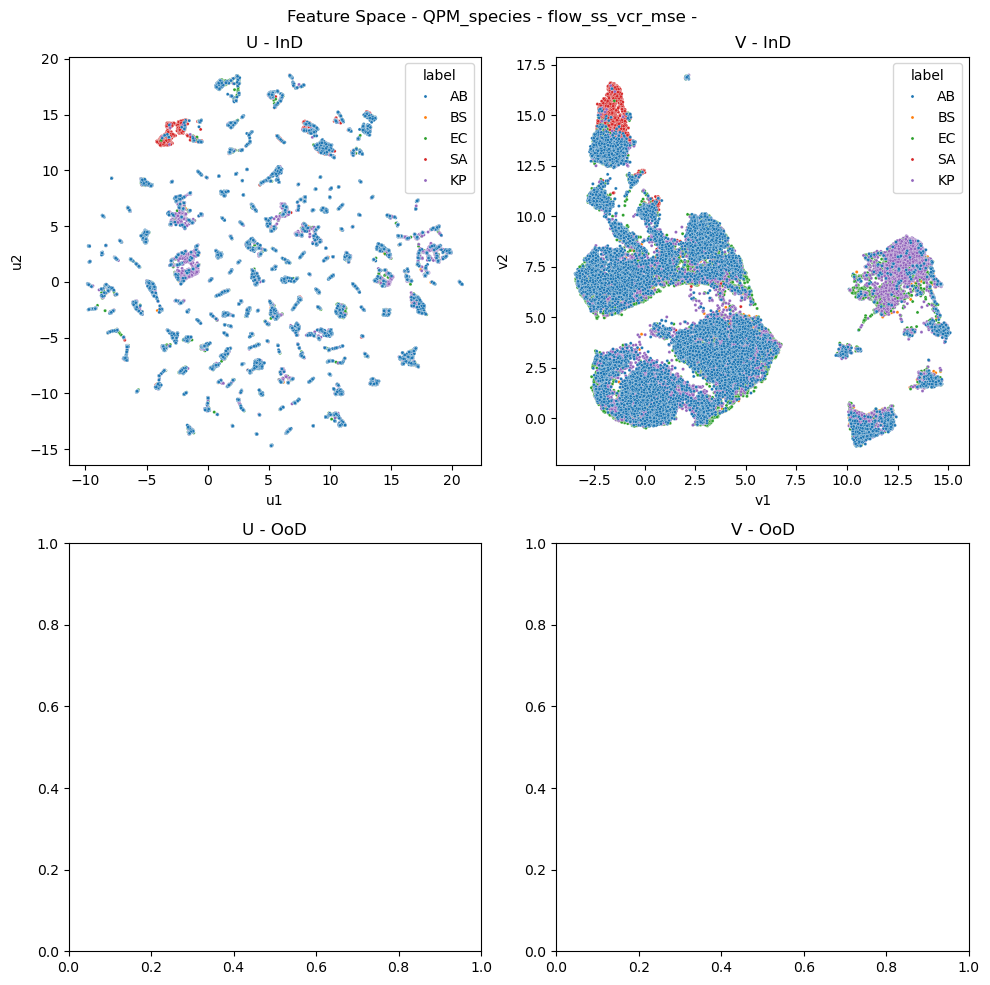

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

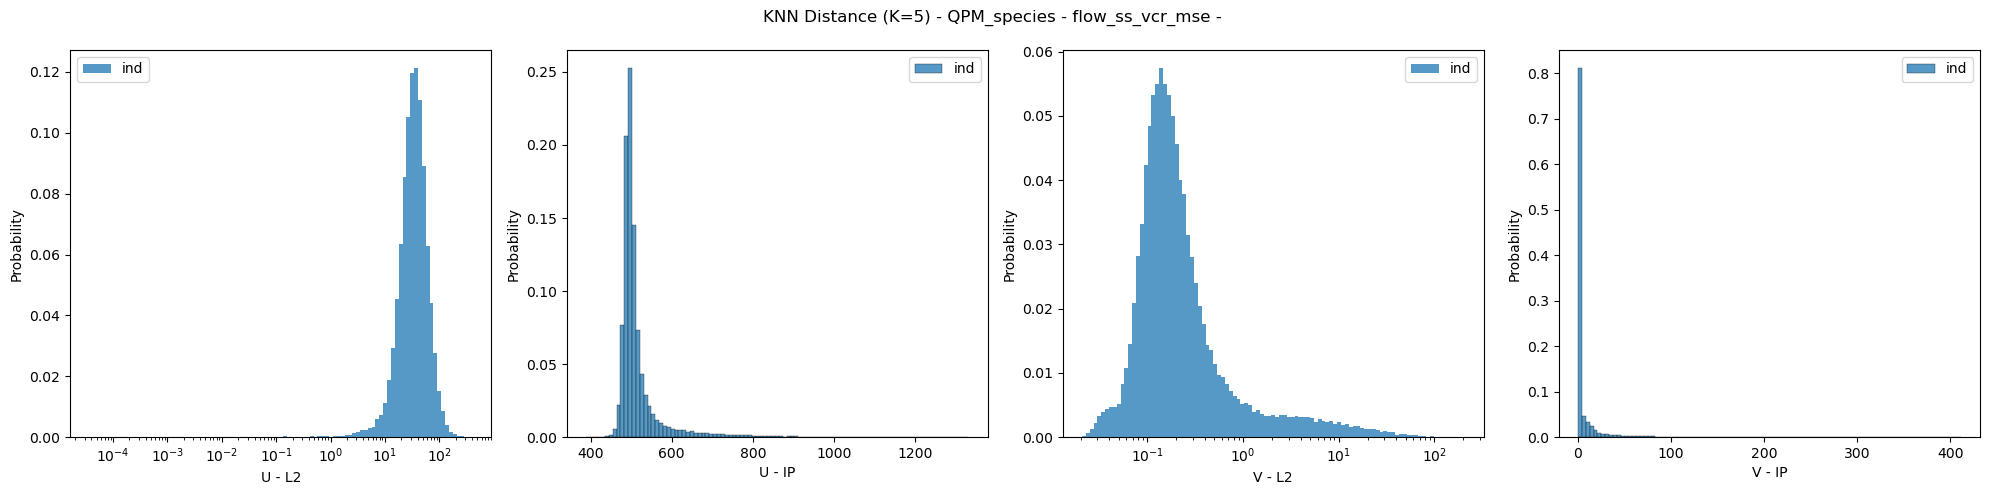

In [13]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[1], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[2], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[3], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

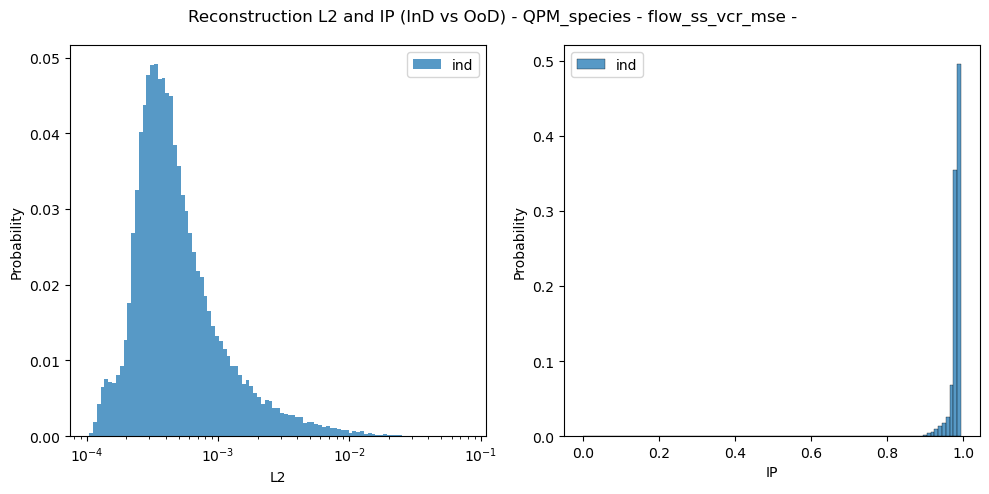

In [14]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_inp.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_inp.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

22.946756 0.901856 1.1398855 1.3923348
22.889233 0.8197141 1.0596936 1.2596544
22.995161 0.9976533 1.2165356 1.5436969
36.08451 1.0480405 54.154137 0.7570166


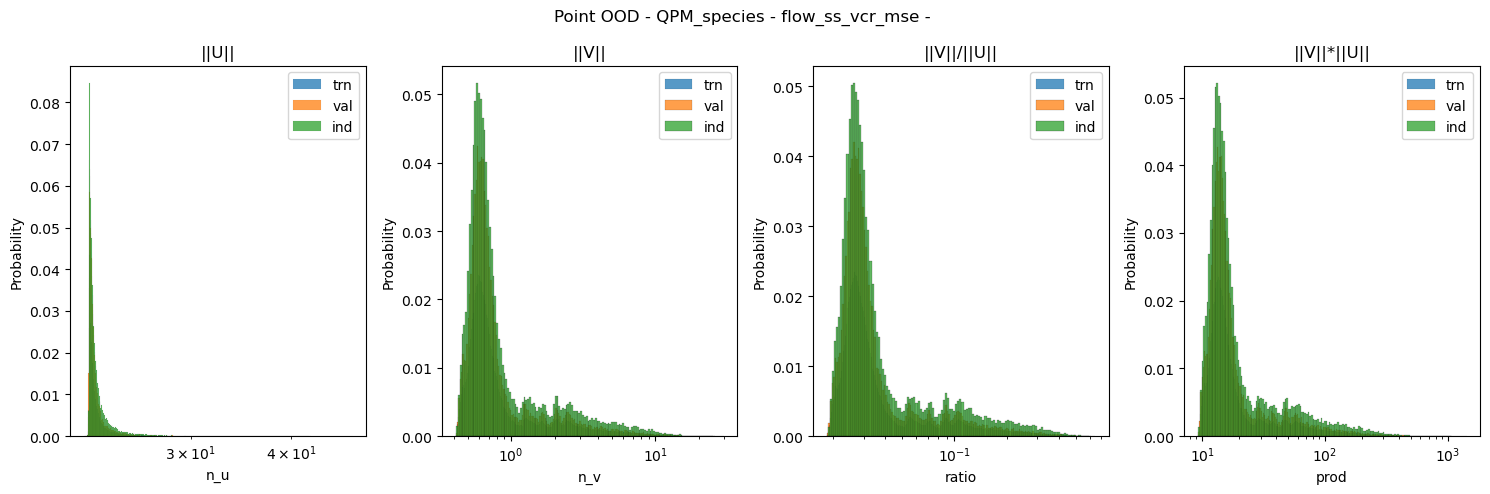

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


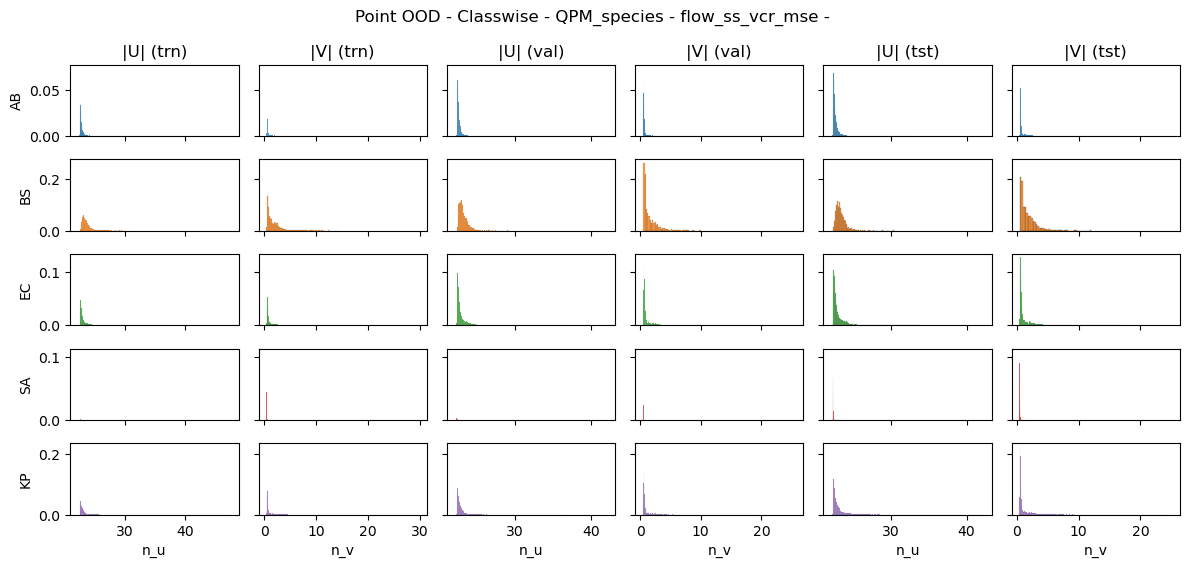

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

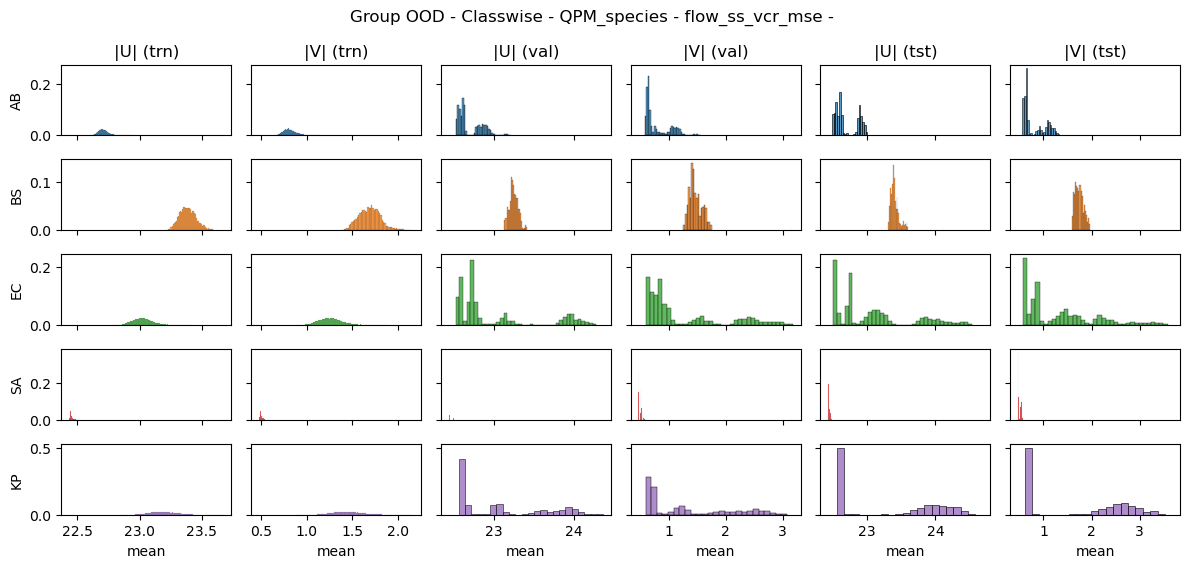

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()